<center> <h1> <span style="color:black"> IABE Data Science Certificate - Module 1 - Assignment  </h1> </center> 
<center> <h1> Frank Dhondt </h1> </center>
<center> <h2> <span style="color:red"> GLM and Neural Network for claim frequency </h1> </center>

# Table of contents
* [Chapter 0 - Loading an off-line dataset](#zero)
* [Chapter 1 - Import of libraries/functions and datasets](#one)
    + [1.1 Libraries/functions](#one-one)
    + [1.2 Data sets](#one-two)
* [Chapter 2 - Exploratory data analysis](#two)
    + [2.1 Exploration of the target variables](#two-one)
    + [2.2 Exploration of the features](#two-two)
    + [2.3 Generation of categorical feature `age_cat` from the numerical feature `ageph`](#two-three)
    + [2.4 Correlations between the different features](#two-four)
* [Chapter 3 - Preparations for fitting a GLM for claim frequency](#three)
    + [3.1 Creating a training and test dataset for fitting models to estimate claim frequency](#three-one)
    + [3.2 A marginal analysis of the target as a function of one of the features](#three-two)

* [Chapter 4 - Chapter 4 - Building a GLM for claim frequency *bottom-up*](#four)
    + [4.1 A model without features](#four-one)
    + [4.2 Selecting the first feature - `age_cat`](#four-two)
    + [4.3 Selecting the second feature - `province`](#four-three)
    + [4.4 Selecting the third feature - `split`](#four-four)
    + [4.5 Selecting the fourth feature - `pop_bucket`](#four-five)
    + [4.6 Selecting the fifth feature - `fuelc`](#four-six)
    + [4.7 Selecting the sixth feature - `coverp`](#four-seven)
    + [4.8 Selecting the seventh feature - `agecar`](#four-eight)
    + [4.9 Selecting the seventh feature - `powerc`](#four-nine)
    + [4.10 Closing the model](#four-ten)

* [Chapter 5. Fitting a Neural Network for frequency](#five)
    + [5.1 First NN with  features `ageph`(numerical) versus `age_cat` (categorical)](#five-one)
    + [5.2 NN with two features `ageph`(numerical) versus `age_cat` and `province` (categorical)](#five-two)
    + [5.3 NN with all features used in the final GLM](#five-three)

# Chapter 0 - Loading an off-line dataset <a name="zero"></a>

We load some additional data on the Belgian municipalities to link to the postcode in the mtpl data set (data set "`Gemeentes.xlsx`"). It contains the province and the number of inhabitants on 01/01/2016, together with two groupings:


*   Grouping by population size : grouped into "tiny" (<5,000), "small" (<15,000), "medium" (<30,000), "large" (<75,000) and "huge" (>75,000)
*   Grouping by population size [rounded to the neares '0,000 people]: "00K", "10K", "20K", ... , "90K" and  "100K", with all exceeding 100K in the "100+K" category 

[This will used as a proxy for a detailed analysis of spatial heterogeneity.]



In [631]:
from google.colab import files
uploaded = files.upload()

Saving Gemeentes.xlsx to Gemeentes (2).xlsx


# Chapter 1 - Import of libraries/functions and datasets <a name="one"></a>


## 1.1 Libraries/functions <a name="one-one"></a>

In [632]:
import pandas as pd
import math 
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.utils import plot_model #makes it easier to develop neural networks
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
import matplotlib.pyplot as plt
!pip install feature_engine
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
!pip install dython
from dython.nominal import associations

from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from scipy.stats.distributions import chi2

np.seterr(divide = 'ignore') 

{'divide': 'ignore', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

## 1.2 Data Sets <a name="one-two"></a>

### 1.2.1 Original input data

In [633]:
mtpl =pd.read_csv("https://gitfront.io/r/katrienantonio/a29071bdc7b2f20f24268be573ef54b68c65168c/IABE-DS-module-1/raw/assignment/assignment_data.csv", delimiter = ",")
mtpl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163657 entries, 0 to 163656
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   AGEPH     163657 non-null  int64  
 1   CODPOSS   163657 non-null  int64  
 2   duree     163657 non-null  float64
 3   lnexpo    163657 non-null  float64
 4   nbrtotc   163657 non-null  int64  
 5   nbrtotan  163657 non-null  float64
 6   chargtot  163657 non-null  float64
 7   agecar    163657 non-null  object 
 8   sexp      163657 non-null  object 
 9   fuelc     163657 non-null  object 
 10  split     163657 non-null  object 
 11  usec      163657 non-null  object 
 12  fleetc    163657 non-null  object 
 13  sportc    163657 non-null  object 
 14  coverp    163657 non-null  object 
 15  powerc    163657 non-null  object 
dtypes: float64(4), int64(3), object(9)
memory usage: 20.0+ MB


We see that the dataframe has 163657 rows (observations) and 16 colums (indexed 0 to 15). There are no missing data at first sight (all `non-null`).

After reading the original data set we start with some data preparation steps: we change upper to lower case in the variable names and rename output variable `duree` to `expo` to refer to the exposure measure.

In [634]:
mtpl.columns = mtpl.columns.str.lower()
mtpl = mtpl.rename(columns= {'duree': 'expo'})
mtpl.head()

,ageph,codposs,expo,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66
3,37,1030,0.169863,-1.772763,0,0.000000,0.000000,2-5,Female,Petrol,Once,Professional,No,No,MTPL+++,66-110
4,29,1030,1.000000,0.000000,0,0.000000,0.000000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,<66


In [635]:
mtpl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163657 entries, 0 to 163656
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ageph     163657 non-null  int64  
 1   codposs   163657 non-null  int64  
 2   expo      163657 non-null  float64
 3   lnexpo    163657 non-null  float64
 4   nbrtotc   163657 non-null  int64  
 5   nbrtotan  163657 non-null  float64
 6   chargtot  163657 non-null  float64
 7   agecar    163657 non-null  object 
 8   sexp      163657 non-null  object 
 9   fuelc     163657 non-null  object 
 10  split     163657 non-null  object 
 11  usec      163657 non-null  object 
 12  fleetc    163657 non-null  object 
 13  sportc    163657 non-null  object 
 14  coverp    163657 non-null  object 
 15  powerc    163657 non-null  object 
dtypes: float64(4), int64(3), object(9)
memory usage: 20.0+ MB


### 1.2.2 Data enrichment for limited spatial heterogeneity analysis

We now add the data from `Gemeentes.xlsx`, the dataset that was imported earlier.



In [636]:
cities=pd.read_excel("Gemeentes.xlsx" )
cities.head()

,Gemeente,Postcode,Provincie,Inwoners,Size,Inwoners_buckets
0,Brussel,1000,BRUS,178552,huge,105+K
1,Brussel,1020,BRUS,178552,huge,105+K
2,Schaarbeek,1030,BRUS,132590,huge,105+K
3,Etterbeek,1040,BRUS,47180,large,050K
4,Elsene,1050,BRUS,85541,huge,090K


In [637]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1141 entries, 0 to 1140
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Gemeente          1141 non-null   object
 1   Postcode          1141 non-null   int64 
 2   Provincie         1141 non-null   object
 3   Inwoners          1141 non-null   int64 
 4   Size              1141 non-null   object
 5   Inwoners_buckets  1141 non-null   object
dtypes: int64(2), object(4)
memory usage: 53.6+ KB


We will not include the `city` name as a feature in our models, but will include `province`  in the analysis.

We will also exclude the numerical variable `population` from our analysis, since it's already represented by two other different categorical variables "binning" the different cities in function of their population size.
The use of the latter two features in the analysis will be further examined later on.

In [638]:
cities.columns=["city","codposs","province","population", "city_size", "pop_bucket"]
#for c in ["city", "province" , "city_size", "pop_bucket"]: 
#  cities[c]=pd.Categorical(cities[c])
cities=cities.drop(columns=["city", "population"])
cities.head()

,codposs,province,city_size,pop_bucket
0,1000,BRUS,huge,105+K
1,1020,BRUS,huge,105+K
2,1030,BRUS,huge,105+K
3,1040,BRUS,large,050K
4,1050,BRUS,huge,090K


We then merge this additional data with the original dataset, using the postal code `codposs` as a merging key.
We then drop the `codposs` as a feature and continue with the `Province` instead.

In [639]:
mtpl=pd.merge(mtpl,cities,how="inner",on="codposs")
mtpl=mtpl.drop(columns='codposs')
mtpl.head()

,ageph,expo,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,province,city_size,pop_bucket
0,64,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110,BRUS,huge,105+K
1,28,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110,BRUS,huge,105+K
2,58,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66,BRUS,huge,105+K
3,62,1.000000,0.000000,0,0.000000,0.000000,>10,Female,Petrol,Once,Private,No,No,MTPL+,<66,BRUS,huge,105+K
4,41,1.000000,0.000000,1,1.000000,62.419590,6-10,Female,Petrol,Monthly,Private,No,No,MTPL,66-110,BRUS,huge,105+K


In [640]:
mtpl_orig=mtpl.copy() #We'll reuse this original dataset when fitting a Neural Network in section 5
mtpl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163657 entries, 0 to 163656
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ageph       163657 non-null  int64  
 1   expo        163657 non-null  float64
 2   lnexpo      163657 non-null  float64
 3   nbrtotc     163657 non-null  int64  
 4   nbrtotan    163657 non-null  float64
 5   chargtot    163657 non-null  float64
 6   agecar      163657 non-null  object 
 7   sexp        163657 non-null  object 
 8   fuelc       163657 non-null  object 
 9   split       163657 non-null  object 
 10  usec        163657 non-null  object 
 11  fleetc      163657 non-null  object 
 12  sportc      163657 non-null  object 
 13  coverp      163657 non-null  object 
 14  powerc      163657 non-null  object 
 15  province    163657 non-null  object 
 16  city_size   163657 non-null  object 
 17  pop_bucket  163657 non-null  object 
dtypes: float64(4), int64(2), object(12)
memory u

# Chapter 2. Exploratory data analysis <a name="two"></a>

## 2.1 Exploration of the target variables <a name="two-one"></a>

We calculate the empirical claim frequency per unit of exposure to risk to be just below 14% and determine the average claim amount to be at around €1,622.05 , to get a view on the severity of the claim.

In [641]:
print("Global average frequency of observations in the dataset: " + str(mtpl.nbrtotc.sum()/mtpl.expo.sum()))
print("Global average severity of observations in the dataset: " + str(mtpl.chargtot.sum()/mtpl.nbrtotc.sum()))

Global average frequency of observations in the dataset: 0.13933551567344968
Global average severity of observations in the dataset: 1622.0543005764384


We then inspect the empirical distribution of the number of claims reported, to see that for about 90% of the policyholders no claim was reported.

In [642]:
mtpl.nbrtotc.value_counts()

0    145312
1     16602
2      1562
3       162
4        17
5         2
Name: nbrtotc, dtype: int64

In [643]:
mtpl.nbrtotc.value_counts()/len(mtpl.nbrtotc)

0    0.887906
1    0.101444
2    0.009544
3    0.000990
4    0.000104
5    0.000012
Name: nbrtotc, dtype: float64

We look at the maximal claim charge and the maximal average claim amount (per policyholder) - both of which are equal and just below €2mio - and then count the number of policyholders with average and total claim amounts above certain treshold values.

The fact that maximaul claim charge and maximal average claim charge are equal indicates that this maximal claim happened to a policyholder having only 1 claim.


In [644]:
mtpl.chargtot.max()

1989567.8968

In [645]:
mtpl["severity"]=mtpl.chargtot/mtpl.nbrtotc
mtpl.severity.max()

1989567.8968

In [646]:
for t in [10000, 20000, 50000, 100000, 250000, 500000, 1000000, 1500000] :
  print("There are "+ str(mtpl[mtpl.severity > t].ageph.count()) + " policyholders out of "+str(mtpl.ageph.count()) + " with average claim amount above €" + str(t))

There are 323 policyholders out of 163657 with average claim amount above €10000
There are 158 policyholders out of 163657 with average claim amount above €20000
There are 36 policyholders out of 163657 with average claim amount above €50000
There are 16 policyholders out of 163657 with average claim amount above €100000
There are 7 policyholders out of 163657 with average claim amount above €250000
There are 1 policyholders out of 163657 with average claim amount above €500000
There are 1 policyholders out of 163657 with average claim amount above €1000000
There are 1 policyholders out of 163657 with average claim amount above €1500000


In [647]:
for t in [10000, 20000, 50000, 100000, 250000, 500000, 1000000, 1500000] :
  print("There are "+ str(mtpl[mtpl.chargtot > t].ageph.count()) + " policyholders out of "+str(mtpl.ageph.count()) + " with total claim amount above €" + str(t))

There are 362 policyholders out of 163657 with total claim amount above €10000
There are 179 policyholders out of 163657 with total claim amount above €20000
There are 40 policyholders out of 163657 with total claim amount above €50000
There are 17 policyholders out of 163657 with total claim amount above €100000
There are 9 policyholders out of 163657 with total claim amount above €250000
There are 1 policyholders out of 163657 with total claim amount above €500000
There are 1 policyholders out of 163657 with total claim amount above €1000000
There are 1 policyholders out of 163657 with total claim amount above €1500000


There are only very few policyholders with average or total claim amount above €10,000. We therefore plot the distribution of the average and total claim amount up until €10,000, using a histogram. We exclude the observations without claims, since we already know how much there are of those (145,312). We see that most of the policyholders have very low claims.

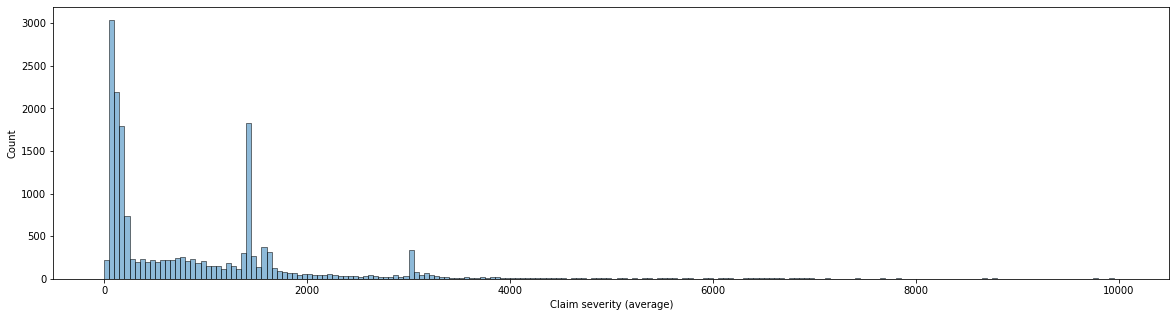

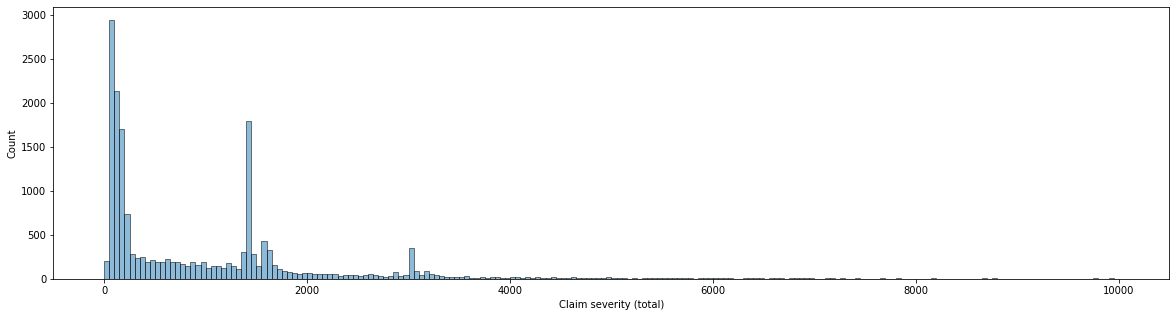

In [648]:
plt.figure(figsize=(20,5));
sns.histplot(data=mtpl, x= "severity", alpha=0.5, bins=200, binrange=[0,10000])  
plt.xlabel("Claim severity (average)")
plt.show()
plt.figure(figsize=(20,5));
sns.histplot(data=mtpl, x= "chargtot", alpha=0.5, bins=200, binrange=[0.1,10000])  
plt.xlabel("Claim severity (total)")
plt.show()

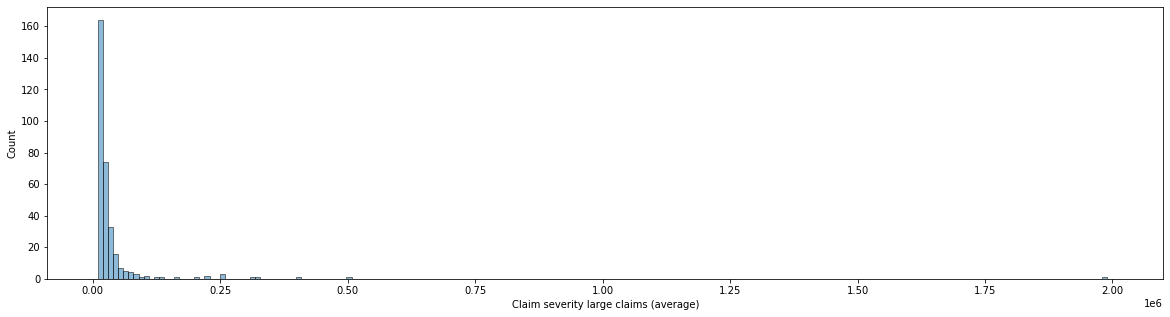

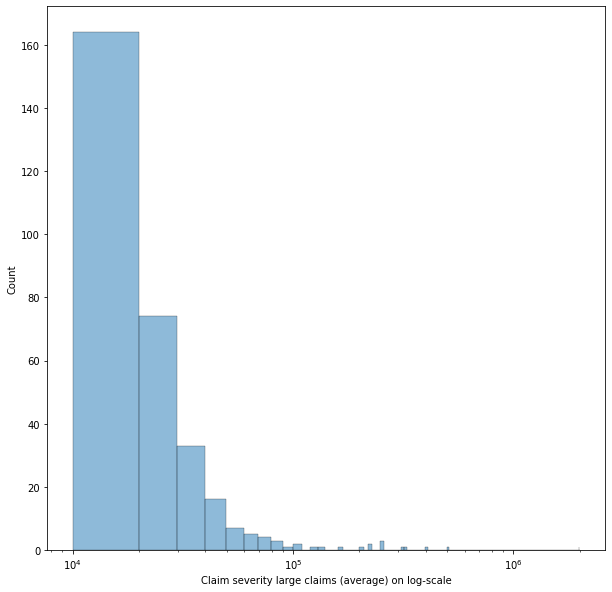

In [649]:
plt.figure(figsize=(20,5));
sns.histplot(data=mtpl, x= "severity", alpha=0.5, bins=200, binrange=[10000,2000000])  
plt.xlabel("Claim severity large claims (average)")
#plt.xscale('log')
plt.show()
plt.figure(figsize=(10,10));
sns.histplot(data=mtpl, x= "severity", alpha=0.5, bins=200, binrange=[10000,2000000])  
plt.xscale('log')
plt.xlabel("Claim severity large claims (average) on log-scale")
plt.show()

## 2.2 Exploration of the features <a name="two-two"></a>

We examine the distribution of the features in the dataset that we've constituted. 


43    0.024509
49    0.024484
47    0.024142
50    0.024026
51    0.023959
        ...   
91    0.000073
93    0.000055
95    0.000031
94    0.000018
17    0.000012
Name: ageph, Length: 79, dtype: float64

--- + --- + --- + --- + --- + --- + --- + --- + --- + ---

6-10    0.410315
2-5     0.315043
>10     0.227189
0-1     0.047453
Name: agecar, dtype: float64

--- + --- + --- + --- + --- + --- + --- + --- + --- + ---

Male      0.735893
Female    0.264107
Name: sexp, dtype: float64

--- + --- + --- + --- + --- + --- + --- + --- + --- + ---

Petrol    0.691752
Gasoil    0.308248
Name: fuelc, dtype: float64

--- + --- + --- + --- + --- + --- + --- + --- + --- + ---

Once       0.497864
Twice      0.280837
Monthly    0.144198
Thrice     0.077100
Name: split, dtype: float64

--- + --- + --- + --- + --- + --- + --- + --- + --- + ---

Private         0.951087
Professional    0.048913
Name: usec, dtype: float64

--- + --- + --- + --- + --- + --- + --- + --- + --- + ---

No     0.968049
Yes  

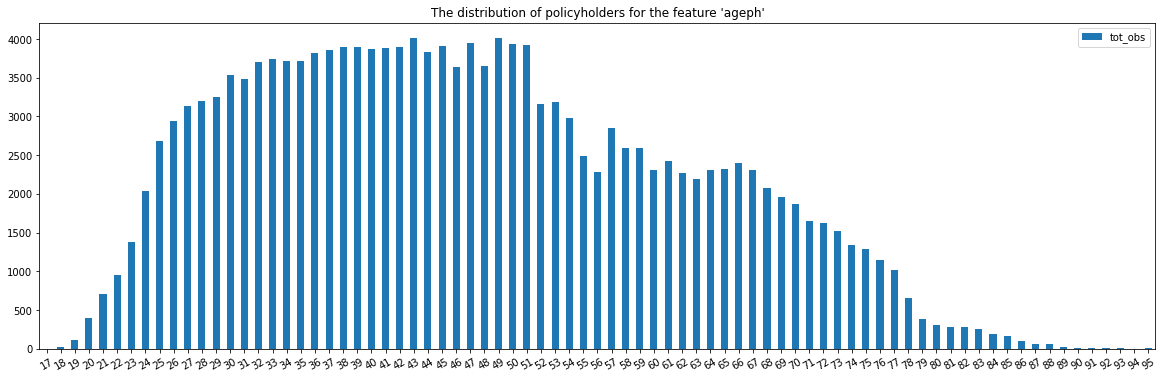

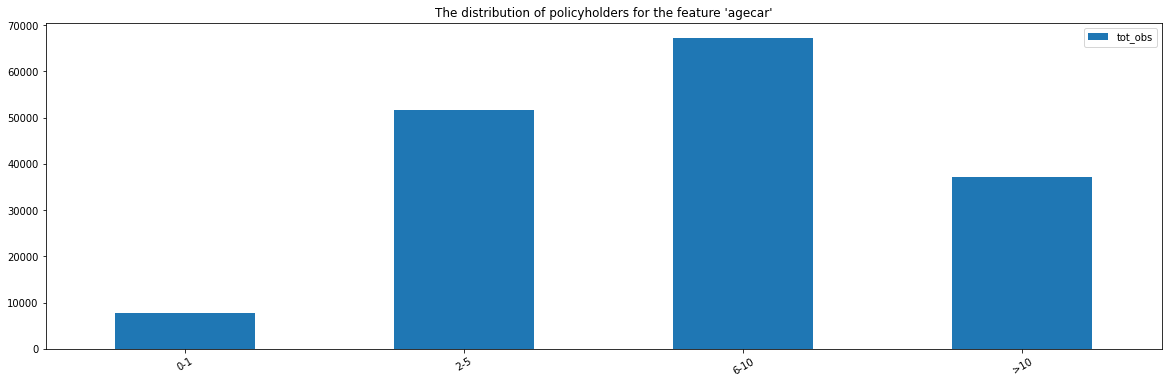

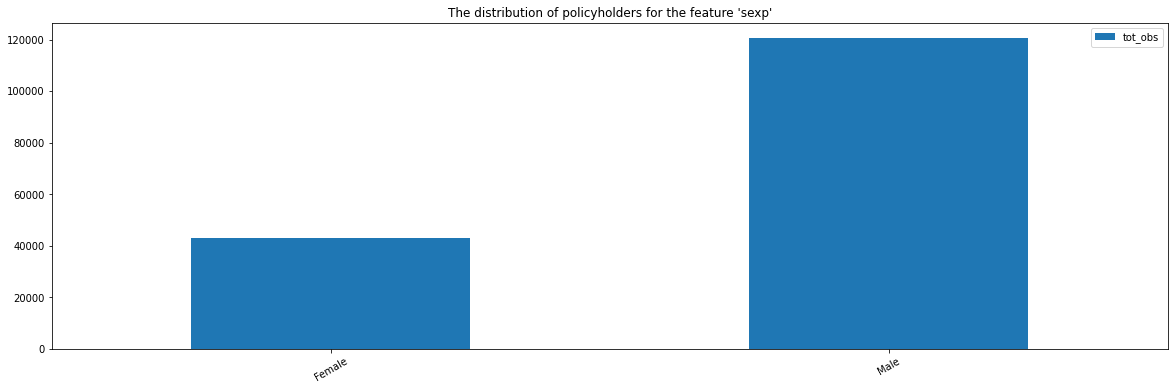

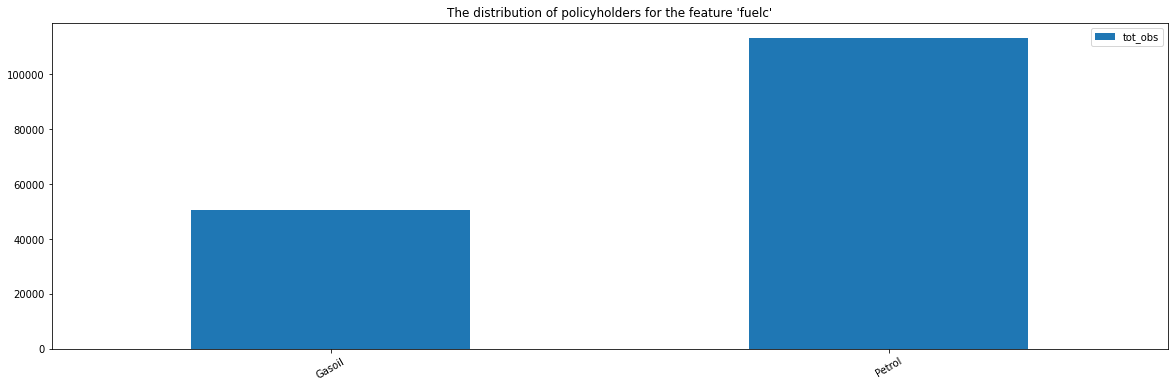

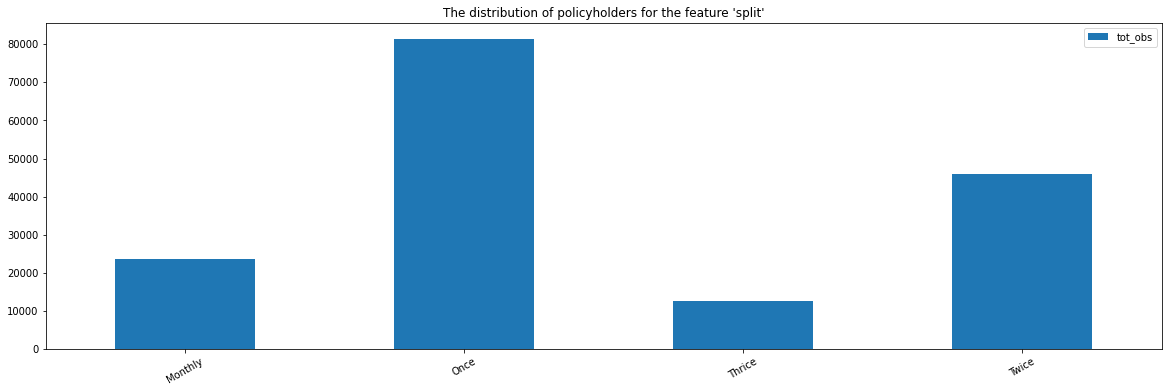

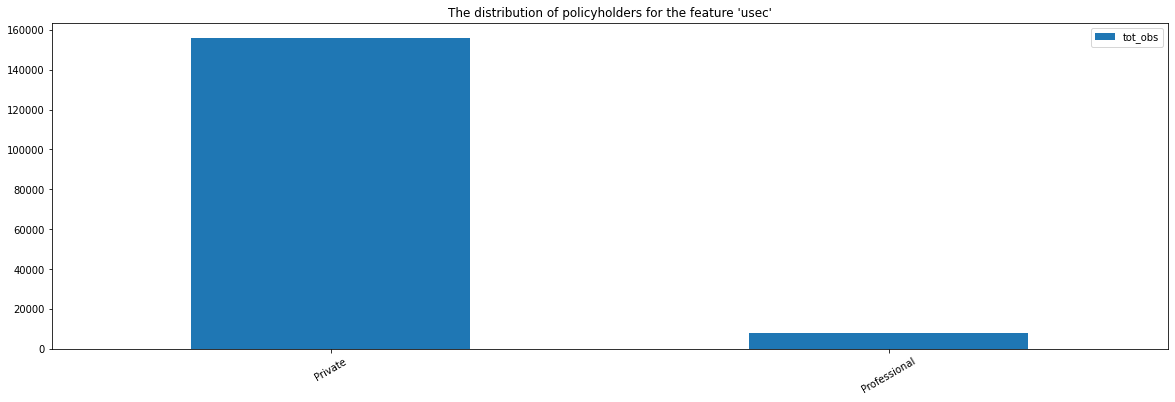

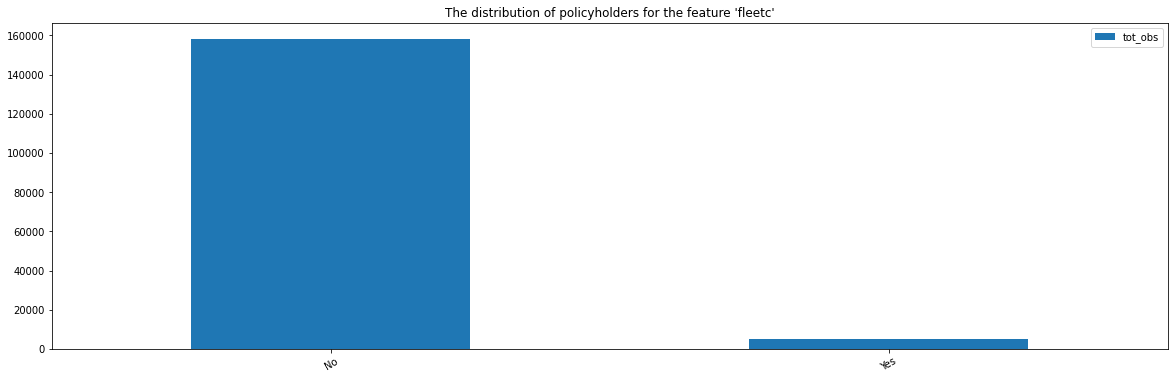

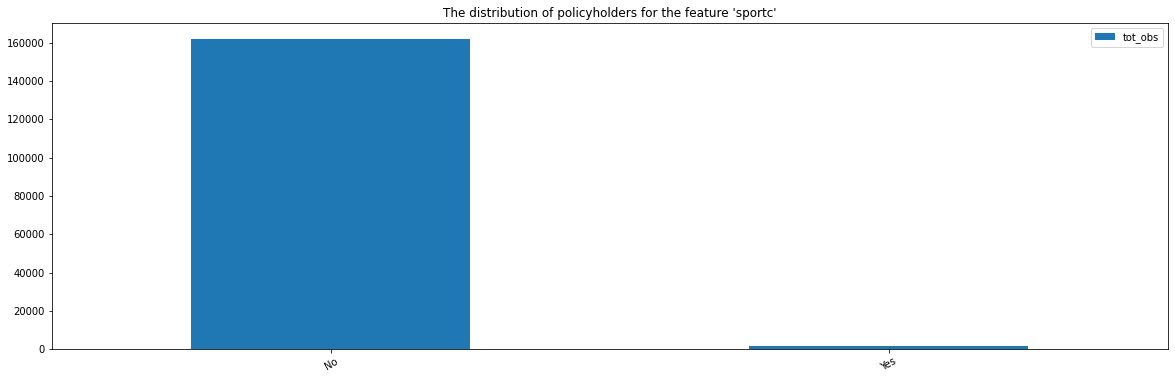

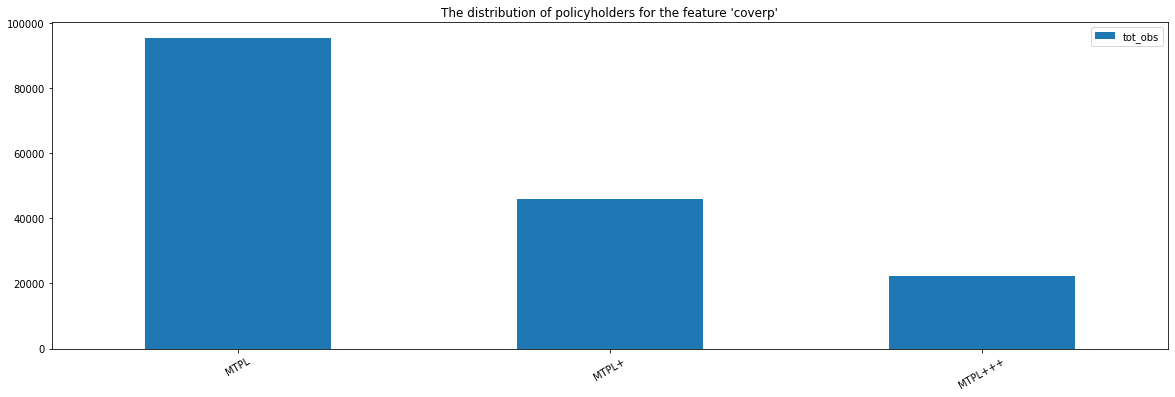

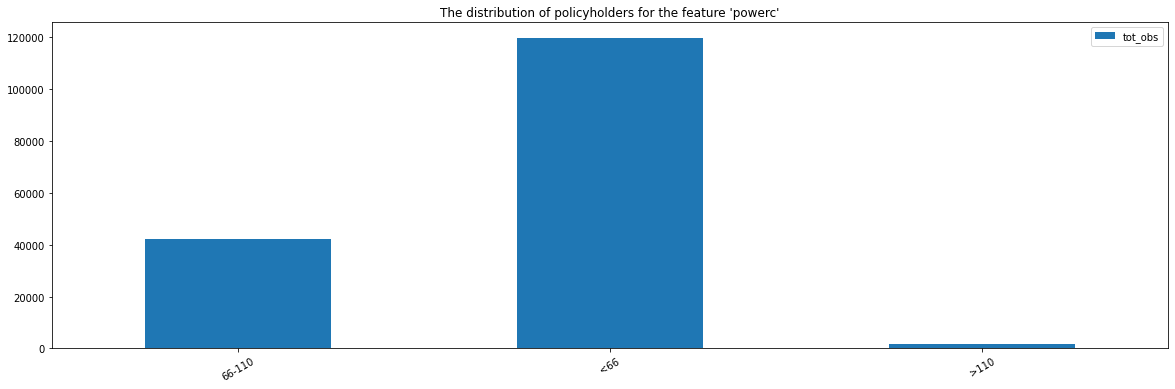

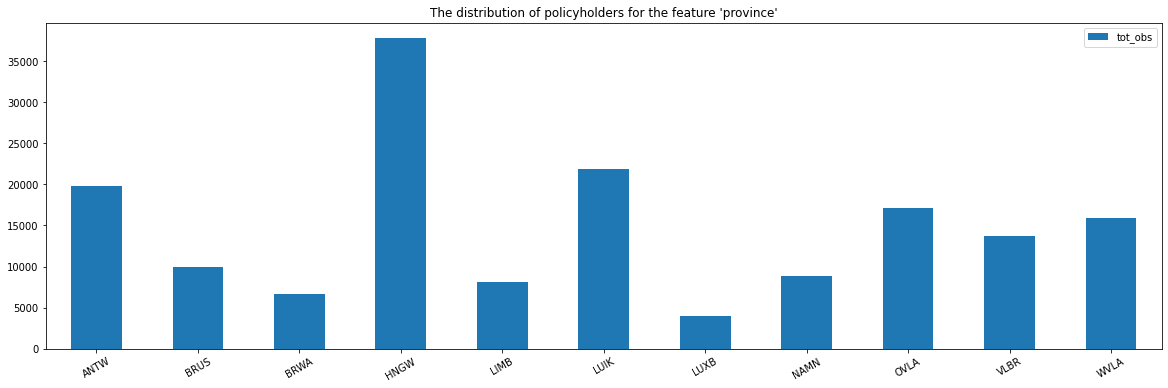

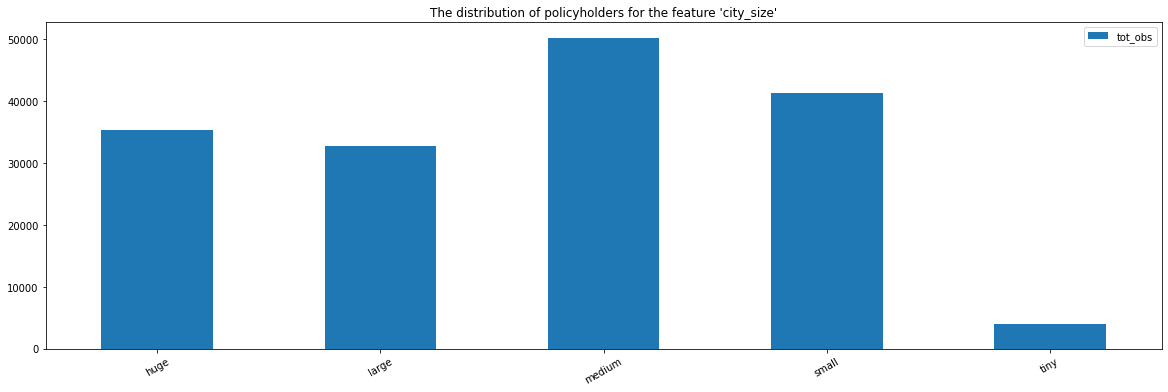

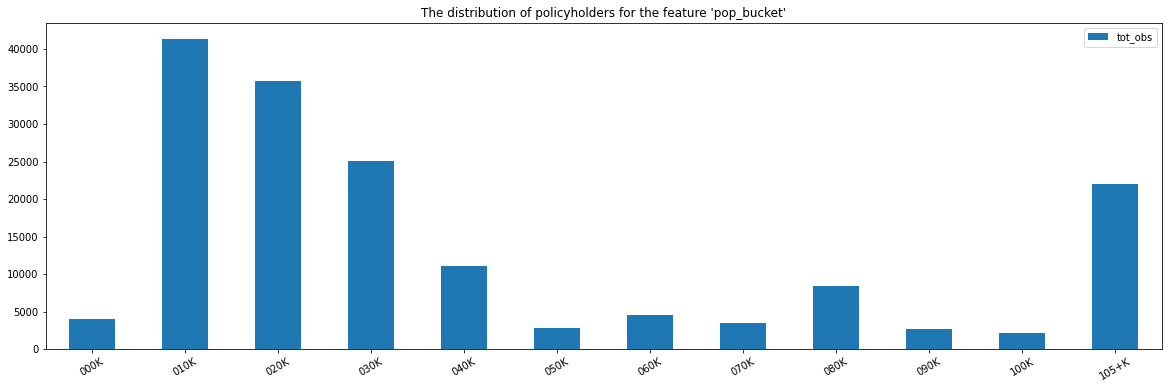

In [650]:
def exam_feature(variable) :
 data = mtpl.groupby([mtpl[variable]]).agg(tot_obs = ('nbrtotc', 'count'))
 data.reset_index(inplace = True)
 plt.rcParams['figure.figsize'] = [20, 6]
 plot=data.loc[:,[variable, 'tot_obs']]
 plot[variable]=plot[variable].astype("category")
 plot.plot(kind='bar', rot=30)
 plt.xticks(range(plot.shape[0]),list(plot.iloc[:,0]), rotation=30)
 plt.title("The distribution of policyholders for the feature '"+ variable + "'")
 plot = plt.show
 
 print("")
 print(mtpl[variable].value_counts()/len(mtpl[variable]))
 print("")
 print("--- + --- + --- + --- + --- + --- + --- + --- + --- + ---")


for c in ["ageph","agecar", "sexp", "fuelc", "split", "usec", "fleetc", "sportc", "coverp", "powerc", "province", "city_size", "pop_bucket"] :
  exam_feature(c)
 
 

We notice that there are very few policyholders that have insured a car that is 


*   used for professional purposes
*   part of a fleet of cars
*   is a sport car
*   a very powerful car (>110k)

If almost all lines show the same value for a certain variable with only two options, that might be  a clear indication that this variable has little or no discriminating value.

There are also very few observation for very young (<=21 years) and very old policyholders (>=78 years).

If there are very few observations for a single value of a variable with many options, that might be a clear indication that that value must be "binned" with other neighbouring values (see below).


## 2.3 Generation of categorical feature `age_cat` from the numerical feature `ageph` <a name="two-three"></a>

From the numerical feature `ageph`, we generate a new categorical feature `age_cat`, that includes an initial binning of the ages into buckets. A further binning of these initial buckets will be examined further on.

Using the numerical feature `ageph` would mean that we implicitly assume that there is a strictly increasing or decreasing trend between the age of the policyholder and the frequency of claim occurrences. This is not a realistic assumption.

Based on the examination of the variable `ageph` in the previous section, we bin the values 18 to 20 and 21 to 23. We further bin the other values by groups of 5, until the age of 85. All ages as from 85, we group them together in a single bin.

In [651]:
mtpl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163657 entries, 0 to 163656
Data columns (total 19 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ageph       163657 non-null  int64  
 1   expo        163657 non-null  float64
 2   lnexpo      163657 non-null  float64
 3   nbrtotc     163657 non-null  int64  
 4   nbrtotan    163657 non-null  float64
 5   chargtot    163657 non-null  float64
 6   agecar      163657 non-null  object 
 7   sexp        163657 non-null  object 
 8   fuelc       163657 non-null  object 
 9   split       163657 non-null  object 
 10  usec        163657 non-null  object 
 11  fleetc      163657 non-null  object 
 12  sportc      163657 non-null  object 
 13  coverp      163657 non-null  object 
 14  powerc      163657 non-null  object 
 15  province    163657 non-null  object 
 16  city_size   163657 non-null  object 
 17  pop_bucket  163657 non-null  object 
 18  severity    18345 non-null   float64
dtypes:

In [652]:
mtpl["age_cat"] = np.where(mtpl['ageph'] < 21, "18-20", np.where(mtpl['ageph'] <24 ,"21-23", \
                              np.where(mtpl['ageph'] < 27, "24-26", np.where(mtpl['ageph'] < 30, "27-29", \
                              np.where(mtpl['ageph'] < 35, "30-34", np.where(mtpl['ageph'] < 40, "35-39", \
                              np.where(mtpl['ageph'] < 45, "40-44", np.where(mtpl['ageph'] < 50, "45-49", \
                              np.where(mtpl['ageph'] < 55, "50-54", np.where(mtpl['ageph'] < 60, "55-59", \
                              np.where(mtpl['ageph'] < 65, "60-64", np.where(mtpl['ageph'] < 70, "65-69", \
                              np.where(mtpl['ageph'] < 75, "70-74", np.where(mtpl['ageph'] < 80, "75-79", \
                              np.where(mtpl['ageph'] < 85, "80-84", ">=85")))))))))))))))
mtpl.head()

,ageph,expo,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,province,city_size,pop_bucket,severity,age_cat
0,64,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110,BRUS,huge,105+K,NaN,60-64
1,28,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110,BRUS,huge,105+K,155.974606,27-29
2,58,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66,BRUS,huge,105+K,NaN,55-59
3,62,1.000000,0.000000,0,0.000000,0.000000,>10,Female,Petrol,Once,Private,No,No,MTPL+,<66,BRUS,huge,105+K,NaN,60-64
4,41,1.000000,0.000000,1,1.000000,62.419590,6-10,Female,Petrol,Monthly,Private,No,No,MTPL,66-110,BRUS,huge,105+K,62.419590,40-44



40-44    0.119121
35-39    0.117233
45-49    0.117086
30-34    0.111080
50-54    0.104951
55-59    0.078212
60-64    0.070251
65-69    0.067513
27-29    0.058635
70-74    0.048993
24-26    0.046787
75-79    0.027435
21-23    0.018557
80-84    0.008053
18-20    0.003226
>=85     0.002866
Name: age_cat, dtype: float64

--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


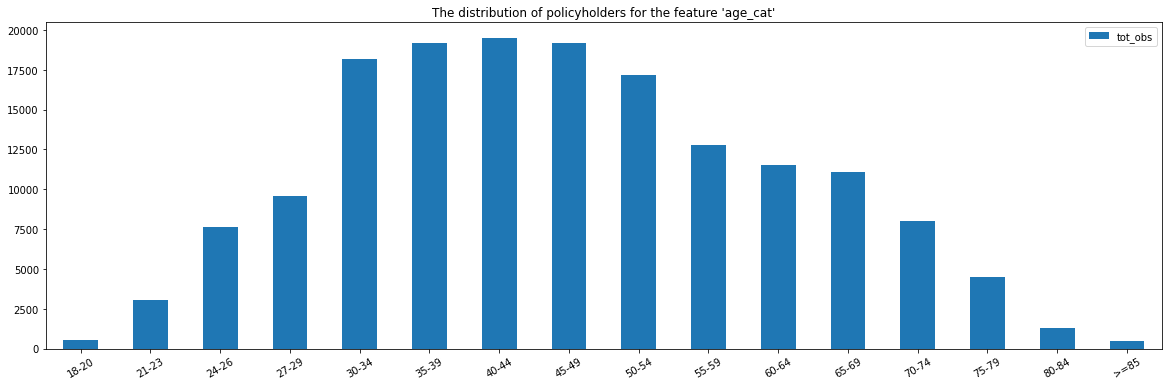

In [653]:
exam_feature('age_cat')

## 2.4 Correlations between the different features <a name="two-four"></a>

We've ended up with only categorical features that will serve as an input for  the GLM and Neural Network models that we'll build for claim frequency. Before starting to build the models, we examine if there is a correlation between the different features. If two or more features are strongly correlated, it is not whise to include them all in the input for a model.

For categorical features, correlation is examined by means of the Cramer V  (symmetrical) or Theil's U (non symmetrical).

More on this topic, including the reference to the `dython` library that we'll use her on 
https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

We use the `associations` function built in the `dython` library to plot a heat map for categorical correlation, both for the "Cramer V" standard option and for the "Theil's U" option.

This function does not seem to work when the variables are actually specified as a `categorical` type which is why we have currently left them as an `object` type.

*(Please note that these procedures may take somewhat more time to run, the second one more than the first one)*

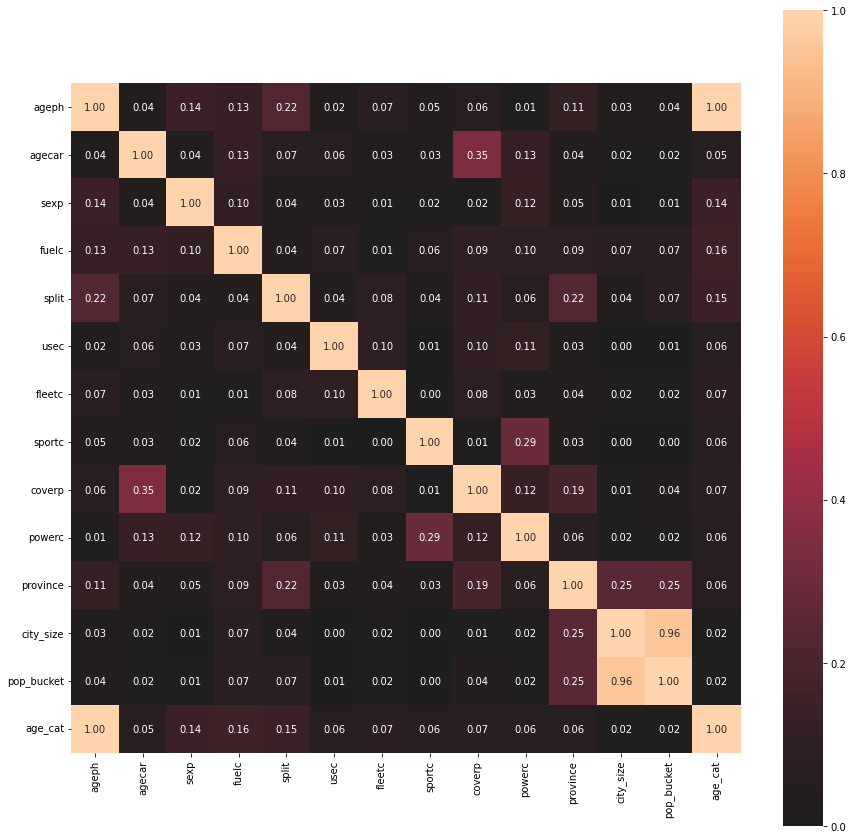

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5930545110>,
 'corr':                ageph    agecar      sexp  ...  city_size  pop_bucket   age_cat
 ageph       1.000000  0.036721  0.142766  ...   0.027051    0.037784  0.995860
 agecar      0.036721  1.000000  0.038217  ...   0.018928    0.022142  0.051718
 sexp        0.142766  0.038217  1.000000  ...   0.006003    0.009329  0.143570
 fuelc       0.130005  0.129318  0.103011  ...   0.066125    0.069279  0.162391
 split       0.223579  0.065559  0.043176  ...   0.035763    0.065696  0.146856
 usec        0.023733  0.059333  0.031176  ...   0.000000    0.005188  0.056809
 fleetc      0.067764  0.033848  0.010306  ...   0.016186    0.021688  0.071556
 sportc      0.046746  0.031113  0.017475  ...   0.000000    0.000000  0.055264
 coverp      0.056151  0.349926  0.015539  ...   0.014676    0.044063  0.068920
 powerc      0.012037  0.132234  0.120372  ...   0.015040    0.019761  0.059012
 province    0.109914  0.044137  0.045053  ...

In [654]:
features=mtpl.drop(columns=['expo', 'lnexpo', 'nbrtotc', 'nbrtotan', 'chargtot', 'severity'])
associations(features, figsize=(15,15)) #Uses Cramer's V as default

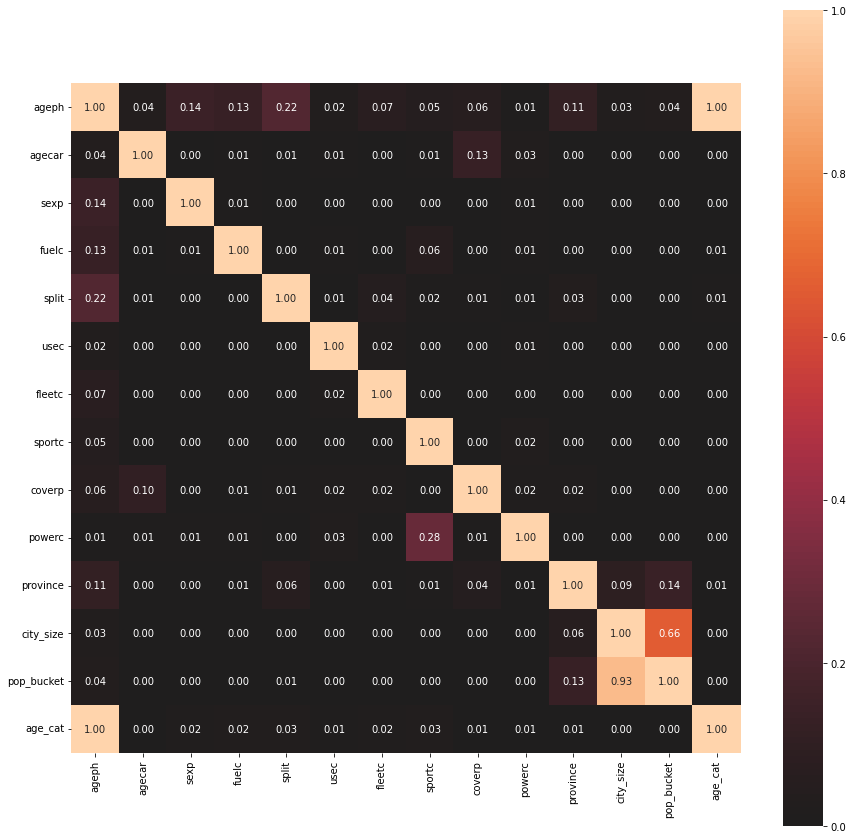

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5930532b90>,
 'corr':                ageph    agecar      sexp  ...  city_size  pop_bucket   age_cat
 ageph       1.000000  0.036721  0.142766  ...   0.027051    0.037784  0.995860
 agecar      0.036721  1.000000  0.001276  ...   0.000390    0.000405  0.001583
 sexp        0.142766  0.000608  1.000000  ...   0.000021    0.000037  0.004231
 fuelc       0.130005  0.006932  0.009547  ...   0.001517    0.001199  0.006023
 split       0.223579  0.005100  0.001601  ...   0.001337    0.003102  0.013374
 usec        0.023733  0.001464  0.000895  ...   0.000003    0.000023  0.000762
 fleetc      0.067764  0.000510  0.000096  ...   0.000099    0.000130  0.000979
 sportc      0.046746  0.000438  0.000294  ...   0.000005    0.000016  0.000555
 coverp      0.056151  0.101746  0.000220  ...   0.000165    0.000980  0.002035
 powerc      0.012037  0.014785  0.013297  ...   0.000173    0.000223  0.001524
 province    0.109914  0.002506  0.001784  ...

In [655]:
associations(features, nom_nom_assoc='theil', figsize=(15,15))

As expected, there is an extremely strong correlation between the `city_size` and the `pop_bucket`. We will not use both of them in the models. 

No other correlations between two features are so strong as to exclude the simultaneous inclusion of those features in the model on an a priori basis.

A slight correlation between the `age_car` and the `coverage` is showing, which is normal, since the full coverage (omnium) is generally taken for younger cars.

There is also some correlation showing for the `powerc` of the car and the `sportc` type of car : sport cars are generally indeed more powerful.


We now turn all the `object`-type features into `categorical` type.

In [656]:
for c in ["agecar", "sexp", "fuelc", "split", "usec", "fleetc", "sportc", "coverp", "powerc", "age_cat", "province", "city_size", "pop_bucket"]:
    mtpl[c]=pd.Categorical(mtpl[c])

# Chapter 3 - Preparations for fitting a GLM for claim frequency <a name="three"></a>

## 3.1 Creating a training and test dataset for fitting models to estimate claim frequency <a name="three-one"></a>

Before starting the fit of the model for claim frequency, we create a training/test split in a stratified way with respect to the variable most relevant for the target (=frequency), the number of claims (`nbrtotc`).

We use the train_test_split function from sklearn to create a training and test set using stratified sampling according to the y_cat variable. We choose to build a training set which corresponds to 80% of the initial dataset.  
We check that the distribution over the full dataset will be preserved in the training and test sets.

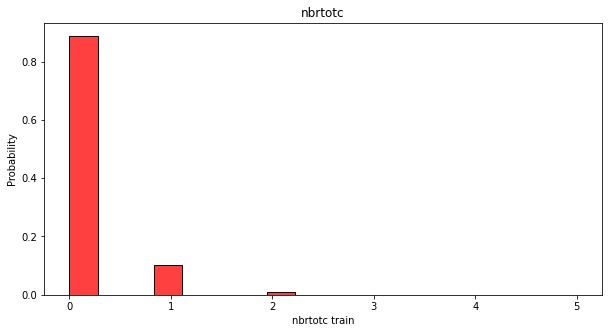

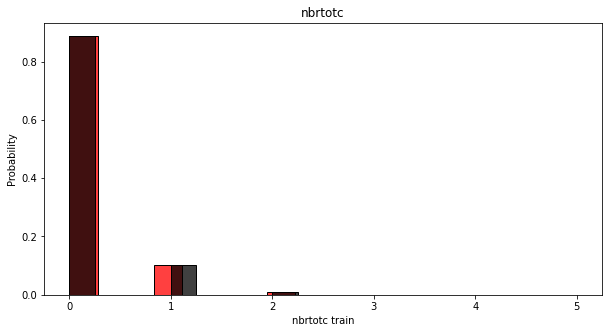

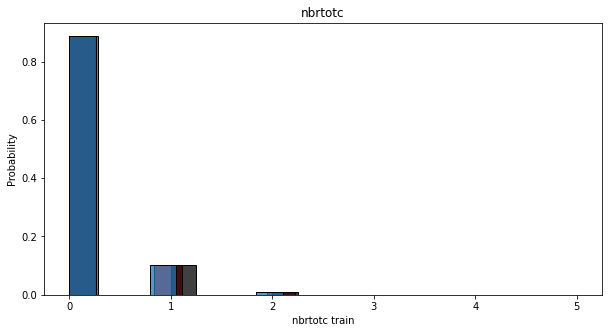

MTPL - Frequency and exposure for the different categories of variable age_cat in the total dataset:

   age_cat  tot_expo      freq
0    18-20  0.003035  0.330399
1    21-23  0.017483  0.261994
2    24-26  0.045627  0.229071
3    27-29  0.057051  0.194757
4    30-34  0.107369  0.160345
5    35-39  0.114238  0.142829
6    40-44  0.117900  0.137403
7    45-49  0.117417  0.139605
8    50-54  0.106271  0.123682
9    55-59  0.079212  0.120852
10   60-64  0.072128  0.099778
11   65-69  0.070293  0.100136
12   70-74  0.051701  0.096033
13   75-79  0.029105  0.096503
14   80-84  0.008361  0.121564
15    >=85  0.002811  0.114817
MTPL - Frequency and exposure for the different categories of variable age_cat in the training dataset:

   age_cat  tot_expo      freq
0    18-20  0.002954  0.305021
1    21-23  0.017364  0.264925
2    24-26  0.045082  0.227492
3    27-29  0.057317  0.193155
4    30-34  0.107368  0.161225
5    35-39  0.114345  0.144258
6    40-44  0.117158  0.134787
7    45-49  0.1172

In [657]:
np.random.seed(123)

mtpl_X = mtpl.drop(labels=['nbrtotc'], axis=1) 
mtpl_X_train, mtpl_X_test, mtpl_y_train, mtpl_y_test = train_test_split(mtpl_X,mtpl.nbrtotc, test_size=0.2, stratify=mtpl.nbrtotc)


mtpl_train=mtpl_X_train
mtpl_train["nbrtotc"]=mtpl_y_train

mtpl_train_orig=mtpl_train.copy() #We'll reuse this original dataset when fitting a Neural Network in section 5

mtpl_test=mtpl_X_test
mtpl_test["nbrtotc"]=mtpl_y_test

mtpl_test_orig=mtpl_test.copy()

df = pd.DataFrame(mtpl_y_train)
df1 = pd.DataFrame(mtpl_y_test)
df2 = mtpl.nbrtotc

plot_pd = pd.concat([df,df1, df2], ignore_index=True, axis=1)

#rename columns for x-label
plot_pd.columns = ['nbrtotc train', 'nbrtotc test', 'nbrtotc']


fig, axs = plt.subplots(ncols=1, figsize=(10,5));
sns.histplot(plot_pd['nbrtotc train'], ax = axs, color='r', stat = 'probability').set(title='nbrtotc'); 
#sns.histplot(plot_pd['nbrtotc test'], ax = axs, color='k', stat = 'probability'); 
#sns.histplot(plot_pd['nbrtotc'], ax = axs, stat = 'probability'); 
plt.show()

fig, axs = plt.subplots(ncols=1, figsize=(10,5));
sns.histplot(plot_pd['nbrtotc train'], ax = axs, color='r', stat = 'probability').set(title='nbrtotc'); 
sns.histplot(plot_pd['nbrtotc test'], ax = axs, color='k', stat = 'probability'); 
#sns.histplot(plot_pd['nbrtotc'], ax = axs, stat = 'probability'); 
plt.show()

fig, axs = plt.subplots(ncols=1, figsize=(10,5));
sns.histplot(plot_pd['nbrtotc train'], ax = axs, color='r', stat = 'probability').set(title='nbrtotc'); 
sns.histplot(plot_pd['nbrtotc test'], ax = axs, color='k', stat = 'probability'); 
sns.histplot(plot_pd['nbrtotc'], ax = axs, stat = 'probability'); 
plt.show()

def freq_analysis (var) :
  data = mtpl.groupby([mtpl[var]]).agg(tot_obs = ('nbrtotc', 'count'), tot_cln=('nbrtotc', 'sum'), tot_expo = ('expo', 'sum'), tot_cla=('chargtot', 'sum'))
  data.reset_index(inplace = True)
  sum_expo=data.tot_expo.sum()
  data["freq"]=data.tot_cln/data.tot_expo #Frequency is total number of claims divided by total exposure for each value of "var"
  data.tot_expo=data.tot_expo/sum_expo
  #data["sev"]=data.tot_cla/data.tot_cln #Severity is total claim amount divided by total claim number for each value of "var"

  data_train = mtpl_train.groupby([mtpl_train[var]]).agg(tot_obs = ('nbrtotc', 'count'), tot_cln=('nbrtotc', 'sum'), tot_expo = ('expo', 'sum'), tot_cla=('chargtot', 'sum'))
  data_train.reset_index(inplace = True)
  sum_expo_train=data_train.tot_expo.sum()
  data_train["freq"]=data_train.tot_cln/data_train.tot_expo
  data_train.tot_expo=data_train.tot_expo/sum_expo_train

  data_test = mtpl_test.groupby([mtpl_test[var]]).agg(tot_obs = ('nbrtotc', 'count'), tot_cln=('nbrtotc', 'sum'), tot_expo = ('expo', 'sum'), tot_cla=('chargtot', 'sum'))
  data_test.reset_index(inplace = True)
  sum_expo_test=data_test.tot_expo.sum()
  data_test["freq"]=data_test.tot_cln/data_test.tot_expo
  data_test.tot_expo=data_test.tot_expo/sum_expo_test

  data_print = data.drop(columns=['tot_obs', 'tot_cln', 'tot_cla'])
  print('MTPL - Frequency and exposure for the different categories of variable '+ var +' in the total dataset:')
  print("")
  print(data_print)
  data_print = data_train.drop(columns=['tot_obs', 'tot_cln', 'tot_cla'])
  print('MTPL - Frequency and exposure for the different categories of variable '+ var +' in the training dataset:')
  print("")
  print(data_print)
  data_print = data_test.drop(columns=['tot_obs', 'tot_cln', 'tot_cla'])
  print('MTPL - Frequency and exposure for the different categories of variable '+ var +' in the test dataset:')
  print("")
  print(data_print)

for c in ["age_cat","agecar", "sexp", "fuelc", "split", "usec", "fleetc", "sportc", "coverp", "powerc", "province", "city_size", "pop_bucket"] :
  freq_analysis(c)

We notice that the distribution of the number of claims per policyholder is nicely aligned with the total dataset both in the training and in the test set. 

The total exposure and the frequency however are not necessarily equal between the training and test set for the different categories of the features.

It will therefore be important to properly assess the performance of the model on the test set, which will be different from that on the training set.

We no longer need the variable `ageph` as a feature, it is replaced by the new `age_cat` feature.

In [658]:
mtpl=mtpl.drop(columns=['ageph', 'severity'])
mtpl_train=mtpl_train.drop(columns=['ageph', 'severity'])
mtpl_test=mtpl_test.drop(columns=['ageph', 'severity'])
mtpl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163657 entries, 0 to 163656
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   expo        163657 non-null  float64 
 1   lnexpo      163657 non-null  float64 
 2   nbrtotc     163657 non-null  int64   
 3   nbrtotan    163657 non-null  float64 
 4   chargtot    163657 non-null  float64 
 5   agecar      163657 non-null  category
 6   sexp        163657 non-null  category
 7   fuelc       163657 non-null  category
 8   split       163657 non-null  category
 9   usec        163657 non-null  category
 10  fleetc      163657 non-null  category
 11  sportc      163657 non-null  category
 12  coverp      163657 non-null  category
 13  powerc      163657 non-null  category
 14  province    163657 non-null  category
 15  city_size   163657 non-null  category
 16  pop_bucket  163657 non-null  category
 17  age_cat     163657 non-null  category
dtypes: category(13), float64

## 3.2 A marginal analysis of the target as a function of one of the features <a name="three-two"></a>

### 3.2.0 Some user defined functions <a name="three-two-zero"></a>

We analyze the target variable as a function of each of the features individually, performing a marginal or univariate analysis, including a univariate GLM on the frequency.

We first define a function that allows to quickly generate and fit a glm model.
We also want to follow up on the Deviance of the model, both on the training set and on the test set to track the overall performance of the model and keep an eye on potential overfitting (based on the evolution of the Deviance on the test set).

The Deviance of a GLM with a Poisson loss function is as follows :

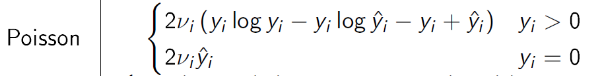

In this formula the weights (exposure) are represented by $$\nu_i $$ 

In [659]:
def Poisson_deviance (model, data) :
  y_hat = model.predict(data)
  y = data.nbrtotan
  weights = data.expo
  log_ratio = np.where(y == 0, 0, np.log(y / y_hat))
  deviance = 2 * sum(weights*(y* log_ratio - (y-y_hat)))
  return(deviance)

In [660]:
def generate_glm(init_formula, var, train_data, test_data, o_s, print_sum=True) :

  str_formula= init_formula + var
  #print("")
  #print("Univariate GLM for frequency in function of variable "+ var)
  #print("")
  model_formula= sm.formula.glm(str_formula, data = train_data, family=sm.families.Poisson(link=sm.families.links.log()), \
                              offset = train_data[o_s])
  model = model_formula.fit()
  #np.seterr(divide = 'ignore') 
  train_dev= Poisson_deviance(model, train_data)
  test_dev= Poisson_deviance(model, test_data)
  #np.seterr(divide = 'warn') 
  #freq_glm = smf.glm(formula=str_formula, data= mtpl, exposure = mtpl.expo, family = sm.families.Poisson(link=sm.families.links.log())).fit()
  #print(model.summary())
  if print_sum == True :
    print("")
    print("The AIC for the model '"+ str_formula + "' is "+str("%.3f" % model.aic))
    print("")
    print("The total Deviance for the model '"+ str_formula + "' is "+str("%.3f" % (train_dev + test_dev)) +", of which "+ str("%.3f" % test_dev) +" for the test set and " + str("%.3f" % model.deviance) + " for the training set")
    print("--- + --- + --- + --- + --- + --- + --- + --- + --- + ---") 
  return(model)

We then define a function that generates a univariate analysis of the features with respect to the frequency.

In [661]:
def MTPL_description_initial(var) :
  data = mtpl.groupby([mtpl[var]]).agg(tot_obs = ('nbrtotc', 'count'), tot_cln=('nbrtotc', 'sum'), tot_expo = ('expo', 'sum'), tot_cla=('chargtot', 'sum'))
  data.reset_index(inplace = True)
  data["freq"]=data.tot_cln/data.tot_expo #Frequency is total number of claims divided by total exposure for each value of "var"

  data_print = data.drop(columns=['tot_obs', 'tot_cln', 'tot_cla'])
  print('MTPL - Frequency and exposure for the different categories of variable '+ var)
  print("")
  print(data_print)

  plt.rcParams['figure.figsize'] = [20, 6]
  freq_plot=data.loc[:,[var,'freq','tot_expo']] #,'sev']]
  freq_plot[var]=freq_plot[var].astype("category")
  freq_plot.plot(kind='bar', secondary_y='tot_expo', rot=30)
  plt.xticks(range(freq_plot.shape[0]),list(freq_plot.iloc[:,0]), rotation=30)
  plt.title('MTPL - Frequency and exposure for the different categories of variable '+ var)
  plot=plt.show()

  init_formula='nbrtotc ~ '
  print("")
  print("Univariate GLM for frequency in function of variable "+ var)
  print("")
  freq_glm = generate_glm(init_formula, var, mtpl_train, mtpl_test, 'lnexpo', print_sum=True)
  print(freq_glm.summary())
  return(freq_glm)

In [662]:
def MTPL_description_initial_no_glm(var) :
  data = mtpl.groupby([mtpl[var]]).agg(tot_obs = ('nbrtotc', 'count'), tot_cln=('nbrtotc', 'sum'), tot_expo = ('expo', 'sum'), tot_cla=('chargtot', 'sum'))
  data.reset_index(inplace = True)
  data["freq"]=data.tot_cln/data.tot_expo #Frequency is total number of claims divided by total exposure for each value of "var"
  
  data_print = data.drop(columns=['tot_obs', 'tot_cln', 'tot_cla'])
  print('MTPL - Frequency and exposure for the different categories of variable '+ var)
  print("")
  print(data_print)

  plt.rcParams['figure.figsize'] = [20, 6]
  freq_plot=data.loc[:,[var,'freq','tot_expo']] #,'sev']]
  freq_plot[var]=freq_plot[var].astype("category")
  freq_plot.plot(kind='bar', secondary_y='tot_expo', rot=30)
  plt.xticks(range(freq_plot.shape[0]),list(freq_plot.iloc[:,0]), rotation=30)
  plt.title('MTPL - Frequency and exposure for the different categories of variable '+ var)
  plot=plt.show()

### 3.2.1 Categorical features with many possible values <a name="three-two-one"></a>

We will examine for those categorical features with many options whether some of the options must be binned. 

We check if it is appropriate to perform a binning of different potential categories for a specific variable, based on the test statistics for the test

$$ H_0 : \beta_{x}(i) = \beta_{x}(j) $$

for all pairs $(i,j)$ but only considering "adjacent" pairs. In order to do so we define a ```Wald_hypothesis()``` function :

In [663]:
def Wald_hypothesis(model,variable):

    params=pd.DataFrame(model.params)
    ##print(params)
    params_var=params.loc[np.array([s for s in params.index if variable in s])]
    #print("length params_var = "+str(len(params_var)))
    cov=model.cov_params()
    #print(cov)
    cov_var=cov.loc[np.array([s for s in cov.index if variable in s]),np.array([s for s in cov.columns if variable in s])]
    pd.DataFrame(cov_var).head(10)
    wald_matrix = np.array([[0.000 for j in range(len(params_var))] for i in range(len(params_var))])

    for i in range(len(params_var)):
        for j in range(len(params_var)):
            wald_matrix[i,j]=(params_var.iloc[i]-params_var.iloc[j])**2/(cov_var.iloc[i,i] - 2*cov_var.iloc[i,j] + cov_var.iloc[j,j])

    return(wald_matrix.round(3))


The output of our ```Wald_hypothesis()``` function is a table that show the test statistic of the Wald-test for the different potential gathering of  categories of `variable`.

We run this function on the univariate glm for the features with categories that can be "ordered" in a logical way to see if binning is required for some of the "neighbouring" categories.


#### 3.2.1.1 Analysis of the age buckets <a name="three-two-one-one"></a>

When looking at the population buckets, we see that there are some with very low exposure.

We also notice that there is indeed no systematic upward or downward trend of the frequency in function of increasing age. This justifies the treatment of the `age`- feature as a categorical feature instead of a numerical.

We now examine the potential aggregation of the categorical features `age_cat`containing the initial age buckets.

MTPL - Frequency and exposure for the different categories of variable age_cat

   age_cat      tot_expo      freq
0    18-20    441.890411  0.330399
1    21-23   2545.860274  0.261994
2    24-26   6644.221918  0.229071
3    27-29   8307.780822  0.194757
4    30-34  15634.994521  0.160345
5    35-39  16635.241096  0.142829
6    40-44  17168.515068  0.137403
7    45-49  17098.189041  0.139605
8    50-54  15475.208219  0.123682
9    55-59  11534.778082  0.120852
10   60-64  10503.328767  0.099778
11   65-69  10236.041096  0.100136
12   70-74   7528.646575  0.096033
13   75-79   4238.221918  0.096503
14   80-84   1217.463014  0.121564
15    >=85    409.347945  0.114817


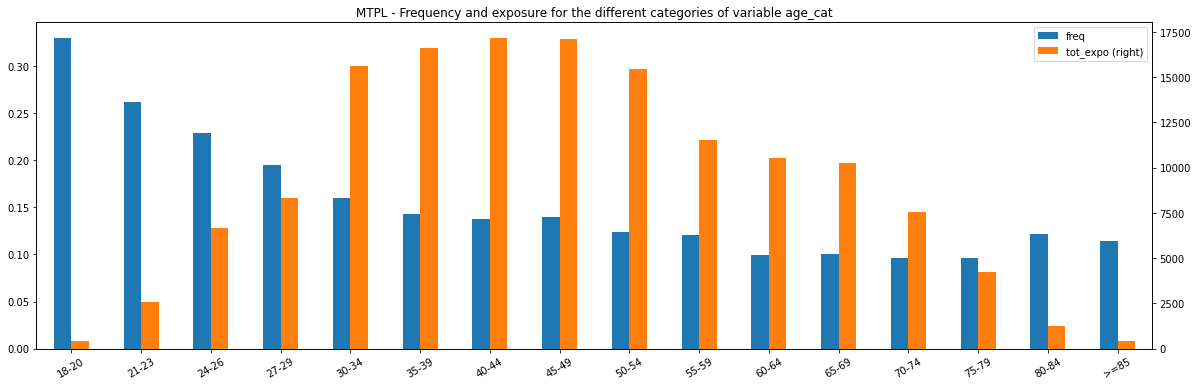


Univariate GLM for frequency in function of variable age_cat


The AIC for the model 'nbrtotc ~ age_cat' is 101463.443

The total Deviance for the model 'nbrtotc ~ age_cat' is 88854.026, of which 17690.723 for the test set and 71163.303 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130909
Model Family:                 Poisson   Df Model:                           15
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50716.
Date:                Sun, 16 Jan 2022   Deviance:                       71163.
Time:                        21:32:06   Pearson chi2:                 1.57e+05
No. Iterations:                     6              

In [664]:
glm_agecat0 = MTPL_description_initial('age_cat')

We notice that the Deviance of the model on the training data using our user-defined function `Poisson_deviance` is equal to the one calculated by the standard glm-model and included in the summary (`glm.deviance()`).

In [665]:
print("Deviance on training data by the standard model : "+ str(glm_agecat0.deviance))
print("Deviance on training data by our user-defined model : "+ str(Poisson_deviance(glm_agecat0, mtpl_train)))


Deviance on training data by the standard model : 71163.30267796192
Deviance on training data by our user-defined model : 71163.30267791856


We now start the analysis of the binning for this feature `age_cat`.

In [666]:
wald_table=Wald_hypothesis(glm_agecat0, 'age_cat')
#wald_table=pd.DataFrame(wald_table, 
#             columns=['21-23', '24-26', '27-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '>=85'])
#wald_table['age_cat']=['21-23', '24-26', '27-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '>=85']
#wald_table.set_index('age_cat')
index = ['21-23', '24-26', '27-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '>=85']
wald_table=pd.DataFrame(wald_table, 
             columns=['21-23', '24-26', '27-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '>=85'] ,
             index=index)
wald_table.head(wald_table.shape[0])

,21-23,24-26,27-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,>=85
21-23,NaN,8.587,37.801,104.451,154.854,189.544,177.972,224.742,217.095,303.675,300.149,296.157,198.422,54.366,21.517
24-26,8.587,NaN,16.608,88.961,152.890,198.482,183.341,241.976,223.469,324.889,319.891,301.476,179.786,37.930,14.449
27-29,37.801,16.608,NaN,25.688,65.766,98.169,87.021,133.368,125.695,213.290,209.540,204.623,117.526,19.440,7.904
30-34,104.451,88.961,25.688,NaN,12.169,30.867,23.836,56.796,55.264,129.043,126.122,128.700,67.182,6.218,2.967
35-39,154.854,152.890,65.766,12.169,NaN,4.335,1.946,17.641,19.413,73.600,71.633,79.870,39.467,1.606,1.088
40-44,189.544,198.482,98.169,30.867,4.335,NaN,0.479,4.794,6.633,47.394,45.934,55.743,26.153,0.270,0.395
45-49,177.972,183.341,87.021,23.836,1.946,0.479,NaN,8.195,10.170,55.630,54.002,63.431,30.329,0.592,0.588
50-54,224.742,241.976,133.368,56.796,17.641,4.794,8.195,NaN,0.314,24.213,23.290,33.105,14.314,0.094,0.028
55-59,217.095,223.469,125.695,55.264,19.413,6.633,10.170,0.314,NaN,17.141,16.445,25.517,10.945,0.290,0.001
60-64,303.675,324.889,213.290,129.043,73.600,47.394,55.630,24.213,17.141,NaN,0.004,1.694,0.070,6.358,1.214


The output of our ```Wald_hypothesis()``` function is a table that show the test statistic of the Wald-test for the different potential gathering of  categories of `variable`.

This statistic is chi²-distributed with one degree of freedom.

The 95% quantile value of the test statistic is 3.841, meaning that below this value the p-value is more than 5%. 

It means that if the test statistics is below 3.841, the difference in the parameters between 2 classes is not high enough to reject the hypothese that the true effect of the two classes are the same, in which case we can gather the 2 classes. 

Based on these results, we would first bin together the categories "60-64" and "65-69" - which are the categories with the lowest Wald test statistic - into a category "60-69". 

However, from the summary of the GLM "nbrtotc ~ age_cat", based on the P-value for the comparisons of the bèta's of the different categories against the reference category ("18-20") it shows that the neighbouring categories "18-20" and "21-23" are to be binned as well.

How to know which must be binned first? We'll compare all the P-values of the different tests.

We therefore adjust the above matrix to represent the P-values and include the P-value for all the categories against the reference category.

In [667]:
def Wald_hypothesis2(model,variable):

    params=pd.DataFrame(model.params)
    params_var=params.loc[np.array([s for s in params.index if variable in s])]
    cov=model.cov_params()
    cov_var=cov.loc[np.array([s for s in cov.index if variable in s]),np.array([s for s in cov.columns if variable in s])]
    #pd.DataFrame(cov_var).head(10)
    wald_matrix = np.array([[0.000 for j in range(len(params_var))] for i in range(len(params_var))])

    for i in range(len(params_var)):
        for j in range(len(params_var)):
            wald_matrix[i,j]=(params_var.iloc[i]-params_var.iloc[j])**2/(cov_var.iloc[i,i] - 2*cov_var.iloc[i,j] + cov_var.iloc[j,j])

    #return(wald_matrix.round(3))
    
    wald_table=pd.DataFrame(wald_matrix)
    p_values=pd.DataFrame(model.pvalues).tail(wald_table.shape[0])
    #df_pval=p_values.tail(wald_table.shape[0])
    #print(wald_table.shape[0])
    pvalue_matrix = np.array([[0.000 for j in range(0,wald_table.shape[0]+1)] for i in range(0,wald_table.shape[0]+1)])
    #pd.DataFrame(matrix).head(wald_table.shape[0]+1)
    
    d_o_f = 1 #The Wald test for the pairs of bèta's has 1 degree of freedom
    for i in range(0,wald_table.shape[0]+1):
      for j in range(0,wald_table.shape[0]+1):
        if i == j :
          pvalue_matrix[i][j] = 0 #str("%.4f" % 0)
        elif i == 0 :
          pvalue_matrix[i][j] = p_values.iloc[j-1][0] #str("%.4f" % p_values.iloc[j-1][0])
        elif j == 0 :
          pvalue_matrix[i][j] = p_values.iloc[i-1][0] #str("%.4f" % p_values.iloc[i-1][0])
        else:
          pvalue_matrix[i][j] = 1-chi2.cdf(wald_table.iloc[i-1][j-1], d_o_f) #str("%.4f" % (1-chi2.cdf(wald_table.iloc[i-1][j-1], d_o_f)) )
    
    return(pvalue_matrix.round(3))


In [668]:
wald_table_pvalue=Wald_hypothesis2(glm_agecat0, 'age_cat')
index = ['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '>=85']
wald_table_pvalue=pd.DataFrame(wald_table_pvalue, 
             columns=['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '>=85'] ,
             index=index)
#wald_table_pvalue['age_cat']=['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '>=85']
#wald_table_pvalue.set_index('age_cat')
wald_table_pvalue.head(wald_table.shape[0])

,18-20,21-23,24-26,27-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,>=85
18-20,0.000,0.187,0.004,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
21-23,0.187,0.000,0.003,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
24-26,0.004,0.003,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
27-29,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.005
30-34,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.013,0.085
35-39,0.000,0.000,0.000,0.0,0.000,0.000,0.037,0.163,0.000,0.000,0.000,0.000,0.000,0.000,0.205,0.297
40-44,0.000,0.000,0.000,0.0,0.000,0.037,0.000,0.489,0.029,0.010,0.000,0.000,0.000,0.000,0.603,0.530
45-49,0.000,0.000,0.000,0.0,0.000,0.163,0.489,0.000,0.004,0.001,0.000,0.000,0.000,0.000,0.442,0.443
50-54,0.000,0.000,0.000,0.0,0.000,0.000,0.029,0.004,0.000,0.575,0.000,0.000,0.000,0.000,0.759,0.867
55-59,0.000,0.000,0.000,0.0,0.000,0.000,0.010,0.001,0.575,0.000,0.000,0.000,0.000,0.001,0.590,0.973


We obtain a nice matrix with all the p-values for easy comparison.

Based on these results - concentrating on the values just next to the diagonal, where we find the results for the consequent categories - we will first bin together the categories "60-64" and "65-69" - which are the categories with the lowest Wald test statistic - into a category "60-69".

We count the observations to be sure that none go missing in the operation of binning.

In [669]:
mtpl["age_cat"].value_counts()

40-44    19495
35-39    19186
45-49    19162
30-34    18179
50-54    17176
55-59    12800
60-64    11497
65-69    11049
27-29     9596
70-74     8018
24-26     7657
75-79     4490
21-23     3037
80-84     1318
18-20      528
>=85       469
Name: age_cat, dtype: int64

In [670]:
mtpl_age_cat1=mtpl.copy()
mtpl_train1=mtpl_train.copy()
mtpl_test1=mtpl_test.copy()

mtpl_age_cat1["age_cat"]=mtpl_age_cat1["age_cat"].replace(['60-64','65-69'],'60-69')
mtpl_train1["age_cat"]=mtpl_train1["age_cat"].replace(['60-64','65-69'],'60-69')
mtpl_test1["age_cat"]=mtpl_test1["age_cat"].replace(['60-64','65-69'],'60-69')
mtpl_age_cat1["age_cat"].value_counts()

60-69    22546
40-44    19495
35-39    19186
45-49    19162
30-34    18179
50-54    17176
55-59    12800
27-29     9596
70-74     8018
24-26     7657
75-79     4490
21-23     3037
80-84     1318
18-20      528
>=85       469
Name: age_cat, dtype: int64

We rerun a glm to see if this binning actually gave better results, based on the AIC (Is it lowering?) and the Deviance (Is it lowering?)

If the AIC and Deviance are lower, the model has improved. If the AIC or Deviance slightly increases, we will still continue with the binned categories, as this leads to a somewhat less complex model.

In [671]:
glm_age_cat1 = generate_glm('nbrtotc ~ ', 'age_cat', mtpl_train1, mtpl_test1, 'lnexpo')
print(glm_age_cat1.summary())

wald_table=Wald_hypothesis2(glm_age_cat1, 'age_cat')
index = ['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-69', '70-74', '75-79', '80-84', '>=85']
wald_table=pd.DataFrame(wald_table, 
             columns=['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-69', '70-74', '75-79', '80-84', '>=85'],
             index = index)
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ age_cat' is 101461.447

The total Deviance for the model 'nbrtotc ~ age_cat' is 88854.033, of which 17690.726 for the test set and 71163.307 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130910
Model Family:                 Poisson   Df Model:                           14
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50716.
Date:                Sun, 16 Jan 2022   Deviance:                       71163.
Time:                        21:32:08   Pearson chi2:                 1.57e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobu

,18-20,21-23,24-26,27-29,30-34,35-39,40-44,45-49,50-54,55-59,60-69,70-74,75-79,80-84,>=85
18-20,0.000,0.187,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
21-23,0.187,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
24-26,0.004,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
27-29,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.005
30-34,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.013,0.085
35-39,0.000,0.000,0.000,0.000,0.000,0.000,0.037,0.163,0.000,0.000,0.000,0.000,0.000,0.205,0.297
40-44,0.000,0.000,0.000,0.000,0.000,0.037,0.000,0.489,0.029,0.010,0.000,0.000,0.000,0.603,0.530
45-49,0.000,0.000,0.000,0.000,0.000,0.163,0.489,0.000,0.004,0.001,0.000,0.000,0.000,0.442,0.443
50-54,0.000,0.000,0.000,0.000,0.000,0.000,0.029,0.004,0.000,0.575,0.000,0.000,0.000,0.759,0.867
55-59,0.000,0.000,0.000,0.000,0.000,0.000,0.010,0.001,0.575,0.000,0.000,0.000,0.001,0.590,0.973


We continue this procedure of binning the categories, based on the highest p-value for two neighbouring categories in the above table.

Next ones to be binned are "80-84" and ">=85" (p-value : 0.7630).

In [672]:
mtpl_age_cat2=mtpl_age_cat1.copy()
mtpl_train2=mtpl_train1.copy()
mtpl_test2=mtpl_test1.copy()

mtpl_age_cat2["age_cat"]=mtpl_age_cat2["age_cat"].replace(['80-84','>=85'],'>=80')
mtpl_train2["age_cat"]=mtpl_train2["age_cat"].replace(['80-84','>=85'],'>=80')
mtpl_test2["age_cat"]=mtpl_test2["age_cat"].replace(['80-84','>=85'],'>=80')

glm_age_cat2 = generate_glm('nbrtotc ~', 'age_cat', mtpl_train2, mtpl_test2, 'lnexpo')
#print(glm_age_cat2.summary())
wald_table=Wald_hypothesis2(glm_age_cat2, 'age_cat')
index = ['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-69', '70-74', '75-79', '>=80']
wald_table=pd.DataFrame(wald_table, 
             columns=['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-69', '70-74', '75-79', '>=80'],
             index = index)
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~age_cat' is 101459.539

The total Deviance for the model 'nbrtotc ~age_cat' is 88854.168, of which 17690.769 for the test set and 71163.399 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,18-20,21-23,24-26,27-29,30-34,35-39,40-44,45-49,50-54,55-59,60-69,70-74,75-79,>=80
18-20,0.000,0.187,0.004,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
21-23,0.187,0.000,0.003,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
24-26,0.004,0.003,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
27-29,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
30-34,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003
35-39,0.000,0.000,0.000,0.0,0.000,0.000,0.037,0.163,0.000,0.000,0.000,0.000,0.000,0.112
40-44,0.000,0.000,0.000,0.0,0.000,0.037,0.000,0.489,0.029,0.010,0.000,0.000,0.000,0.456
45-49,0.000,0.000,0.000,0.0,0.000,0.163,0.489,0.000,0.004,0.001,0.000,0.000,0.000,0.304
50-54,0.000,0.000,0.000,0.0,0.000,0.000,0.029,0.004,0.000,0.575,0.000,0.000,0.000,0.852
55-59,0.000,0.000,0.000,0.0,0.000,0.000,0.010,0.001,0.575,0.000,0.000,0.000,0.001,0.654


In [673]:
mtpl_age_cat3=mtpl_age_cat2.copy()
mtpl_train3=mtpl_train2.copy()
mtpl_test3=mtpl_test2.copy()

mtpl_age_cat3["age_cat"]=mtpl_age_cat3["age_cat"].replace(['50-54','55-59'],'50-59')
mtpl_train3["age_cat"]=mtpl_train3["age_cat"].replace(['50-54','55-59'],'50-59')
mtpl_test3["age_cat"]=mtpl_test3["age_cat"].replace(['50-54','55-59'],'50-59')

glm_age_cat3 = generate_glm('nbrtotc ~', 'age_cat', mtpl_train3, mtpl_test3, 'lnexpo')
#print(glm_age_cat3.summary())

wald_table=Wald_hypothesis2(glm_age_cat3, 'age_cat')
index = ['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-44', '45-49', '50-59', '60-69', '70-74', '75-79', '>=80']
wald_table=pd.DataFrame(wald_table, 
             columns=['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-44', '45-49', '50-59', '60-69', '70-74', '75-79', '>=80'],
             index = index)
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~age_cat' is 101457.853

The total Deviance for the model 'nbrtotc ~age_cat' is 88854.600, of which 17690.888 for the test set and 71163.713 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,18-20,21-23,24-26,27-29,30-34,35-39,40-44,45-49,50-59,60-69,70-74,75-79,>=80
18-20,0.000,0.187,0.004,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
21-23,0.187,0.000,0.003,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
24-26,0.004,0.003,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
27-29,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
30-34,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003
35-39,0.000,0.000,0.000,0.0,0.000,0.000,0.037,0.163,0.000,0.000,0.000,0.000,0.112
40-44,0.000,0.000,0.000,0.0,0.000,0.037,0.000,0.489,0.005,0.000,0.000,0.000,0.456
45-49,0.000,0.000,0.000,0.0,0.000,0.163,0.489,0.000,0.000,0.000,0.000,0.000,0.304
50-59,0.000,0.000,0.000,0.0,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.000,0.759
60-69,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.136,0.755,0.006


In [674]:
mtpl_age_cat4=mtpl_age_cat3.copy()
mtpl_train4=mtpl_train3.copy()
mtpl_test4=mtpl_test3.copy()

mtpl_age_cat4["age_cat"]=mtpl_age_cat4["age_cat"].replace(['40-44','45-49'],'40-49')
mtpl_train4["age_cat"]=mtpl_train4["age_cat"].replace(['40-44','45-49'],'40-49')
mtpl_test4["age_cat"]=mtpl_test4["age_cat"].replace(['40-44','45-49'],'40-49')

glm_age_cat4 = generate_glm('nbrtotc ~', 'age_cat', mtpl_train4, mtpl_test4, 'lnexpo')
#print(glm_age_cat4.summary())

wald_table=Wald_hypothesis2(glm_age_cat4, 'age_cat')
index = ['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-49', '50-59', '60-69', '70-74', '75-79', '>=80']
wald_table=pd.DataFrame(wald_table, 
             columns=['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-49', '50-59', '60-69', '70-74', '75-79', '>=80'],
             index = index)
#wald_table['age_cat']=['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-49', '50-59', '60-69', '70-74', '75-79', '>=80']
#wald_table.set_index('age_cat')
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~age_cat' is 101456.332

The total Deviance for the model 'nbrtotc ~age_cat' is 88854.842, of which 17690.650 for the test set and 71164.192 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,18-20,21-23,24-26,27-29,30-34,35-39,40-49,50-59,60-69,70-74,75-79,>=80
18-20,0.000,0.187,0.004,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
21-23,0.187,0.000,0.003,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
24-26,0.004,0.003,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
27-29,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
30-34,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003
35-39,0.000,0.000,0.000,0.0,0.000,0.000,0.044,0.000,0.000,0.000,0.000,0.112
40-49,0.000,0.000,0.000,0.0,0.000,0.044,0.000,0.000,0.000,0.000,0.000,0.365
50-59,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.759
60-69,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.136,0.755,0.006
70-74,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.136,0.000,0.438,0.001


In [675]:
mtpl_age_cat5=mtpl_age_cat4.copy()
mtpl_train5=mtpl_train4.copy()
mtpl_test5=mtpl_test4.copy()

mtpl_age_cat5["age_cat"]=mtpl_age_cat5["age_cat"].replace(['70-74','75-79'],'70-79')
mtpl_train5["age_cat"]=mtpl_train5["age_cat"].replace(['70-74','75-79'],'70-79')
mtpl_test5["age_cat"]=mtpl_test5["age_cat"].replace(['70-74','75-79'],'70-79')

glm_age_cat5 = generate_glm('nbrtotc ~', 'age_cat', mtpl_train5, mtpl_test5, 'lnexpo')
#print(glm_age_cat5.summary())

wald_table=Wald_hypothesis2(glm_age_cat5, 'age_cat')
index = ['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-49', '50-59', '60-69', '70-79', '>=80']
wald_table=pd.DataFrame(wald_table, 
             columns=['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-49', '50-59', '60-69', '70-79', '>=80'],
             index = index)
#wald_table['age_cat']=['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-49', '50-59', '60-69', '70-79', '>=80']
#wald_table.set_index('age_cat')
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~age_cat' is 101454.931

The total Deviance for the model 'nbrtotc ~age_cat' is 88854.237, of which 17689.445 for the test set and 71164.791 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,18-20,21-23,24-26,27-29,30-34,35-39,40-49,50-59,60-69,70-79,>=80
18-20,0.000,0.187,0.004,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
21-23,0.187,0.000,0.003,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
24-26,0.004,0.003,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
27-29,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
30-34,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.003
35-39,0.000,0.000,0.000,0.0,0.000,0.000,0.044,0.000,0.000,0.000,0.112
40-49,0.000,0.000,0.000,0.0,0.000,0.044,0.000,0.000,0.000,0.000,0.365
50-59,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.759
60-69,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.201,0.006
70-79,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.201,0.000,0.001


In [676]:
mtpl_age_cat6=mtpl_age_cat5.copy()
mtpl_train6=mtpl_train5.copy()
mtpl_test6=mtpl_test5.copy()

mtpl_age_cat6["age_cat"]=mtpl_age_cat6["age_cat"].replace(['60-69','70-79'],'60-79')
mtpl_train6["age_cat"]=mtpl_train6["age_cat"].replace(['60-69','70-79'],'60-79')
mtpl_test6["age_cat"]=mtpl_test6["age_cat"].replace(['60-69','70-79'],'60-79')


glm_age_cat6 = generate_glm('nbrtotc ~ ', 'age_cat', mtpl_train6, mtpl_test6, 'lnexpo')
#print(glm_age_cat6.summary())

wald_table=Wald_hypothesis2(glm_age_cat6, 'age_cat')
index = ['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-49', '50-59', '60-79', '>=80']
wald_table=pd.DataFrame(wald_table, 
             columns=['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-49', '50-59', '60-79', '>=80'],
             index = index)
#wald_table['age_cat']=['18-20', '21-23', '24-26', '27-29', '30-34', '35-39', '40-49', '50-59', '60-79', '>=80']
#wald_table.set_index('age_cat')
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ age_cat' is 101454.574

The total Deviance for the model 'nbrtotc ~ age_cat' is 88855.158, of which 17688.723 for the test set and 71166.435 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,18-20,21-23,24-26,27-29,30-34,35-39,40-49,50-59,60-79,>=80
18-20,0.000,0.187,0.004,0.0,0.000,0.000,0.000,0.000,0.000,0.000
21-23,0.187,0.000,0.003,0.0,0.000,0.000,0.000,0.000,0.000,0.000
24-26,0.004,0.003,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000
27-29,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000
30-34,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.003
35-39,0.000,0.000,0.000,0.0,0.000,0.000,0.044,0.000,0.000,0.112
40-49,0.000,0.000,0.000,0.0,0.000,0.044,0.000,0.000,0.000,0.365
50-59,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.759
60-79,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.002
>=80,0.000,0.000,0.000,0.0,0.003,0.112,0.365,0.759,0.002,0.000


We finally bin the first two categories and end up with 9 age buckets.

In [677]:
mtpl_age_cat7=mtpl_age_cat6.copy()
mtpl_train7=mtpl_train6.copy()
mtpl_test7=mtpl_test6.copy()

mtpl_age_cat7["age_cat"]=mtpl_age_cat7["age_cat"].replace(['18-20','21-23'],'18-23')
mtpl_train7["age_cat"]=mtpl_train7["age_cat"].replace(['18-20','21-23'],'18-23')
mtpl_test7["age_cat"]=mtpl_test7["age_cat"].replace(['18-20','21-23'],'18-23')

glm_age_cat7 = generate_glm('nbrtotc ~ ', 'age_cat', mtpl_train7, mtpl_test7, 'lnexpo')
#print(glm_age_cat7.summary())

wald_table=Wald_hypothesis2(glm_age_cat7, 'age_cat')
index = ['18-23', '24-26', '27-29', '30-34', '35-39', '40-49', '50-59', '60-79', '>=80']
wald_table=pd.DataFrame(wald_table, 
             columns=['18-23', '24-26', '27-29', '30-34', '35-39', '40-49', '50-59', '60-79', '>=80'],
             index = index)
#wald_table['age_cat']=['18-23', '24-26', '27-29', '30-34', '35-39', '40-49', '50-59', '60-79', '>=80']
#wald_table.set_index('age_cat')
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ age_cat' is 101454.264

The total Deviance for the model 'nbrtotc ~ age_cat' is 88860.318, of which 17692.194 for the test set and 71168.124 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,18-23,24-26,27-29,30-34,35-39,40-49,50-59,60-79,>=80
18-23,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
24-26,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
27-29,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
30-34,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.003
35-39,0.0,0.0,0.0,0.000,0.000,0.044,0.000,0.000,0.112
40-49,0.0,0.0,0.0,0.000,0.044,0.000,0.000,0.000,0.365
50-59,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.759
60-79,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.002
>=80,0.0,0.0,0.0,0.003,0.112,0.365,0.759,0.002,0.000


We assess the evolution of the model performance over the different binning steps.

In [678]:
def assess_model_evolution(var, steps):
  data=[]
  for c in range(1, steps+1, 1) :
    model_name = 'glm_'+var+str(c)
    model = eval(model_name)
    test_set = eval('mtpl_test'+str(c))
    train_set = eval('mtpl_train'+str(c))
    pred_test = model.predict(test_set)
    pred_train = model.predict(train_set)
    dev_test = Poisson_deviance(model, test_set)
    dev_train = Poisson_deviance(model, train_set)
    data.append([c, model_name, model.aic, dev_train + dev_test, model.deviance, dev_test])
  
  summary=pd.DataFrame(data, columns=['Step', 'Model', 'AIC', 'Total Deviance', 'Deviance_Train', 'Deviance_Test'])
  summary.head(summary.shape[0]).round(3) 
  return(summary)

In [679]:
overview = assess_model_evolution('age_cat', 7)
overview.head(overview.shape[0])

,Step,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,1,glm_age_cat1,101461.446890,88854.032754,71163.306923,17690.725831
1,2,glm_age_cat2,101459.538537,88854.167788,71163.398570,17690.769218
2,3,glm_age_cat3,101457.852737,88854.600438,71163.712769,17690.887669
3,4,glm_age_cat4,101456.331565,88854.841826,71164.191598,17690.650228
4,5,glm_age_cat5,101454.931195,88854.236695,71164.791228,17689.445467
5,6,glm_age_cat6,101454.574492,88855.158007,71166.434525,17688.723483
6,7,glm_age_cat7,101454.263854,88860.317673,71168.123887,17692.193786


Our final choice is then to go with 6 steps of binning for the `age_cat` variable, preferring less model complexity over a slightly higher total model Deviance, but the lowest on the test set.

In [680]:
mtpl = mtpl_age_cat6
mtpl_train = mtpl_train6
mtpl_test = mtpl_test6
mtpl.age_cat.value_counts()

40-49    38657
60-79    35054
50-59    29976
35-39    19186
30-34    18179
27-29     9596
24-26     7657
21-23     3037
>=80      1787
18-20      528
Name: age_cat, dtype: int64

#### 3.2.1.2 Analysis of the population buckets <a name="three-two-one-one"></a>

When looking at the population buckets, we see that there are some with very low exposure.

We examine the potential grouping of the population buckets in the variable `pop_bucket`. This is to see if a better repartition of buckets can be found than the predefined categories in the `city_size` variable.

MTPL - Frequency and exposure for the different categories of variable pop_bucket

   pop_bucket      tot_expo      freq
0        000K   3559.643836  0.111247
1        010K  36971.336986  0.120932
2        020K  31910.013699  0.132560
3        030K  22426.690411  0.136222
4        040K   9899.030137  0.142741
5        050K   2437.802740  0.210846
6        060K   3974.145205  0.151982
7        070K   3211.323288  0.138572
8        080K   7671.515068  0.136870
9        090K   2320.197260  0.175847
10       100K   1939.065753  0.188235
11      105+K  19298.964384  0.173014


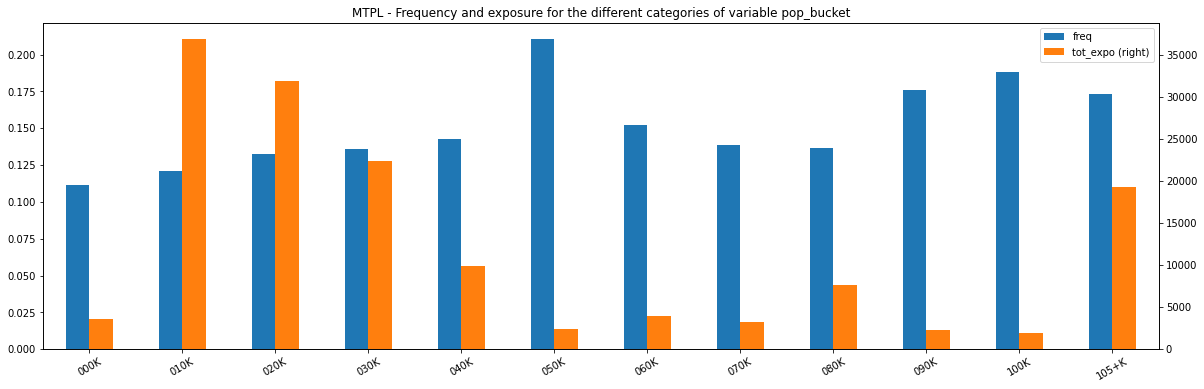


Univariate GLM for frequency in function of variable pop_bucket


The AIC for the model 'nbrtotc ~ pop_bucket' is 102166.890

The total Deviance for the model 'nbrtotc ~ pop_bucket' is 89775.939, of which 17901.189 for the test set and 71874.750 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130913
Model Family:                 Poisson   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51071.
Date:                Sun, 16 Jan 2022   Deviance:                       71875.
Time:                        21:32:16   Pearson chi2:                 1.60e+05
No. Iterations:                     6     

In [681]:
glm_pop_bucket1= MTPL_description_initial('pop_bucket')

We then check the `Wald_hypothesis` test performed on the variable `pop_bucket`.

In [682]:
wald_table=Wald_hypothesis2(glm_pop_bucket1, 'pop_bucket')
index=['000K', '010K', '020K', '030K', '040K', '050K', '060K', '070K', '080K', '090K', '100K', '105+K']
wald_table=pd.DataFrame(wald_table, 
             columns=['000K', '010K', '020K', '030K', '040K', '050K', '060K', '070K', '080K', '090K', '100K', '105+K'], 
             index = index)
wald_table.head(wald_table.shape[0])

,000K,010K,020K,030K,040K,050K,060K,070K,080K,090K,100K,105+K
000K,0.000,0.072,0.001,0.001,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000
010K,0.072,0.000,0.000,0.000,0.000,0.000,0.000,0.016,0.000,0.000,0.000,0.000
020K,0.001,0.000,0.000,0.681,0.317,0.000,0.046,0.454,0.266,0.000,0.000,0.000
030K,0.001,0.000,0.681,0.000,0.512,0.000,0.084,0.589,0.427,0.000,0.000,0.000
040K,0.000,0.000,0.317,0.512,0.000,0.000,0.252,0.913,0.866,0.000,0.000,0.000
050K,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.012,0.263,0.000
060K,0.000,0.000,0.046,0.084,0.252,0.000,0.000,0.419,0.334,0.012,0.000,0.004
070K,0.002,0.016,0.454,0.589,0.913,0.000,0.419,0.000,0.986,0.002,0.000,0.000
080K,0.000,0.000,0.266,0.427,0.866,0.000,0.334,0.986,0.000,0.000,0.000,0.000
090K,0.000,0.000,0.000,0.000,0.000,0.012,0.012,0.002,0.000,0.000,0.205,0.546


Based on these results, we first bin the following categories "070K" and "080K" into "070_080K"



In [683]:
mtpl.pop_bucket.value_counts()

010K     41376
020K     35747
030K     25116
105+K    21964
040K     11104
080K      8474
060K      4536
000K      4025
070K      3546
050K      2889
090K      2681
100K      2199
Name: pop_bucket, dtype: int64

In [684]:
mtpl2 = mtpl.copy()
mtpl_train2 = mtpl_train.copy()
mtpl_test2=mtpl_test.copy()
mtpl2["pop_bucket"]=mtpl2["pop_bucket"].replace(['070K','080K'], '070_080K')
mtpl_train2["pop_bucket"]=mtpl_train2["pop_bucket"].replace(['070K','080K'], '070_080K')
mtpl_test2["pop_bucket"]=mtpl_test2["pop_bucket"].replace(['070K','080K'], '070_080K')
mtpl2.pop_bucket.value_counts()

010K        41376
020K        35747
030K        25116
105+K       21964
070_080K    12020
040K        11104
060K         4536
000K         4025
050K         2889
090K         2681
100K         2199
Name: pop_bucket, dtype: int64

In [685]:
glm_pop_bucket2 = generate_glm('nbrtotc ~', 'pop_bucket', mtpl_train2, mtpl_test2, 'lnexpo')

wald_table=Wald_hypothesis2(glm_pop_bucket2, 'pop_bucket')
index=['000K', '010K', '020K', '030K', '040K', '050K', '060K', '070_080K', '090K', '100K', '105+K']
wald_table=pd.DataFrame(wald_table, 
             columns=['000K', '010K', '020K', '030K', '040K', '050K', '060K', '070_080K', '090K', '100K', '105+K'],
             index = index)

wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~pop_bucket' is 102164.890

The total Deviance for the model 'nbrtotc ~pop_bucket' is 89775.930, of which 17901.180 for the test set and 71874.750 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,000K,010K,020K,030K,040K,050K,060K,070_080K,090K,100K,105+K
000K,0.000,0.072,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000
010K,0.072,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
020K,0.001,0.000,0.000,0.681,0.317,0.000,0.046,0.207,0.000,0.000,0.000
030K,0.001,0.000,0.681,0.000,0.512,0.000,0.084,0.374,0.000,0.000,0.000
040K,0.000,0.000,0.317,0.512,0.000,0.000,0.252,0.859,0.000,0.000,0.000
050K,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.012,0.263,0.000
060K,0.000,0.000,0.046,0.084,0.252,0.000,0.000,0.304,0.012,0.000,0.004
070_080K,0.000,0.000,0.207,0.374,0.859,0.000,0.304,0.000,0.000,0.000,0.000
090K,0.000,0.000,0.000,0.000,0.000,0.012,0.012,0.000,0.000,0.205,0.546
100K,0.000,0.000,0.000,0.000,0.000,0.263,0.000,0.000,0.205,0.000,0.025


We further bin categories "020K" and "030K".

In [686]:
mtpl3 = mtpl2.copy()
mtpl_train3 = mtpl_train2.copy()
mtpl_test3=mtpl_test2.copy()
mtpl3["pop_bucket"]=mtpl3["pop_bucket"].replace(['030K', '020K'], '020_030K')
mtpl_train3["pop_bucket"]=mtpl_train3["pop_bucket"].replace(['030K', '020K'], '020_030K')
mtpl_test3["pop_bucket"]=mtpl_test3["pop_bucket"].replace(['030K', '020K'], '020_030K')
#mtpl.pop_bucket.value_counts()

In [687]:
glm_pop_bucket3 = generate_glm('nbrtotc ~ ', 'pop_bucket', mtpl_train3, mtpl_test3, 'lnexpo')
wald_table=Wald_hypothesis2(glm_pop_bucket3,'pop_bucket')
index=['000K', '010K', '020_030K', '040K', '050K', '060K', '070_080K', '090K', '100K', '105+K']
wald_table=pd.DataFrame(wald_table, 
             columns= ['000K', '010K', '020_030K', '040K', '050K', '060K', '070_080K', '090K', '100K', '105+K'],
             index=index)
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ pop_bucket' is 102163.059

The total Deviance for the model 'nbrtotc ~ pop_bucket' is 89776.771, of which 17901.853 for the test set and 71874.919 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,000K,010K,020_030K,040K,050K,060K,070_080K,090K,100K,105+K
000K,0.000,0.072,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000
010K,0.072,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
020_030K,0.001,0.000,0.000,0.358,0.000,0.051,0.232,0.000,0.000,0.000
040K,0.000,0.000,0.358,0.000,0.000,0.252,0.859,0.000,0.000,0.000
050K,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.012,0.263,0.000
060K,0.000,0.000,0.051,0.252,0.000,0.000,0.304,0.012,0.000,0.004
070_080K,0.000,0.000,0.232,0.859,0.000,0.304,0.000,0.000,0.000,0.000
090K,0.000,0.000,0.000,0.000,0.012,0.012,0.000,0.000,0.205,0.546
100K,0.000,0.000,0.000,0.000,0.263,0.000,0.000,0.205,0.000,0.025
105+K,0.000,0.000,0.000,0.000,0.000,0.004,0.000,0.546,0.025,0.000


In [688]:
mtpl4 = mtpl3.copy()
mtpl_train4 = mtpl_train3.copy()
mtpl_test4=mtpl_test3.copy()

mtpl4["pop_bucket"]=mtpl4["pop_bucket"].replace(['020_030K','040K'], '020_040K')
mtpl_train4["pop_bucket"]=mtpl_train4["pop_bucket"].replace(['020_030K','040K'], '020_040K')
mtpl_test4["pop_bucket"]=mtpl_test4["pop_bucket"].replace(['020_030K','040K'], '020_040K')
#mtpl4.pop_bucket.value_counts()

In [689]:
glm_pop_bucket4 = generate_glm('nbrtotc ~ ', 'pop_bucket', mtpl_train4, mtpl_test4, 'lnexpo')
wald_table=Wald_hypothesis2(glm_pop_bucket4,'pop_bucket')
index=['000K', '010K', '020_040K', '050K', '060K', '070_080K', '090K', '100K', '105+K']
wald_table=pd.DataFrame(wald_table, 
             columns= ['000K', '010K', '020_040K', '050K', '060K', '070_080K', '090K', '100K', '105+K'],
             index=index)

wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ pop_bucket' is 102161.897

The total Deviance for the model 'nbrtotc ~ pop_bucket' is 89780.118, of which 17904.361 for the test set and 71875.757 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,000K,010K,020_040K,050K,060K,070_080K,090K,100K,105+K
000K,0.000,0.072,0.000,0.000,0.000,0.000,0.000,0.000,0.000
010K,0.072,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
020_040K,0.000,0.000,0.000,0.000,0.063,0.289,0.000,0.000,0.000
050K,0.000,0.000,0.000,0.000,0.000,0.000,0.012,0.263,0.000
060K,0.000,0.000,0.063,0.000,0.000,0.304,0.012,0.000,0.004
070_080K,0.000,0.000,0.289,0.000,0.304,0.000,0.000,0.000,0.000
090K,0.000,0.000,0.000,0.012,0.012,0.000,0.000,0.205,0.546
100K,0.000,0.000,0.000,0.263,0.000,0.000,0.205,0.000,0.025
105+K,0.000,0.000,0.000,0.000,0.004,0.000,0.546,0.025,0.000


In [690]:
mtpl5 = mtpl4.copy()
mtpl_train5 = mtpl_train4.copy()
mtpl_test5=mtpl_test4.copy()

mtpl5["pop_bucket"]=mtpl5["pop_bucket"].replace(['070_080K','060K'], '060_080K')
mtpl_train5["pop_bucket"]=mtpl_train5["pop_bucket"].replace(['070_080K','060K'], '060_080K')
mtpl_test5["pop_bucket"]=mtpl_test5["pop_bucket"].replace(['070_080K','060K'], '060_080K')
#mtpl5.pop_bucket.value_counts()

In [691]:
glm_pop_bucket5 = generate_glm('nbrtotc ~ ', 'pop_bucket', mtpl_train5, mtpl_test5, 'lnexpo')
wald_table=Wald_hypothesis2(glm_pop_bucket5,'pop_bucket')
index=['000K', '010K', '020_040K', '050K', '060_080K', '090K', '100K', '105+K']
wald_table=pd.DataFrame(wald_table, 
             columns= ['000K', '010K', '020_040K', '050K', '060_080K', '090K', '100K', '105+K'],
             index=index)

wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ pop_bucket' is 102160.943

The total Deviance for the model 'nbrtotc ~ pop_bucket' is 89783.568, of which 17906.766 for the test set and 71876.803 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,000K,010K,020_040K,050K,060_080K,090K,100K,105+K
000K,0.000,0.072,0.000,0.000,0.000,0.000,0.000,0.000
010K,0.072,0.000,0.000,0.000,0.000,0.000,0.000,0.000
020_040K,0.000,0.000,0.000,0.000,0.076,0.000,0.000,0.000
050K,0.000,0.000,0.000,0.000,0.000,0.012,0.263,0.000
060_080K,0.000,0.000,0.076,0.000,0.000,0.000,0.000,0.000
090K,0.000,0.000,0.000,0.012,0.000,0.000,0.205,0.546
100K,0.000,0.000,0.000,0.263,0.000,0.205,0.000,0.025
105+K,0.000,0.000,0.000,0.000,0.000,0.546,0.025,0.000


In [692]:
mtpl6 = mtpl5.copy()
mtpl_train6 = mtpl_train5.copy()
mtpl_test6=mtpl_test5.copy()

mtpl6["pop_bucket"]=mtpl6["pop_bucket"].replace(['090K','100K'], '090_100K')
mtpl_train6["pop_bucket"]=mtpl_train6["pop_bucket"].replace(['090K','100K'], '090_100K')
mtpl_test6["pop_bucket"]=mtpl_test6["pop_bucket"].replace(['090K','100K'], '090_100K')
#mtpl6.pop_bucket.value_counts()

In [693]:
glm_pop_bucket6 = generate_glm('nbrtotc ~ ', 'pop_bucket', mtpl_train6, mtpl_train6, 'lnexpo')
wald_table=Wald_hypothesis2(glm_pop_bucket6,'pop_bucket')
index=['000K', '010K', '020_040K', '050K', '060_080K', '090_100K', '105+K']
wald_table=pd.DataFrame(wald_table, 
             columns= ['000K', '010K', '020_040K', '050K', '060_080K', '090_100K', '105+K'],
             index=index)
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ pop_bucket' is 102160.545

The total Deviance for the model 'nbrtotc ~ pop_bucket' is 143756.810, of which 71878.405 for the test set and 71878.405 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,000K,010K,020_040K,050K,060_080K,090_100K,105+K
000K,0.000,0.072,0.000,0.000,0.000,0.000,0.000
010K,0.072,0.000,0.000,0.000,0.000,0.000,0.000
020_040K,0.000,0.000,0.000,0.000,0.076,0.000,0.000
050K,0.000,0.000,0.000,0.000,0.000,0.028,0.000
060_080K,0.000,0.000,0.076,0.000,0.000,0.000,0.000
090_100K,0.000,0.000,0.000,0.028,0.000,0.000,0.063
105+K,0.000,0.000,0.000,0.000,0.000,0.063,0.000


In [694]:
mtpl7 = mtpl6.copy()
mtpl_train7 = mtpl_train6.copy()
mtpl_test7=mtpl_test6.copy()

mtpl7["pop_bucket"]=mtpl7["pop_bucket"].replace(['000K', '010K'], '000_010K')
mtpl_train7["pop_bucket"]=mtpl_train7["pop_bucket"].replace(['000K', '010K'], '000_010K')
mtpl_test7["pop_bucket"]=mtpl_test7["pop_bucket"].replace(['000K', '010K'], '000_010K')
mtpl7.pop_bucket.value_counts()

020_040K    71967
000_010K    45401
105+K       21964
060_080K    16556
090_100K     4880
050K         2889
Name: pop_bucket, dtype: int64

In [695]:
glm_pop_bucket7 = generate_glm('nbrtotc ~ ', 'pop_bucket', mtpl_train7, mtpl_train7, 'lnexpo')
wald_table=Wald_hypothesis2(glm_pop_bucket7,'pop_bucket')
index=['000_010K', '020_040K', '050K', '060_080K', '090K', '105+K']
wald_table=pd.DataFrame(wald_table, 
             columns= ['000_010K', '020_040K', '050K', '060_080K', '090K', '105+K'],
             index=index)
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ pop_bucket' is 102161.873

The total Deviance for the model 'nbrtotc ~ pop_bucket' is 143763.466, of which 71881.733 for the test set and 71881.733 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,000_010K,020_040K,050K,060_080K,090K,105+K
000_010K,0.0,0.000,0.000,0.000,0.000,0.000
020_040K,0.0,0.000,0.000,0.076,0.000,0.000
050K,0.0,0.000,0.000,0.000,0.028,0.000
060_080K,0.0,0.076,0.000,0.000,0.000,0.000
090K,0.0,0.000,0.028,0.000,0.000,0.063
105+K,0.0,0.000,0.000,0.000,0.063,0.000


In [696]:
mtpl8 = mtpl7.copy()
mtpl_train8 = mtpl_train7.copy()
mtpl_test8=mtpl_test7.copy()

mtpl8["pop_bucket"]=mtpl8["pop_bucket"].replace(['090_100K', '105+K'], '090_105+K')
mtpl_train8["pop_bucket"]=mtpl_train8["pop_bucket"].replace(['090_100K', '105+K'], '090_105+K')
mtpl_test8["pop_bucket"]=mtpl_test8["pop_bucket"].replace(['090_100K', '105+K'], '090_105+K')
#mtpl.pop_bucket.value_counts()

In [697]:
mtpl8.pop_bucket.value_counts()

020_040K     71967
000_010K     45401
090_105+K    26844
060_080K     16556
050K          2889
Name: pop_bucket, dtype: int64

In [698]:
glm_pop_bucket8 = generate_glm('nbrtotc ~ ', 'pop_bucket', mtpl_train8, mtpl_train8, 'lnexpo')
wald_table=Wald_hypothesis2(glm_pop_bucket8,'pop_bucket')
index=['000_010K', '020_040K', '050K', '060_080K', '090_105+K']
wald_table=pd.DataFrame(wald_table, 
             columns= ['000_010K', '020_040K', '050K', '060_080K', '090_105+K'],
             index=index)
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ pop_bucket' is 102163.277

The total Deviance for the model 'nbrtotc ~ pop_bucket' is 143770.273, of which 71885.137 for the test set and 71885.137 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,000_010K,020_040K,050K,060_080K,090_105+K
000_010K,0.0,0.000,0.0,0.000,0.0
020_040K,0.0,0.000,0.0,0.076,0.0
050K,0.0,0.000,0.0,0.000,0.0
060_080K,0.0,0.076,0.0,0.000,0.0
090_105+K,0.0,0.000,0.0,0.000,0.0


We check the best binning of the feature `pop_bucket` based on the performance of the models in the different aggregation steps.

In [699]:
overview = assess_model_evolution('pop_bucket', 8)
overview.head(overview.shape[0])

,Step,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,1,glm_pop_bucket1,102166.890110,89775.939408,71874.750143,17901.189265
1,2,glm_pop_bucket2,102164.890421,89775.930399,71874.750453,17901.179946
2,3,glm_pop_bucket3,102163.058862,89776.771484,71874.918895,17901.852589
3,4,glm_pop_bucket4,102161.896776,89780.117921,71875.756809,17904.361112
4,5,glm_pop_bucket5,102160.942627,89783.568308,71876.802660,17906.765648
5,6,glm_pop_bucket6,102160.544940,89784.246986,71878.404973,17905.842013
6,7,glm_pop_bucket7,102161.872769,89786.661430,71881.732801,17904.928629
7,8,glm_pop_bucket8,102163.276623,89787.316889,71885.136656,17902.180233


Based on the results of the different steps, we will bin the categories for `pop_bucket` in line with the latest step 8. The total Deviance is not too much bigger and the Deviance on the test set is lower than in the previous 4 steps.

In [700]:
mtpl=mtpl8
mtpl_train=mtpl_train8
mtpl_test=mtpl_test8
mtpl.pop_bucket.value_counts()

020_040K     71967
000_010K     45401
090_105+K    26844
060_080K     16556
050K          2889
Name: pop_bucket, dtype: int64

After different runs of the `Wald_hypothesis` test we end up with 5 buckets, which are different from the grouping predefined via the `city_size` variable.

The selection of the final features for the GLM model will show if this second grouping gives a better model than the predefined grouping by `city_size`.

#### 3.2.1.3 Grouping per `city_size` <a name="three-two-one-three"></a>

We then apply the same analysis to the variable `city_size`. This feature has not that many categories, but it is heavily correlated with the `pop_bucket` feature and we will therefore include only one of those two features (at most) in the final model. 

Since we've binned the `pop_bucket` feature based on a univariate analysis (previous section), we now do the same for the `city_size` feature for a more fair comparison in the later steps of building the model.

MTPL - Frequency and exposure for the different categories of variable city_size

  city_size      tot_expo      freq
0      huge  31229.742466  0.165291
1     large  28895.909589  0.148291
2    medium  44963.095890  0.132909
3     small  36971.336986  0.120932
4      tiny   3559.643836  0.111247


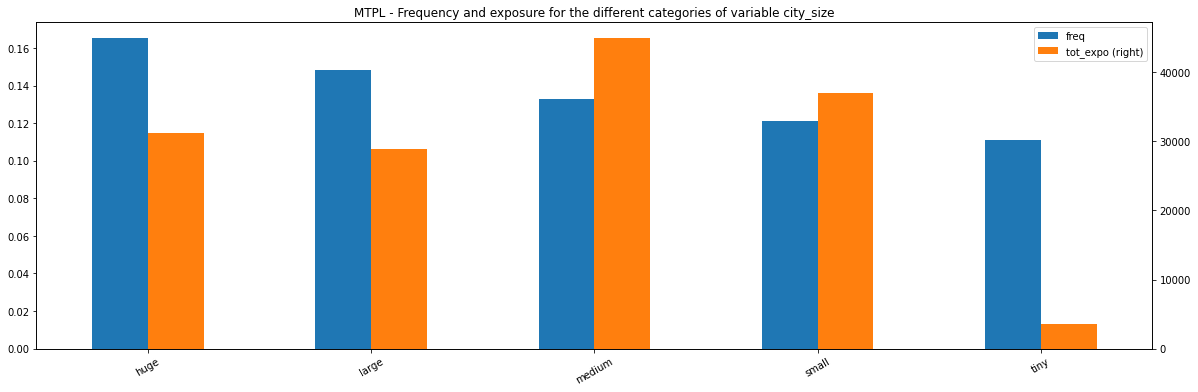


Univariate GLM for frequency in function of variable city_size


The AIC for the model 'nbrtotc ~ city_size' is 102249.832

The total Deviance for the model 'nbrtotc ~ city_size' is 89892.323, of which 17920.631 for the test set and 71971.692 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130920
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51120.
Date:                Sun, 16 Jan 2022   Deviance:                       71972.
Time:                        21:32:23   Pearson chi2:                 1.60e+05
No. Iterations:                     6        

,huge,large,medium,small,tiny
huge,0.0,0.0,0.000,0.000,0.000
large,0.0,0.0,0.000,0.000,0.000
medium,0.0,0.0,0.000,0.000,0.001
small,0.0,0.0,0.000,0.000,0.072
tiny,0.0,0.0,0.001,0.072,0.000


In [701]:
glm_city_size1=MTPL_description_initial('city_size')
wald_table=Wald_hypothesis2(glm_city_size1, 'city_size')
index=['huge', 'large', 'medium', 'small', 'tiny']
wald_table=pd.DataFrame(wald_table, 
          columns=['huge', 'large', 'medium', 'small', 'tiny'],
          index = index)
wald_table.head(wald_table.shape[0])

Based on the P-value of the test statistic for the pair of categories `tiny` and `small` they can be gathered together. We'll reuse the `small` category for this binned category.

In [702]:
mtpl["city_size"].value_counts()

medium    50222
small     41376
huge      35318
large     32716
tiny       4025
Name: city_size, dtype: int64

In [703]:
mtpl2=mtpl.copy()
mtpl_train2=mtpl_train.copy()
mtpl_test2=mtpl_test.copy()
 
mtpl2["city_size"]=mtpl2["city_size"].replace('tiny','small')
mtpl_train2["city_size"]=mtpl_train2["city_size"].replace('tiny','small')
mtpl_test2["city_size"]=mtpl_test2["city_size"].replace('tiny','small')
mtpl["city_size"].value_counts()

medium    50222
small     41376
huge      35318
large     32716
tiny       4025
Name: city_size, dtype: int64

We rerun the model to assess the impact of the gathering.

In [704]:
glm_city_size2=generate_glm('nbrtotc ~ ', 'city_size', mtpl_train2, mtpl_test2, 'lnexpo')
wald_table=Wald_hypothesis2(glm_city_size2, 'city_size')
index=['huge', 'large', 'medium', 'small']
wald_table=pd.DataFrame(wald_table, 
             columns=['huge', 'large', 'medium', 'small'],
             index=index)
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ city_size' is 102251.160

The total Deviance for the model 'nbrtotc ~ city_size' is 89894.738, of which 17919.718 for the test set and 71975.020 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,huge,large,medium,small
huge,0.0,0.0,0.0,0.0
large,0.0,0.0,0.0,0.0
medium,0.0,0.0,0.0,0.0
small,0.0,0.0,0.0,0.0


In [705]:
overview = assess_model_evolution('city_size', 2)
overview.head(overview.shape[0])

,Step,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,1,glm_city_size1,102249.832146,89892.323183,71971.692178,17920.631005
1,2,glm_city_size2,102251.159974,89894.737628,71975.020007,17919.717621


The AIC and Deviance slightly increased, but the model is a little less complex, which is an acceptable trade-off.

In [706]:
mtpl=mtpl2
mtpl_train=mtpl_train2
mtpl_test=mtpl_test2

In [707]:
mtpl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163657 entries, 0 to 163656
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   expo        163657 non-null  float64 
 1   lnexpo      163657 non-null  float64 
 2   nbrtotc     163657 non-null  int64   
 3   nbrtotan    163657 non-null  float64 
 4   chargtot    163657 non-null  float64 
 5   agecar      163657 non-null  category
 6   sexp        163657 non-null  category
 7   fuelc       163657 non-null  category
 8   split       163657 non-null  category
 9   usec        163657 non-null  category
 10  fleetc      163657 non-null  category
 11  sportc      163657 non-null  category
 12  coverp      163657 non-null  category
 13  powerc      163657 non-null  category
 14  province    163657 non-null  category
 15  city_size   163657 non-null  category
 16  pop_bucket  163657 non-null  category
 17  age_cat     163657 non-null  category
dtypes: category(13), float64

### 3.2.2 Categorical features with few possible values <a name="three-two-two"></a>

We now have a look at the categorical variables that have fewer possible values:


*   `sexp` 
*   `fuelc`
*   `usec`
*   `fleetc`
*   `sportc`
*   `powerc`
*   `split`
*   `agecar`



We will not apply a binning yet. If these features are included in the model later on, we'll examine the binning of their categories at that point.

***We observe that for the variable `usec` there is no clear distinction between the influence of 'professional' versus 'private' use of the car on the frequency of having an accident. The `p-value` is higher than 5%. This indicates that there is no need for that feature as input to our model. This was previously expected based on the number of observations with a 'professional' use.***

***For the features `fleetc`and `sportc`, despite the high concentration in potential values for these variables (cfr. above), they all seem to be relevant to determine the frequency of an accident, given the `p-value` below 5%.***

***All the other features are a priori relevant for determining the frequency, but this must be further proven or disproven later on in the analysis.*** 


MTPL - Frequency and exposure for the different categories of variable sexp

     sexp       tot_expo      freq
0  Female   38001.589041  0.148415
1    Male  107618.139726  0.136129


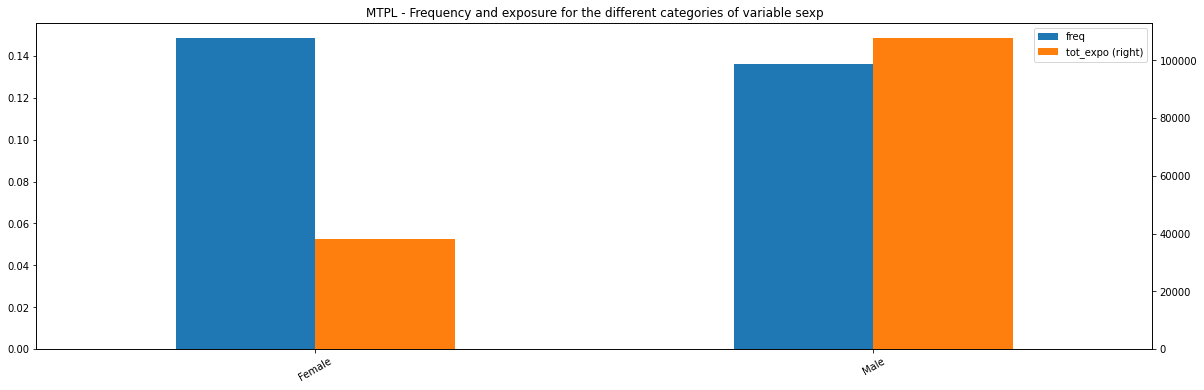

MTPL - Frequency and exposure for the different categories of variable fuelc

    fuelc       tot_expo     freq
0  Gasoil   44613.397260  0.15780
1  Petrol  101006.331507  0.13118


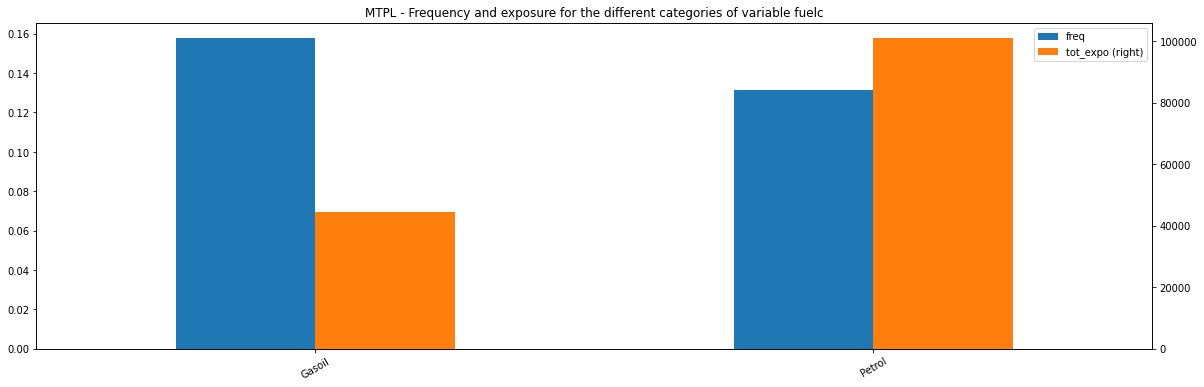

MTPL - Frequency and exposure for the different categories of variable usec

           usec       tot_expo      freq
0       Private  138394.630137  0.139384
1  Professional    7225.098630  0.138406


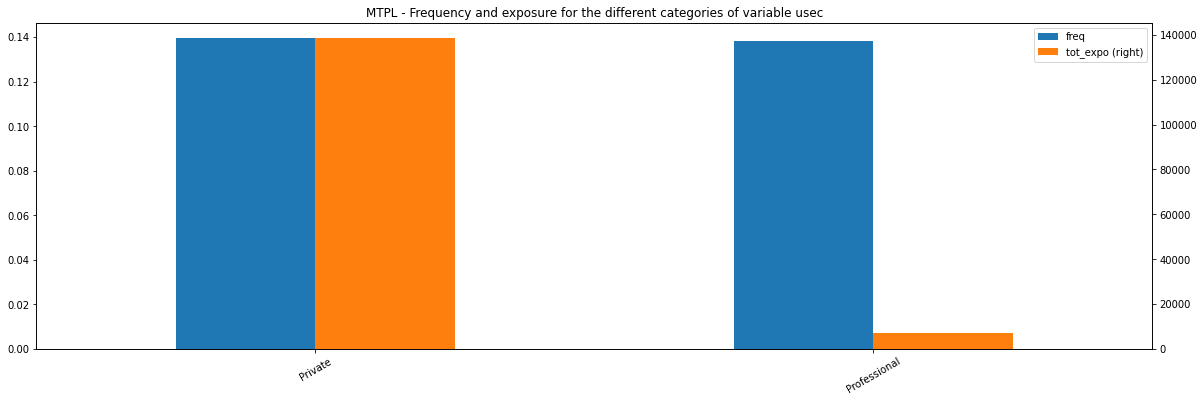

MTPL - Frequency and exposure for the different categories of variable fleetc

  fleetc       tot_expo      freq
0     No  140611.580822  0.140301
1    Yes    5008.147945  0.112217


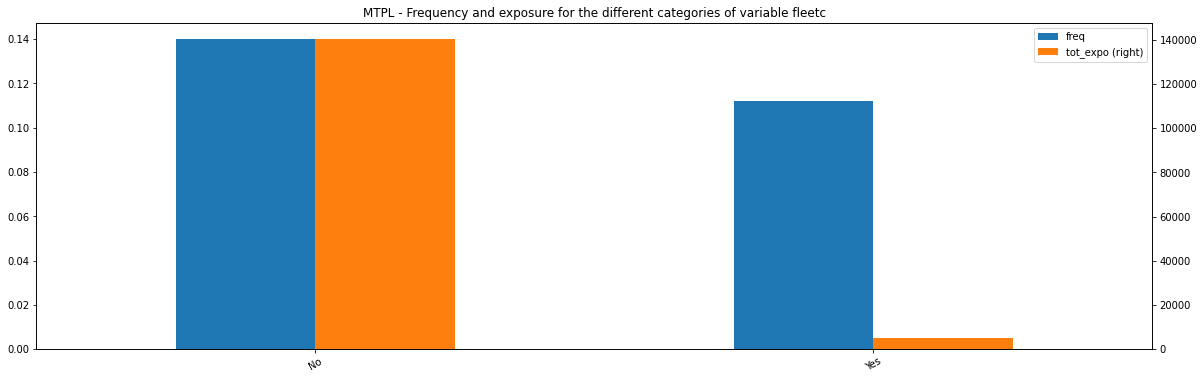

MTPL - Frequency and exposure for the different categories of variable sportc

  sportc       tot_expo      freq
0     No  144294.778082  0.139028
1    Yes    1324.950685  0.172837


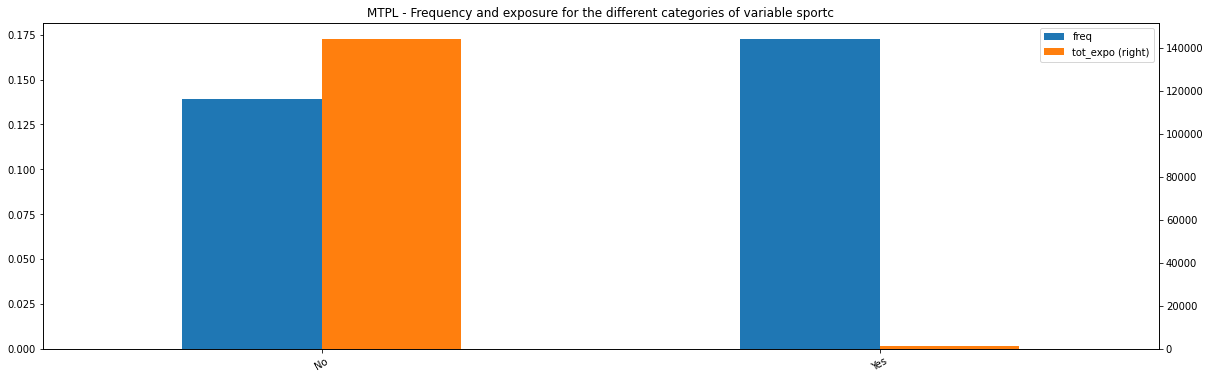

MTPL - Frequency and exposure for the different categories of variable powerc

   powerc       tot_expo      freq
0  66-110   37340.164384  0.143572
1     <66  106846.843836  0.137580
2    >110    1432.720548  0.159836


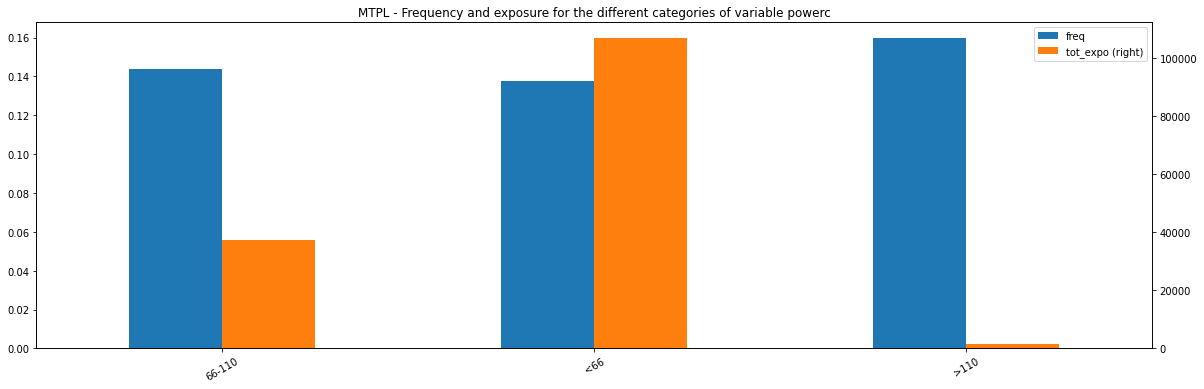

MTPL - Frequency and exposure for the different categories of variable split

     split      tot_expo      freq
0  Monthly  17446.791781  0.177683
1     Once  75070.876712  0.117462
2   Thrice  11105.052055  0.198738
3    Twice  41997.008219  0.146796


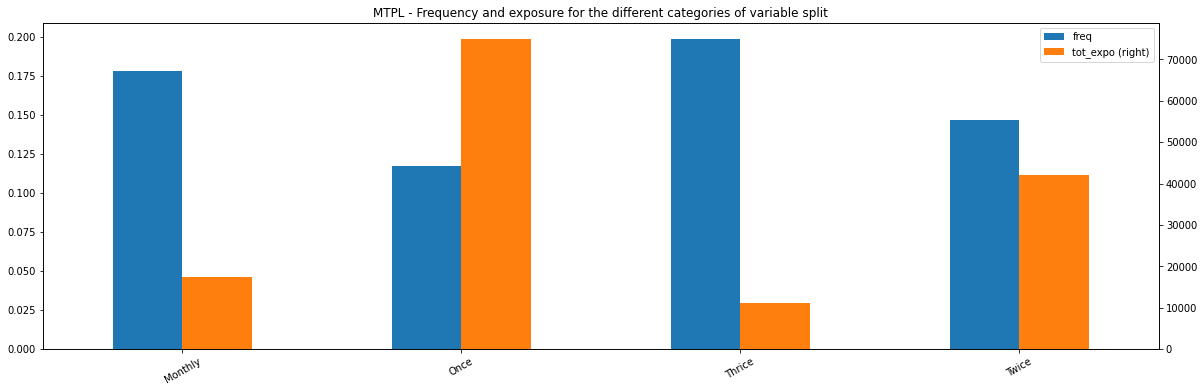

MTPL - Frequency and exposure for the different categories of variable agecar

  agecar      tot_expo      freq
0    0-1   6570.191781  0.169706
1    2-5  46189.060274  0.130529
2   6-10  60555.106849  0.139592
3    >10  32305.369863  0.145270


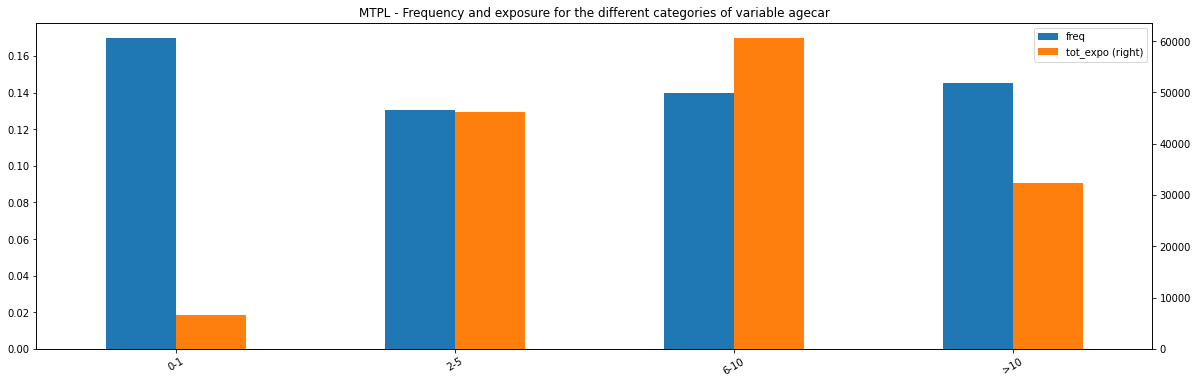

In [708]:
for c in ["sexp", "fuelc", "usec", "fleetc", "sportc", "powerc", "split", "agecar"] :
  MTPL_description_initial_no_glm(c)

# Chapter 4 - Building a GLM for claim frequency *bottom-up* <a name="four"></a>

## 4.1 - A model without features <a name="four-one"></a>

Step 0 of our GLM-model for frequency is a model without any features, just taking into account the exposure for all the policyholders in the training set.

In [709]:
model_formula= sm.formula.glm('nbrtotc ~ 1', data = mtpl_train, family=sm.families.Poisson(link=sm.families.links.log()), \
                              offset = mtpl_train.lnexpo)
glm_freq_expo = model_formula.fit()

train_dev= Poisson_deviance(glm_freq_expo, mtpl_train)
test_dev= Poisson_deviance(glm_freq_expo, mtpl_test)

print("The AIC for the model glm_freq_expo is "+str("%.3f" % glm_freq_expo.aic))
print("")
print("The total Deviance for the model glm_freq_expo is "+str("%.3f" % (train_dev + test_dev)) +", of which "+ str("%.3f" % test_dev) +" for the test set and " + str("%.3f" % glm_freq_expo.deviance) + " for the training set")


data=[]
data.append([0, 'N/A (exposure)', 'glm_freq_expo', glm_freq_expo.aic, (train_dev + test_dev), glm_freq_expo.deviance, test_dev])
  
first_glm=pd.DataFrame(data, columns=['Step', 'Var', 'Model', 'AIC', 'Total Deviance', 'Deviance_Train', 'Deviance_Test'])

The AIC for the model glm_freq_expo is 102452.116

The total Deviance for the model glm_freq_expo is 90178.453, of which 17996.478 for the test set and 72181.976 for the training set


In [710]:
Model_evol=[]
Model_evol.append(first_glm.iloc[0])
Model_evolution=pd.DataFrame(Model_evol)
Model_evolution.head(Model_evolution.shape[0])

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,0,N/A (exposure),glm_freq_expo,102452.115661,90178.453358,72181.975694,17996.477664


## 4.2 - Selection of the first feature `age_cat` <a name="four-two"></a>

We first build a GLM with a single feature and choose the model that best fits the data with a single feature.

In [711]:
def generate_initial_glm(init_formula, var, data_train, data_test, o_s) :
  str_model= "glm_freq_" + var
  globals()[str_model] = generate_glm(init_formula, var, data_train, data_test, o_s, print_sum=False)

In [712]:
for c in ["age_cat", "agecar", "sexp", "fuelc", "split", "usec", "fleetc", "sportc", "coverp", "powerc", "province", "city_size", "pop_bucket"] :
  generate_initial_glm('nbrtotc ~ ', c, mtpl_train, mtpl_test, 'lnexpo')

In [713]:
def verify_models(*args) :
  data=[]
  
  for c in args :
    model_name = 'glm_freq_'+c
    pred_test=eval(model_name).predict(mtpl_test)
    pred_train=eval(model_name).predict(mtpl_train)
    dev_test = Poisson_deviance(eval(model_name), mtpl_test)
    dev_train = Poisson_deviance(eval(model_name), mtpl_train)
    data.append([step, c, model_name, eval(model_name).aic, (dev_train + dev_test), eval(model_name).deviance, dev_test])
  
  df=pd.DataFrame(data, columns=['Step', 'Var', 'Model', 'AIC', 'Total Deviance', 'Deviance_Train', 'Deviance_Test'])
    
  print('The lowest AIC is '+ str("%.3f" % df.AIC.min()) +' for the model ' + df.iloc[df['AIC'].idxmin()][2])
  print("") 
  print('The Deviance for the test set is '+ str("%.3f" % df.iloc[df['AIC'].idxmin()][6]) + ' while the Deviance for the training set is '+ str("%.3f" % df.iloc[df['AIC'].idxmin()][5]))
 
#  ax = plt.gca()
#  df_plot=df.copy()

#  df_plot.plot('Var','AIC',linestyle ='' , marker = 'o', color = 'g', ax=ax)
#  df_plot.plot('Var','Total Deviance', linestyle ='' , marker = 'x', color = 'r', ax=ax)
#  df_plot.plot('Var','Deviance_Train', linestyle ='' , marker = 'v', color = 'y', ax=ax)
#  df_plot.plot('Var','Deviance_Test', linestyle ='' , marker = 's', color = 'b', ax=ax)
#  plt.figure(figsize=(10,10));
  
  #plt.show()
  print("")
  print(" --- + --- + ---- + --- + --- + --- + --- + --- + --- + --- + --- + ---")
  print("")
  print('The resulting metrics for the features of the model ' + df.iloc[df['AIC'].idxmin()][1] + ' are as follows: ')
  print(eval(df.iloc[df['AIC'].idxmin()][2]).summary())
  print("")
  print(" --- + --- + ---- + --- + --- + --- + --- + --- + --- + --- + --- + ---")
  print("")
  print('The wald test results for the features of the model ' + df.iloc[df['AIC'].idxmin()][1] + ' are as follows: ')
  print(eval(df.iloc[df['AIC'].idxmin()][2]).wald_test_terms())
  print("")
  return(df)

In [714]:
step=1
second_glm = verify_models("age_cat", "agecar", "sexp", "fuelc", "split", "usec", "fleetc", "sportc", "coverp", "powerc", "province", "city_size", "pop_bucket")
second_glm.head(second_glm.shape[0])

The lowest AIC is 101454.574 for the model glm_freq_age_cat

The Deviance for the test set is 17688.723 while the Deviance for the training set is 71166.435

 --- + --- + ---- + --- + --- + --- + --- + --- + --- + --- + --- + ---

The resulting metrics for the features of the model age_cat are as follows: 
                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130915
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50717.
Date:                Sun, 16 Jan 2022   Deviance:                       71166.
Time:                        21:32:35   Pearson chi2:                 1.58e+05
No. Iterations:                     6                       

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,1,age_cat,glm_freq_age_cat,101454.574492,88855.158007,71166.434525,17688.723483
1,1,agecar,glm_freq_agecar,102392.290534,90104.701204,72116.150567,17988.550638
2,1,sexp,glm_freq_sexp,102429.279454,90148.451557,72157.139487,17991.312070
3,1,fuelc,glm_freq_fuelc,102319.807372,90024.920236,72047.667405,17977.252831
4,1,split,glm_freq_split,101868.016122,89473.022157,71591.876155,17881.146003
5,1,usec,glm_freq_usec,102454.083936,90178.406495,72181.943969,17996.462526
6,1,fleetc,glm_freq_fleetc,102430.853915,90149.177750,72158.713947,17990.463803
7,1,sportc,glm_freq_sportc,102444.209513,90168.561195,72172.069546,17996.491649
8,1,coverp,glm_freq_coverp,102396.722612,90110.334175,72122.582645,17987.751530
9,1,powerc,glm_freq_powerc,102444.436298,90167.453866,72170.296331,17997.157535


Based on the previous results, we start the glm for frequency with `age_cat` as a first feature. In the next sections, we'll add more features to the model.

There is no need for a further 'binning' analysis for this variable, this has been performed in section 3.

We store the elements of the building steps of the models in a table that shows the evolution.

In [715]:
Model_evol.append(second_glm.iloc[0])
Model_evolution=pd.DataFrame(Model_evol)
Model_evolution.head(Model_evolution.shape[0])


,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,0,N/A (exposure),glm_freq_expo,102452.115661,90178.453358,72181.975694,17996.477664
0,1,age_cat,glm_freq_age_cat,101454.574492,88855.158007,71166.434525,17688.723483


The main improvement is on the test set, which is rather normal. Without any feature (step 0), the GLM simply reproduces the average frequency over all observations in the training set, which is different from the one on the training set, as seen in section 3. The training set and test set are aligned in their proportions with respect to th

## 4.3 - Selection of the second feature `province` <a name="four-three"></a>

We now perform the same analysis as before, starting from the glm with a single feature `age_cat` to select as a second feature to add as input the one that gives the lowest AIC (and Deviance). We also keep track of the MSE on the training and the test set, to see when/if the model is evolving towards being overfitted.

*(This module takes about 30 seconds to run)*

In [716]:
for c in ["agecar", "sexp", "fuelc", "split", "usec", "fleetc", "sportc", "coverp", "powerc", "province", "city_size", "pop_bucket"] :
  generate_initial_glm('nbrtotc ~ age_cat + ', c, mtpl_train, mtpl_test, 'lnexpo')

step=2
third_glm = verify_models("agecar", "sexp", "fuelc", "split", "usec", "fleetc", "sportc", "coverp", "powerc", "province", "city_size", "pop_bucket")
third_glm.head(third_glm.shape[0])

The lowest AIC is 101026.148 for the model glm_freq_province

The Deviance for the test set is 17563.037 while the Deviance for the training set is 70718.008

 --- + --- + ---- + --- + --- + --- + --- + --- + --- + --- + --- + ---

The resulting metrics for the features of the model province are as follows: 
                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130905
Model Family:                 Poisson   Df Model:                           19
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50493.
Date:                Sun, 16 Jan 2022   Deviance:                       70718.
Time:                        21:32:47   Pearson chi2:                 1.56e+05
No. Iterations:                     6                     

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,2,agecar,glm_freq_agecar,101395.409618,88783.526775,71101.269651,17682.257125
1,2,sexp,glm_freq_sexp,101455.958886,88854.705630,71165.818919,17688.886711
2,2,fuelc,glm_freq_fuelc,101373.749006,88765.363880,71083.609038,17681.754842
3,2,split,glm_freq_split,101066.802025,88400.140674,70772.662058,17627.478616
4,2,usec,glm_freq_usec,101455.520372,88853.717971,71165.380405,17688.337566
5,2,fleetc,glm_freq_fleetc,101447.871601,88844.458571,71157.731634,17686.726937
6,2,sportc,glm_freq_sportc,101454.645670,88853.895007,71164.505703,17689.389305
7,2,coverp,glm_freq_coverp,101427.872410,88823.014911,71135.732443,17687.282468
8,2,powerc,glm_freq_powerc,101439.093514,88835.691255,71146.953546,17688.737709
9,2,province,glm_freq_province,101026.147898,88281.045396,70718.007930,17563.037466


The second feature to select is `province`. The AIC and Deviance of the model are decreasing, as are the MSE on the training and the test datasets.

Both features are significant, based on the Wald Test results.

We can further check if the `province` categories must be binned.

In [717]:
wald_table=Wald_hypothesis2(glm_freq_province, 'province')
index=['ANTW', 'BRUS', 'BRWA', 'HNGW', 'LIMB', 'LUIK', 'LUXB', 'NAMN', 'OVLA', 'VLBR', 'WVLA']
wald_table=pd.DataFrame(wald_table, 
             columns=['ANTW', 'BRUS', 'BRWA', 'HNGW', 'LIMB', 'LUIK', 'LUXB', 'NAMN', 'OVLA', 'VLBR', 'WVLA'],
             index=index)
wald_table.head(wald_table.shape[0])
#wald_table.reindex(index)
#wald_table.set_index('province', drop=True)

,ANTW,BRUS,BRWA,HNGW,LIMB,LUIK,LUXB,NAMN,OVLA,VLBR,WVLA
ANTW,0.000,0.0,0.026,0.972,0.091,0.038,0.001,0.115,0.249,0.830,0.003
BRUS,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
BRWA,0.026,0.0,0.000,0.016,0.001,0.433,0.000,0.002,0.170,0.052,0.000
HNGW,0.972,0.0,0.016,0.000,0.072,0.015,0.001,0.094,0.175,0.787,0.001
LIMB,0.091,0.0,0.001,0.072,0.000,0.001,0.073,0.912,0.010,0.078,0.476
LUIK,0.038,0.0,0.433,0.015,0.001,0.000,0.000,0.002,0.393,0.101,0.000
LUXB,0.001,0.0,0.000,0.001,0.073,0.000,0.000,0.060,0.000,0.001,0.154
NAMN,0.115,0.0,0.002,0.094,0.912,0.002,0.060,0.000,0.014,0.099,0.398
OVLA,0.249,0.0,0.170,0.175,0.010,0.393,0.000,0.014,0.000,0.405,0.000
VLBR,0.830,0.0,0.052,0.787,0.078,0.101,0.001,0.099,0.405,0.000,0.003


This seems to indicate that 'ANTW' and 'HNGW' are the first two to be grouped together. Because there is no "intuitive" explanation why they can indeed be grouped (there is no "order" in the provinces), we'll only group provinces that "touch" each-other. 

We'll follow this path using a separate copy of the training and test file to see where it leads us.



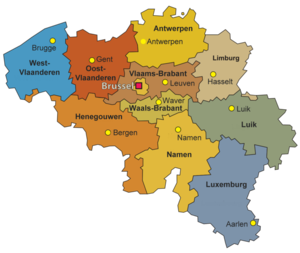

We'll first bin 'VLBR' and 'ANTW' based on the P-value for the `Wald hypothesis test` and the fact that they "touch" each other.

In [718]:
glm_province1 = glm_freq_province
mtpl_province1 = mtpl.copy()
mtpl_train_province1 = mtpl_train.copy()
mtpl_test_province1 = mtpl_test.copy()
mtpl_province2 = mtpl.copy()
mtpl_train_province2 = mtpl_train.copy()
mtpl_test_province2 = mtpl_test.copy()
mtpl_province2["province"]=mtpl_province2["province"].replace(['ANTW', 'VLBR'], 'AT_VB')
mtpl_train_province2["province"]=mtpl_train_province2["province"].replace(['ANTW', 'VLBR'], 'AT_VB')
mtpl_test_province2["province"]=mtpl_test_province2["province"].replace(['ANTW', 'VLBR'], 'AT_VB')
#mtpl_province.province.value_counts()

In [719]:
glm_province2 = generate_glm('nbrtotc ~ age_cat + ', 'province', mtpl_train_province2, mtpl_test_province2 ,'lnexpo')
#print(glm_province2.summary())
wald_table=Wald_hypothesis2(glm_province2,'province')
wald_table=pd.DataFrame(wald_table, 
             columns= ['AT_VB', 'BRUS', 'BRWA', 'HNGW', 'LIMB', 'LUIK', 'LUXB', 'NAMN', 'OVLA', 'WVLA'], 
             index=['AT_VB', 'BRUS', 'BRWA', 'HNGW', 'LIMB', 'LUIK', 'LUXB', 'NAMN', 'OVLA', 'WVLA']) 
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ age_cat + province' is 101024.194

The total Deviance for the model 'nbrtotc ~ age_cat + province' is 88280.921, of which 17562.867 for the test set and 70718.054 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,AT_VB,BRUS,BRWA,HNGW,LIMB,LUIK,LUXB,NAMN,OVLA,WVLA
AT_VB,0.000,0.0,0.022,0.864,0.060,0.026,0.001,0.079,0.237,0.001
BRUS,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
BRWA,0.022,0.0,0.000,0.016,0.001,0.433,0.000,0.002,0.170,0.000
HNGW,0.864,0.0,0.016,0.000,0.072,0.015,0.001,0.094,0.175,0.001
LIMB,0.060,0.0,0.001,0.072,0.000,0.001,0.073,0.912,0.010,0.476
LUIK,0.026,0.0,0.433,0.015,0.001,0.000,0.000,0.002,0.393,0.000
LUXB,0.001,0.0,0.000,0.001,0.073,0.000,0.000,0.060,0.000,0.154
NAMN,0.079,0.0,0.002,0.094,0.912,0.002,0.060,0.000,0.014,0.397
OVLA,0.237,0.0,0.170,0.175,0.010,0.393,0.000,0.014,0.000,0.000
WVLA,0.001,0.0,0.000,0.001,0.476,0.000,0.154,0.397,0.000,0.000


In [720]:
mtpl_province3 = mtpl_province2.copy()
mtpl_train_province3 = mtpl_train_province2.copy()
mtpl_test_province3 = mtpl_test_province2.copy()
mtpl_province3["province"]=mtpl_province3["province"].replace(['AT_VB', 'HNGW'], 'AT_VB_HN')
mtpl_train_province3["province"]=mtpl_train_province3["province"].replace(['AT_VB', 'HNGW'], 'AT_VB_HN')
mtpl_test_province3["province"]=mtpl_test_province3["province"].replace(['AT_VB', 'HNGW'], 'AT_VB_HN')
#mtpl_province.province.value_counts()

glm_province3 = generate_glm('nbrtotc ~ age_cat + ', 'province', mtpl_train_province3, mtpl_test_province3 ,'lnexpo')
#print(glm_province3.summary())
wald_table=Wald_hypothesis2(glm_province3,'province')
wald_table=pd.DataFrame(wald_table, 
             columns= ['AT_VB_HN', 'BRUS', 'BRWA', 'LIMB', 'LUIK', 'LUXB', 'NAMN', 'OVLA', 'WVLA'], 
             index=['AT_VB_HN', 'BRUS', 'BRWA', 'LIMB', 'LUIK', 'LUXB', 'NAMN', 'OVLA', 'WVLA']) 
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ age_cat + province' is 101022.223

The total Deviance for the model 'nbrtotc ~ age_cat + province' is 88280.963, of which 17562.880 for the test set and 70718.083 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,AT_VB_HN,BRUS,BRWA,LIMB,LUIK,LUXB,NAMN,OVLA,WVLA
AT_VB_HN,0.000,0.0,0.014,0.054,0.009,0.001,0.072,0.161,0.000
BRUS,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
BRWA,0.014,0.0,0.000,0.001,0.433,0.000,0.002,0.170,0.000
LIMB,0.054,0.0,0.001,0.000,0.001,0.073,0.912,0.010,0.476
LUIK,0.009,0.0,0.433,0.001,0.000,0.000,0.002,0.393,0.000
LUXB,0.001,0.0,0.000,0.073,0.000,0.000,0.060,0.000,0.154
NAMN,0.072,0.0,0.002,0.912,0.002,0.060,0.000,0.014,0.398
OVLA,0.161,0.0,0.170,0.010,0.393,0.000,0.014,0.000,0.000
WVLA,0.000,0.0,0.000,0.476,0.000,0.154,0.398,0.000,0.000


In [721]:
mtpl_province4 = mtpl_province3.copy()
mtpl_train_province4 = mtpl_train_province3.copy()
mtpl_test_province4 = mtpl_test_province3.copy()
mtpl_province4["province"]=mtpl_province4["province"].replace(['AT_VB_HN', 'WVLA'], 'AT_VB_HN_WV')
mtpl_train_province4["province"]=mtpl_train_province4["province"].replace(['AT_VB_HN', 'WVLA'], 'AT_VB_HN_WV')
mtpl_test_province4["province"]=mtpl_test_province4["province"].replace(['AT_VB_HN', 'WVLA'], 'AT_VB_HN_WV')
#mtpl_province.province.value_counts()

glm_province4 = generate_glm('nbrtotc ~ age_cat + ', 'province', mtpl_train_province4, mtpl_test_province4 ,'lnexpo')
#print(glm_province4.summary())
wald_table=Wald_hypothesis2(glm_province4,'province')
wald_table=pd.DataFrame(wald_table, 
             columns= ['AT_VB_HN_WV', 'BRUS', 'BRWA', 'LIMB', 'LUIK', 'LUXB', 'NAMN', 'OVLA'], 
             index=['AT_VB_HN_WV', 'BRUS', 'BRWA', 'LIMB', 'LUIK', 'LUXB', 'NAMN', 'OVLA']) 
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ age_cat + province' is 101034.256

The total Deviance for the model 'nbrtotc ~ age_cat + province' is 88302.423, of which 17570.307 for the test set and 70732.116 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,AT_VB_HN_WV,BRUS,BRWA,LIMB,LUIK,LUXB,NAMN,OVLA
AT_VB_HN_WV,0.000,0.0,0.003,0.160,0.000,0.002,0.198,0.024
BRUS,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000
BRWA,0.003,0.0,0.000,0.001,0.429,0.000,0.001,0.177
LIMB,0.160,0.0,0.001,0.000,0.001,0.073,0.920,0.010
LUIK,0.000,0.0,0.429,0.001,0.000,0.000,0.002,0.416
LUXB,0.002,0.0,0.000,0.073,0.000,0.000,0.061,0.000
NAMN,0.198,0.0,0.001,0.920,0.002,0.061,0.000,0.013
OVLA,0.024,0.0,0.177,0.010,0.416,0.000,0.013,0.000


In [722]:
mtpl_province5 = mtpl_province4.copy()
mtpl_train_province5 = mtpl_train_province4.copy()
mtpl_test_province5 = mtpl_test_province4.copy()
mtpl_province5["province"]=mtpl_province5["province"].replace(['AT_VB_HN_WV', 'LIMB'], 'AT_VB_HN_WV_LB')
mtpl_train_province5["province"]=mtpl_train_province5["province"].replace(['AT_VB_HN_WV', 'LIMB'], 'AT_VB_HN_WV_LB')
mtpl_test_province5["province"]=mtpl_test_province5["province"].replace(['AT_VB_HN_WV', 'LIMB'], 'AT_VB_HN_WV_LB')
#mtpl_province.province.value_counts()

glm_province5 = generate_glm('nbrtotc ~ age_cat + ', 'province', mtpl_train_province5, mtpl_test_province5 ,'lnexpo')
#print(glm_province5.summary())
wald_table=Wald_hypothesis2(glm_province5,'province')
wald_table=pd.DataFrame(wald_table, 
             columns= ['AT_VB_HN_WV_LB', 'BRUS', 'BRWA', 'LUIK', 'LUXB', 'NAMN', 'OVLA'], 
             index=['AT_VB_HN_WV_LB', 'BRUS', 'BRWA', 'LUIK', 'LUXB', 'NAMN', 'OVLA']) 
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ age_cat + province' is 101034.264

The total Deviance for the model 'nbrtotc ~ age_cat + province' is 88304.141, of which 17570.017 for the test set and 70734.124 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,AT_VB_HN_WV_LB,BRUS,BRWA,LUIK,LUXB,NAMN,OVLA
AT_VB_HN_WV_LB,0.000,0.0,0.002,0.000,0.003,0.242,0.015
BRUS,0.000,0.0,0.000,0.000,0.000,0.000,0.000
BRWA,0.002,0.0,0.000,0.429,0.000,0.001,0.177
LUIK,0.000,0.0,0.429,0.000,0.000,0.002,0.416
LUXB,0.003,0.0,0.000,0.000,0.000,0.061,0.000
NAMN,0.242,0.0,0.001,0.002,0.061,0.000,0.013
OVLA,0.015,0.0,0.177,0.416,0.000,0.013,0.000


In [723]:
mtpl_province6 = mtpl_province5.copy()
mtpl_train_province6 = mtpl_train_province5.copy()
mtpl_test_province6 = mtpl_test_province5.copy()
mtpl_province5["province"]=mtpl_province6["province"].replace(['BRWA', 'LUIK'], 'BW_LU')
mtpl_train_province6["province"]=mtpl_train_province6["province"].replace(['BRWA', 'LUIK'], 'BW_LU')
mtpl_test_province6["province"]=mtpl_test_province6["province"].replace(['BRWA', 'LUIK'], 'BW_LU')
#mtpl_province.province.value_counts()

glm_province6 = generate_glm('nbrtotc ~ age_cat + ', 'province', mtpl_train_province6, mtpl_test_province6 ,'lnexpo')
#print(glm_province6.summary())
wald_table=Wald_hypothesis2(glm_province6,'province')
wald_table=pd.DataFrame(wald_table, 
             columns= ['AT_VB_HN_WV_LB', 'BRUS', 'BW_LU', 'LUXB', 'NAMN', 'OVLA'], 
             index=['AT_VB_HN_WV_LB', 'BRUS', 'BW_LU', 'LUXB', 'NAMN', 'OVLA']) 
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ age_cat + province' is 101032.887

The total Deviance for the model 'nbrtotc ~ age_cat + province' is 88304.901, of which 17570.154 for the test set and 70734.747 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,AT_VB_HN_WV_LB,BRUS,BW_LU,LUXB,NAMN,OVLA
AT_VB_HN_WV_LB,0.000,0.0,0.000,0.003,0.242,0.015
BRUS,0.000,0.0,0.000,0.000,0.000,0.000
BW_LU,0.000,0.0,0.000,0.000,0.001,0.256
LUXB,0.003,0.0,0.000,0.000,0.061,0.000
NAMN,0.242,0.0,0.001,0.061,0.000,0.013
OVLA,0.015,0.0,0.256,0.000,0.013,0.000


In [724]:
mtpl_province7 = mtpl_province6.copy()
mtpl_train_province7 = mtpl_train_province6.copy()
mtpl_test_province7 = mtpl_test_province6.copy()
mtpl_province7["province"]=mtpl_province7["province"].replace(['LUXB', 'NAMN'], 'LU_NA')
mtpl_train_province7["province"]=mtpl_train_province7["province"].replace(['LUXB', 'NAMN'], 'LU_NA')
mtpl_test_province7["province"]=mtpl_test_province7["province"].replace(['LUXB', 'NAMN'], 'LU_NA')
#mtpl_province.province.value_counts()

glm_province7 = generate_glm('nbrtotc ~ age_cat + ', 'province', mtpl_train_province7, mtpl_test_province7 ,'lnexpo')
#print(glm_province7.summary())
wald_table=Wald_hypothesis2(glm_province7,'province')
wald_table=pd.DataFrame(wald_table, 
             columns= ['AT_VB_HN_WV_LB', 'BRUS', 'BW_LU', 'LU_NA', 'OVLA'], 
             index=['AT_VB_HN_WV_LB', 'BRUS', 'BW_LU', 'LU_NA', 'OVLA']) 
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ age_cat + province' is 101034.464

The total Deviance for the model 'nbrtotc ~ age_cat + province' is 88310.430, of which 17572.106 for the test set and 70738.324 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,AT_VB_HN_WV_LB,BRUS,BW_LU,LU_NA,OVLA
AT_VB_HN_WV_LB,0.000,0.0,0.000,0.011,0.015
BRUS,0.000,0.0,0.000,0.000,0.000
BW_LU,0.000,0.0,0.000,0.000,0.257
LU_NA,0.011,0.0,0.000,0.000,0.000
OVLA,0.015,0.0,0.257,0.000,0.000


In [725]:
data=[]
for c in range(1, 8, 1) :
    model_name = 'glm_province'+str(c)
    model = eval(model_name)
    test_set = eval('mtpl_test_province'+str(c))
    train_set = eval('mtpl_train_province'+str(c))
    pred_test = model.predict(test_set)
    pred_train = model.predict(train_set)
    dev_test = Poisson_deviance(model, test_set)
    dev_train = Poisson_deviance(model, train_set)
    data.append([c, model_name, model.aic, dev_train + dev_test, model.deviance, dev_test])
  
summary=pd.DataFrame(data, columns=['Step', 'Model', 'AIC', 'Total Deviance', 'Deviance_Train', 'Deviance_Test'])
summary.head(summary.shape[0]).round(3) 

summary.head(summary.shape[0])

,Step,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,1,glm_province1,101026.147898,88281.045396,70718.007930,17563.037466
1,2,glm_province2,101024.193981,88280.920989,70718.054014,17562.866975
2,3,glm_province3,101022.223163,88280.963075,70718.083196,17562.879879
3,4,glm_province4,101034.255949,88302.422583,70732.115982,17570.306601
4,5,glm_province5,101034.264150,88304.141142,70734.124183,17570.016959
5,6,glm_province6,101032.887167,88304.901270,70734.747200,17570.154071
6,7,glm_province7,101034.464339,88310.430026,70738.324372,17572.105654


We'll stop after the third step when the indicators are the lowest. That means that we've grouped a "belt" in the middle of Belgium, binning Antwerpen, Vlaams Brabant and Henegouwen.

In [726]:
mtpl = mtpl_province3.copy()
mtpl_test = mtpl_test_province3.copy()
mtpl_train = mtpl_train_province3.copy()
glm_freq_province = generate_glm('nbrtotc ~ age_cat + ', 'province', mtpl_train, mtpl_test ,'lnexpo')



The AIC for the model 'nbrtotc ~ age_cat + province' is 101022.223

The total Deviance for the model 'nbrtotc ~ age_cat + province' is 88280.963, of which 17562.880 for the test set and 70718.083 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


In [727]:
data=[]
data.append([step, 'province', 'glm_freq_province', glm_freq_province.aic, Poisson_deviance(glm_freq_province, mtpl_train) + Poisson_deviance(glm_freq_province, mtpl_test), glm_freq_province.deviance, Poisson_deviance(glm_freq_province, mtpl_test)])
third_glm=pd.DataFrame(data, columns=['Step', 'Var', 'Model', 'AIC', 'Total Deviance', 'Deviance_Train', 'Deviance_Test'])

Model_evol.append(third_glm.iloc[0])
Model_evolution=pd.DataFrame(Model_evol)
Model_evolution.head(Model_evolution.shape[0])


,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,0,N/A (exposure),glm_freq_expo,102452.115661,90178.453358,72181.975694,17996.477664
0,1,age_cat,glm_freq_age_cat,101454.574492,88855.158007,71166.434525,17688.723483
0,2,province,glm_freq_province,101022.223163,88280.963075,70718.083196,17562.879879


## 4.4 - Selection of the third feature `split` <a name="four-four"></a>

In [728]:
for c in ["agecar", "sexp", "fuelc", "split", "usec", "fleetc", "sportc", "coverp", "powerc", "city_size", "pop_bucket"] :
  generate_initial_glm('nbrtotc ~ age_cat + province + ', c, mtpl_train, mtpl_test, 'lnexpo')

step=3
fourth_glm = verify_models("agecar", "sexp", "fuelc", "split", "usec", "fleetc", "sportc", "coverp", "powerc", "city_size", "pop_bucket")
fourth_glm.head(fourth_glm.shape[0])

The lowest AIC is 100722.698 for the model glm_freq_split

The Deviance for the test set is 17526.138 while the Deviance for the training set is 70412.558

 --- + --- + ---- + --- + --- + --- + --- + --- + --- + --- + --- + ---

The resulting metrics for the features of the model split are as follows: 
                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130904
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50340.
Date:                Sun, 16 Jan 2022   Deviance:                       70413.
Time:                        21:33:13   Pearson chi2:                 1.54e+05
No. Iterations:                     6                           

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,3,agecar,glm_freq_agecar,100964.056123,88210.364203,70653.916156,17556.448048
1,3,sexp,glm_freq_sexp,101024.179555,88280.967683,70718.039588,17562.928095
2,3,fuelc,glm_freq_fuelc,100915.251539,88160.730880,70609.111572,17551.619308
3,3,split,glm_freq_split,100722.698244,87938.696450,70412.558276,17526.138174
4,3,usec,glm_freq_usec,101023.770479,88280.185730,70717.630512,17562.555218
5,3,fleetc,glm_freq_fleetc,101011.639583,88264.826378,70705.499615,17559.326762
6,3,sportc,glm_freq_sportc,101021.184842,88278.666842,70715.044874,17563.621968
7,3,coverp,glm_freq_coverp,100963.562069,88207.625527,70655.422102,17552.203425
8,3,powerc,glm_freq_powerc,101010.127859,88264.652640,70701.987892,17562.664748
9,3,city_size,glm_freq_city_size,100919.563682,88122.723295,70609.423715,17513.299580


The next feature we add is the `pop_bucket`, the feature we've binned earlier in section 3. 

It gives a better performance than the `city_size` feature, which was an a priori grouping of cities based on their size.

We now have 3 features, all significant based upon the p-values in the Wald test results.

In [729]:
mtpl.pop_bucket.value_counts()

020_040K     71967
000_010K     45401
090_105+K    26844
060_080K     16556
050K          2889
Name: pop_bucket, dtype: int64

In [730]:
wald_table=Wald_hypothesis2(glm_freq_pop_bucket,'pop_bucket')
index=['000_010K', '020_040K', '050K', '060_080K', '090_105+K']
wald_table=pd.DataFrame(wald_table, 
             columns= ['000_010K', '020_040K', '050K', '060_080K', '090_105+K'],
             index=index)
wald_table.head(wald_table.shape[0])

,000_010K,020_040K,050K,060_080K,090_105+K
000_010K,0.0,0.000,0.000,0.000,0.000
020_040K,0.0,0.000,0.006,0.312,0.000
050K,0.0,0.006,0.000,0.033,0.516
060_080K,0.0,0.312,0.033,0.000,0.000
090_105+K,0.0,0.000,0.516,0.000,0.000


No further binning is required and we add this step to the model evolution overview.

In [731]:
Model_evol.append(fourth_glm.iloc[10])
Model_evolution=pd.DataFrame(Model_evol)
Model_evolution.head(Model_evolution.shape[0])

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,0,N/A (exposure),glm_freq_expo,102452.115661,90178.453358,72181.975694,17996.477664
0,1,age_cat,glm_freq_age_cat,101454.574492,88855.158007,71166.434525,17688.723483
0,2,province,glm_freq_province,101022.223163,88280.963075,70718.083196,17562.879879
10,3,pop_bucket,glm_freq_pop_bucket,100895.701674,88088.219656,70583.561707,17504.657950


## 4.5 - Selection of the fourth feature `pop_bucket` <a name="four-five"></a>

Given the extremely strong correlation of the `city_size` feature with the `pop_bucket` which is included in the model, we also leave that out of the potential additional features.

In [732]:
for c in ["agecar", "sexp", "fuelc", "split", "usec", "fleetc", "sportc", "coverp", "powerc"] :
  generate_initial_glm('nbrtotc ~ age_cat + province + pop_bucket + ', c, mtpl_train, mtpl_test, 'lnexpo')

step=4
fifth_glm = verify_models("agecar", "sexp", "fuelc", "split", "usec", "fleetc", "sportc", "coverp", "powerc")
fifth_glm.head(fifth_glm.shape[0])

The lowest AIC is 100615.813 for the model glm_freq_split

The Deviance for the test set is 17473.714 while the Deviance for the training set is 70297.673

 --- + --- + ---- + --- + --- + --- + --- + --- + --- + --- + --- + ---

The resulting metrics for the features of the model split are as follows: 
                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130900
Model Family:                 Poisson   Df Model:                           24
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50283.
Date:                Sun, 16 Jan 2022   Deviance:                       70298.
Time:                        21:33:29   Pearson chi2:                 1.54e+05
No. Iterations:                     6                           

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,4,agecar,glm_freq_agecar,100839.550547,88020.033594,70521.410579,17498.623015
1,4,sexp,glm_freq_sexp,100897.647656,88088.197741,70583.507689,17504.690052
2,4,fuelc,glm_freq_fuelc,100776.329224,87952.250654,70462.189256,17490.061398
3,4,split,glm_freq_split,100615.813256,87771.386990,70297.673289,17473.713702
4,4,usec,glm_freq_usec,100897.131483,88087.247242,70582.991516,17504.255726
5,4,fleetc,glm_freq_fleetc,100885.393505,88072.535748,70571.253538,17501.282211
6,4,sportc,glm_freq_sportc,100894.663668,88085.879821,70580.523700,17505.356121
7,4,coverp,glm_freq_coverp,100834.507027,88011.243796,70518.367059,17492.876737
8,4,powerc,glm_freq_powerc,100883.907153,88072.195189,70567.767186,17504.428004


The next feature to add is the `split` of the premium payment (annual, emi-annual, quarterly, monthtly).

In [733]:
wald_table=Wald_hypothesis2(glm_freq_split,'split')
index=['Monthly', 'Once', 'Thrice', 'Twice']
wald_table=pd.DataFrame(wald_table, 
             columns= ['Monthly', 'Once', 'Thrice', 'Twice'],
             index=index)
wald_table.head(wald_table.shape[0])

,Monthly,Once,Thrice,Twice
Monthly,0.000,0.0,0.213,0.0
Once,0.000,0.0,0.000,0.0
Thrice,0.213,0.0,0.000,0.0
Twice,0.000,0.0,0.000,0.0


Based on these p-values, the categories of monthly and quarterly payments could be grouped.

In [734]:
mtpl2 = mtpl.copy()
mtpl_train2 = mtpl_train.copy()
mtpl_test2=mtpl_test.copy()

mtpl2["split"]=mtpl2["split"].replace(['Thrice', 'Monthly'], '>2 times')
mtpl_train2["split"]=mtpl_train2["split"].replace(['Thrice', 'Monthly'], '>2 times')
mtpl_test2["split"]=mtpl_test2["split"].replace(['Thrice', 'Monthly'], '>2 times')
#mtpl2.split.value_counts()

glm_freq_split2 = generate_glm('nbrtotc ~ age_cat +  province + pop_bucket +', 'split', mtpl_train2, mtpl_test2, 'lnexpo')

wald_table=Wald_hypothesis2(glm_freq_split2,'split')
index=['> 2 times', 'Once', 'Twice']
wald_table=pd.DataFrame(wald_table, 
             columns= ['> 2 times', 'Once', 'Twice'],
             index=index)
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ age_cat +  province + pop_bucket +split' is 100615.363

The total Deviance for the model 'nbrtotc ~ age_cat +  province + pop_bucket +split' is 87774.550, of which 17475.327 for the test set and 70299.223 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,> 2 times,Once,Twice
> 2 times,0.0,0.0,0.0
Once,0.0,0.0,0.0
Twice,0.0,0.0,0.0


There is no real advantage of actually binning those two categories. We therefore continue without this binning and add the feature to the model evolution.

In [735]:
Model_evol.append(fifth_glm.iloc[3])
Model_evolution=pd.DataFrame(Model_evol)
Model_evolution.head(Model_evolution.shape[0])

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,0,N/A (exposure),glm_freq_expo,102452.115661,90178.453358,72181.975694,17996.477664
0,1,age_cat,glm_freq_age_cat,101454.574492,88855.158007,71166.434525,17688.723483
0,2,province,glm_freq_province,101022.223163,88280.963075,70718.083196,17562.879879
10,3,pop_bucket,glm_freq_pop_bucket,100895.701674,88088.219656,70583.561707,17504.657950
3,4,split,glm_freq_split,100615.813256,87771.386990,70297.673289,17473.713702


## 4.6 - Selection of the fifth feature `fuelc`<a name="four-six"></a>

In [736]:
for c in ["agecar", "sexp", "fuelc", "usec", "fleetc", "sportc", "coverp", "powerc"] :
  generate_initial_glm('nbrtotc ~ age_cat + province + pop_bucket + split + ', c, mtpl_train, mtpl_test, 'lnexpo')

step=5
sixth_glm = verify_models("agecar", "sexp", "fuelc", "usec", "fleetc", "sportc", "coverp", "powerc")
sixth_glm.head(sixth_glm.shape[0])

The lowest AIC is 100499.688 for the model glm_freq_fuelc

The Deviance for the test set is 17458.800 while the Deviance for the training set is 70179.548

 --- + --- + ---- + --- + --- + --- + --- + --- + --- + --- + --- + ---

The resulting metrics for the features of the model fuelc are as follows: 
                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130899
Model Family:                 Poisson   Df Model:                           25
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50224.
Date:                Sun, 16 Jan 2022   Deviance:                       70180.
Time:                        21:33:47   Pearson chi2:                 1.54e+05
No. Iterations:                     6                           

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,5,agecar,glm_freq_agecar,100565.890157,87708.950528,70241.750190,17467.200338
1,5,sexp,glm_freq_sexp,100617.762035,87771.375098,70297.622068,17473.753030
2,5,fuelc,glm_freq_fuelc,100499.687724,87638.347452,70179.547757,17458.799695
3,5,usec,glm_freq_usec,100616.734116,87769.684257,70296.594149,17473.090108
4,5,fleetc,glm_freq_fleetc,100611.421488,87762.613779,70291.281521,17471.332258
5,5,sportc,glm_freq_sportc,100614.430704,87768.878379,70294.290737,17474.587642
6,5,coverp,glm_freq_coverp,100549.395749,87688.730042,70227.255782,17461.474261
7,5,powerc,glm_freq_powerc,100603.870850,87754.737741,70281.730883,17473.006858


The next feature to add would be the `fuelc`.

As a whole, the feature is significant and there is no need to bin the two different categories. We can add it to the model evolution overview.

In [737]:
mtpl.fuelc.value_counts()

Petrol    113210
Gasoil     50447
Name: fuelc, dtype: int64

In [738]:
Model_evol.append(sixth_glm.iloc[2])
Model_evolution=pd.DataFrame(Model_evol)
Model_evolution.head(Model_evolution.shape[0])

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,0,N/A (exposure),glm_freq_expo,102452.115661,90178.453358,72181.975694,17996.477664
0,1,age_cat,glm_freq_age_cat,101454.574492,88855.158007,71166.434525,17688.723483
0,2,province,glm_freq_province,101022.223163,88280.963075,70718.083196,17562.879879
10,3,pop_bucket,glm_freq_pop_bucket,100895.701674,88088.219656,70583.561707,17504.657950
3,4,split,glm_freq_split,100615.813256,87771.386990,70297.673289,17473.713702
2,5,fuelc,glm_freq_fuelc,100499.687724,87638.347452,70179.547757,17458.799695


We notice that the benefits of adding new features decrease with each feature that is added.

## 4.7 - Selection of the sixth feature `coverp`<a name="four-seven"></a>

In [739]:
for c in ["agecar", "sexp", "usec", "fleetc", "sportc", "coverp", "powerc"] :
  generate_initial_glm('nbrtotc ~ age_cat + province + pop_bucket + split + fuelc + ', c, mtpl_train, mtpl_test, 'lnexpo')

step=6
seventh_glm = verify_models("agecar", "sexp", "usec", "fleetc", "sportc", "coverp", "powerc")
seventh_glm.head(seventh_glm.shape[0])

The lowest AIC is 100419.148 for the model glm_freq_coverp

The Deviance for the test set is 17445.656 while the Deviance for the training set is 70095.008

 --- + --- + ---- + --- + --- + --- + --- + --- + --- + --- + --- + ---

The resulting metrics for the features of the model coverp are as follows: 
                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130897
Model Family:                 Poisson   Df Model:                           27
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50182.
Date:                Sun, 16 Jan 2022   Deviance:                       70095.
Time:                        21:34:02   Pearson chi2:                 1.53e+05
No. Iterations:                     6                         

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,6,agecar,glm_freq_agecar,100441.400698,87567.494708,70115.260731,17452.233977
1,6,sexp,glm_freq_sexp,100499.132092,87635.734634,70176.992125,17458.742509
2,6,usec,glm_freq_usec,100501.590295,87638.091167,70179.450328,17458.640839
3,6,fleetc,glm_freq_fleetc,100495.020949,87629.309025,70172.880982,17456.428043
4,6,sportc,glm_freq_sportc,100494.733346,87632.438422,70172.593379,17459.845044
5,6,coverp,glm_freq_coverp,100419.147882,87540.664297,70095.007915,17445.656382
6,6,powerc,glm_freq_powerc,100475.779050,87608.578571,70151.639083,17456.939488


In [740]:
mtpl.coverp.value_counts()

MTPL       95409
MTPL+      46073
MTPL+++    22175
Name: coverp, dtype: int64

In [741]:
wald_table=Wald_hypothesis2(glm_freq_coverp,'coverp')
index=['MTPL', 'MTPL+', 'MTPL+++']
wald_table=pd.DataFrame(wald_table, 
             columns= ['MTPL', 'MTPL+', 'MTPL+++'],
             index=index)
wald_table.head(wald_table.shape[0])

,MTPL,MTPL+,MTPL+++
MTPL,0.0,0.000,0.000
MTPL+,0.0,0.000,0.929
MTPL+++,0.0,0.929,0.000


In [742]:
mtpl2 = mtpl.copy()
mtpl_train2 = mtpl_train.copy()
mtpl_test2=mtpl_test.copy()

mtpl2["coverp"]=mtpl2["coverp"].replace(['MTPL+', 'MTPL+++'], 'MTPL+')
mtpl_train2["coverp"]=mtpl_train2["coverp"].replace(['MTPL+', 'MTPL+++'], 'MTPL+')
mtpl_test2["coverp"]=mtpl_test2["coverp"].replace(['MTPL+', 'MTPL+++'], 'MTPL+')
#mtpl2.coverp.value_counts()

glm_freq_coverp2 = generate_glm('nbrtotc ~ age_cat +  province + pop_bucket + split + fuelc + ', 'coverp', mtpl_train2, mtpl_test2, 'lnexpo')

wald_table=Wald_hypothesis2(glm_freq_coverp2,'coverp')
index=['MTPL', 'MTPL+']
wald_table=pd.DataFrame(wald_table, 
             columns= ['MTPL', 'MTPL+'],
             index=index)
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ age_cat +  province + pop_bucket + split + fuelc + coverp' is 100417.156

The total Deviance for the model 'nbrtotc ~ age_cat +  province + pop_bucket + split + fuelc + coverp' is 87540.717, of which 17445.701 for the test set and 70095.016 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,MTPL,MTPL+
MTPL,0.0,0.0
MTPL+,0.0,0.0


There is no advantage of binning in respect of the model performance, but it decreases model complexity. We'll keep the binning.

In [743]:
mtpl = mtpl2.copy()
mtpl_test = mtpl_test2.copy()
mtpl_train = mtpl_train2.copy()
glm_freq_coverp = generate_glm('nbrtotc ~ age_cat +  province + pop_bucket + split + fuelc + ', 'coverp', mtpl_train, mtpl_test, 'lnexpo')


The AIC for the model 'nbrtotc ~ age_cat +  province + pop_bucket + split + fuelc + coverp' is 100417.156

The total Deviance for the model 'nbrtotc ~ age_cat +  province + pop_bucket + split + fuelc + coverp' is 87540.717, of which 17445.701 for the test set and 70095.016 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


In [744]:
data=[]
data.append([step, 'coverp', 'glm_freq_coverp', glm_freq_coverp.aic, Poisson_deviance(glm_freq_coverp, mtpl_train) + Poisson_deviance(glm_freq_coverp, mtpl_test), glm_freq_coverp.deviance, Poisson_deviance(glm_freq_coverp, mtpl_test)])
seventh_glm=pd.DataFrame(data, columns=['Step', 'Var', 'Model', 'AIC', 'Total Deviance', 'Deviance_Train', 'Deviance_Test'])


In [745]:
Model_evol.append(seventh_glm.iloc[0])
Model_evolution=pd.DataFrame(Model_evol)
Model_evolution.head(Model_evolution.shape[0])

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,0,N/A (exposure),glm_freq_expo,102452.115661,90178.453358,72181.975694,17996.477664
0,1,age_cat,glm_freq_age_cat,101454.574492,88855.158007,71166.434525,17688.723483
0,2,province,glm_freq_province,101022.223163,88280.963075,70718.083196,17562.879879
10,3,pop_bucket,glm_freq_pop_bucket,100895.701674,88088.219656,70583.561707,17504.657950
3,4,split,glm_freq_split,100615.813256,87771.386990,70297.673289,17473.713702
2,5,fuelc,glm_freq_fuelc,100499.687724,87638.347452,70179.547757,17458.799695
0,6,coverp,glm_freq_coverp,100417.155736,87540.717078,70095.015768,17445.701309


We've added the feature `coverp`, with a benefit that is once again lower than that of the previous feature.

## 4.8 - Selection of the seventh feature `agecar`<a name="four-eight"></a>

In [746]:
for c in ["agecar", "sexp", "usec", "fleetc", "sportc", "powerc"] :
  generate_initial_glm('nbrtotc ~ age_cat + province + pop_bucket + split + fuelc + coverp + ', c, mtpl_train, mtpl_test, 'lnexpo')

step=7
eighth_glm = verify_models("agecar", "sexp", "usec", "fleetc", "sportc", "powerc")
eighth_glm.head(eighth_glm.shape[0])

The lowest AIC is 100377.150 for the model glm_freq_agecar

The Deviance for the test set is 17439.292 while the Deviance for the training set is 70049.010

 --- + --- + ---- + --- + --- + --- + --- + --- + --- + --- + --- + ---

The resulting metrics for the features of the model agecar are as follows: 
                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130895
Model Family:                 Poisson   Df Model:                           29
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50159.
Date:                Sun, 16 Jan 2022   Deviance:                       70049.
Time:                        21:34:20   Pearson chi2:                 1.53e+05
No. Iterations:                     6                         

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,7,agecar,glm_freq_agecar,100377.149886,87488.301421,70049.009918,17439.291503
1,7,sexp,glm_freq_sexp,100416.729957,87538.196903,70092.589990,17445.606913
2,7,usec,glm_freq_usec,100418.207676,87539.172078,70094.067709,17445.104370
3,7,fleetc,glm_freq_fleetc,100415.824233,87535.949961,70091.684265,17444.265695
4,7,sportc,glm_freq_sportc,100412.244000,87534.749385,70088.104033,17446.645352
5,7,powerc,glm_freq_powerc,100380.183829,87496.939704,70054.043862,17442.895842


In [747]:
wald_table=Wald_hypothesis2(glm_freq_agecar, 'agecar')
index =['0-1', '2-5','6-10', '>10']
wald_table=pd.DataFrame(wald_table, 
             columns=['0-1', '2-5','6-10', '>10'],
             index = index)
wald_table.head(wald_table.shape[0])

,0-1,2-5,6-10,>10
0-1,0.0,0.000,0.000,0.000
2-5,0.0,0.000,0.029,0.012
6-10,0.0,0.029,0.000,0.415
>10,0.0,0.012,0.415,0.000


In [748]:
mtpl2 = mtpl.copy()
mtpl_train2 = mtpl_train.copy()
mtpl_test2=mtpl_test.copy()

mtpl2["agecar"]=mtpl2["agecar"].replace(['6-10', '>10'], '>6')
mtpl_train2["agecar"]=mtpl_train2["agecar"].replace(['6-10', '>10'], '>6')
mtpl_test2["agecar"]=mtpl_test2["agecar"].replace(['6-10', '>10'], '>6')
#mtpl2.agecar.value_counts()

glm_freq_agecar2 = generate_glm('nbrtotc ~ age_cat +  province + pop_bucket + split + fuelc + coverp + ', 'agecar', mtpl_train2, mtpl_test2, 'lnexpo')

wald_table=Wald_hypothesis2(glm_freq_agecar2,'agecar')
index=['0-1', '2-5','>6']
wald_table=pd.DataFrame(wald_table, 
             columns= ['0-1', '2-5','>6'],
             index=index)
wald_table.head(wald_table.shape[0])


The AIC for the model 'nbrtotc ~ age_cat +  province + pop_bucket + split + fuelc + coverp + agecar' is 100375.815

The total Deviance for the model 'nbrtotc ~ age_cat +  province + pop_bucket + split + fuelc + coverp + agecar' is 87487.050, of which 17437.376 for the test set and 70049.675 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


,0-1,2-5,>6
0-1,0.0,0.00,0.00
2-5,0.0,0.00,0.01
>6,0.0,0.01,0.00


In [749]:
mtpl = mtpl2.copy()
mtpl_test = mtpl_test2.copy()
mtpl_train = mtpl_train2.copy()
glm_freq_agecar = generate_glm('nbrtotc ~ age_cat +  province + pop_bucket + split + fuelc + coverp + ', 'agecar', mtpl_train, mtpl_test, 'lnexpo')
data=[]
data.append([step, 'agecar', 'glm_freq_agecar', glm_freq_agecar.aic, Poisson_deviance(glm_freq_agecar, mtpl_train) + Poisson_deviance(glm_freq_agecar, mtpl_test), glm_freq_agecar.deviance, Poisson_deviance(glm_freq_agecar, mtpl_test)])
eighth_glm=pd.DataFrame(data, columns=['Step', 'Var', 'Model', 'AIC', 'Total Deviance', 'Deviance_Train', 'Deviance_Test'])


The AIC for the model 'nbrtotc ~ age_cat +  province + pop_bucket + split + fuelc + coverp + agecar' is 100375.815

The total Deviance for the model 'nbrtotc ~ age_cat +  province + pop_bucket + split + fuelc + coverp + agecar' is 87487.050, of which 17437.376 for the test set and 70049.675 for the training set
--- + --- + --- + --- + --- + --- + --- + --- + --- + ---


In [750]:
Model_evol.append(eighth_glm.iloc[0])
Model_evolution=pd.DataFrame(Model_evol)
Model_evolution.head(Model_evolution.shape[0])

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,0,N/A (exposure),glm_freq_expo,102452.115661,90178.453358,72181.975694,17996.477664
0,1,age_cat,glm_freq_age_cat,101454.574492,88855.158007,71166.434525,17688.723483
0,2,province,glm_freq_province,101022.223163,88280.963075,70718.083196,17562.879879
10,3,pop_bucket,glm_freq_pop_bucket,100895.701674,88088.219656,70583.561707,17504.657950
3,4,split,glm_freq_split,100615.813256,87771.386990,70297.673289,17473.713702
2,5,fuelc,glm_freq_fuelc,100499.687724,87638.347452,70179.547757,17458.799695
0,6,coverp,glm_freq_coverp,100417.155736,87540.717078,70095.015768,17445.701309
0,7,agecar,glm_freq_agecar,100375.814542,87487.050497,70049.674575,17437.375922


## 4.9 - Selection of the eighth feature `powerc`<a name="four-nine"></a>

In [751]:
for c in ["sexp", "usec", "fleetc", "sportc", "powerc"] :
  generate_initial_glm('nbrtotc ~ age_cat + province + pop_bucket + split + fuelc + coverp + agecar + ', c, mtpl_train, mtpl_test, 'lnexpo')

step=8
nineth_glm = verify_models("sexp", "usec", "fleetc", "sportc", "powerc")
nineth_glm.head(nineth_glm.shape[0])

The lowest AIC is 100339.060 for the model glm_freq_powerc

The Deviance for the test set is 17434.520 while the Deviance for the training set is 70008.920

 --- + --- + ---- + --- + --- + --- + --- + --- + --- + --- + --- + ---

The resulting metrics for the features of the model powerc are as follows: 
                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130894
Model Family:                 Poisson   Df Model:                           30
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50139.
Date:                Sun, 16 Jan 2022   Deviance:                       70009.
Time:                        21:34:37   Pearson chi2:                 1.53e+05
No. Iterations:                     6                         

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,8,sexp,glm_freq_sexp,100375.387671,87484.547104,70047.247703,17437.299401
1,8,usec,glm_freq_usec,100376.706515,87485.251965,70048.566548,17436.685417
2,8,fleetc,glm_freq_fleetc,100374.593794,87482.413560,70046.453827,17435.959733
3,8,sportc,glm_freq_sportc,100370.782909,87480.971486,70042.642941,17438.328545
4,8,powerc,glm_freq_powerc,100339.060030,87443.439689,70008.920063,17434.519626


In [752]:
wald_table=Wald_hypothesis2(glm_freq_powerc,'powerc')
index=['<66', '66-100','>110']
wald_table=pd.DataFrame(wald_table, 
             columns= ['<66', '66-100','>110'],
             index=index)
wald_table.head(wald_table.shape[0])

,<66,66-100,>110
<66,0.000,0.0,0.007
66-100,0.000,0.0,0.000
>110,0.007,0.0,0.000


No binning is required, all the features are still significant, so we add the `powerc` to the list.

In [753]:
Model_evol.append(nineth_glm.iloc[4])
Model_evolution=pd.DataFrame(Model_evol)
Model_evolution.head(Model_evolution.shape[0])

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,0,N/A (exposure),glm_freq_expo,102452.115661,90178.453358,72181.975694,17996.477664
0,1,age_cat,glm_freq_age_cat,101454.574492,88855.158007,71166.434525,17688.723483
0,2,province,glm_freq_province,101022.223163,88280.963075,70718.083196,17562.879879
10,3,pop_bucket,glm_freq_pop_bucket,100895.701674,88088.219656,70583.561707,17504.657950
3,4,split,glm_freq_split,100615.813256,87771.386990,70297.673289,17473.713702
2,5,fuelc,glm_freq_fuelc,100499.687724,87638.347452,70179.547757,17458.799695
0,6,coverp,glm_freq_coverp,100417.155736,87540.717078,70095.015768,17445.701309
0,7,agecar,glm_freq_agecar,100375.814542,87487.050497,70049.674575,17437.375922
4,8,powerc,glm_freq_powerc,100339.060030,87443.439689,70008.920063,17434.519626


## 4.10 - Closing the model <a name="four-ten"></a>

In [754]:
for c in ["sexp", "usec", "fleetc", "sportc"] :
  generate_initial_glm('nbrtotc ~ age_cat + province + pop_bucket + split + fuelc + coverp + agecar + powerc + ', c, mtpl_train, mtpl_test, 'lnexpo')

step=9
tenth_glm = verify_models("sexp", "usec", "fleetc", "sportc")
tenth_glm.head(tenth_glm.shape[0])

The lowest AIC is 100335.066 for the model glm_freq_sexp

The Deviance for the test set is 17434.338 while the Deviance for the training set is 70002.926

 --- + --- + ---- + --- + --- + --- + --- + --- + --- + --- + --- + ---

The resulting metrics for the features of the model sexp are as follows: 
                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130893
Model Family:                 Poisson   Df Model:                           31
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50136.
Date:                Sun, 16 Jan 2022   Deviance:                       70003.
Time:                        21:34:47   Pearson chi2:                 1.53e+05
No. Iterations:                     6                             

,Step,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
0,9,sexp,glm_freq_sexp,100335.065954,87437.263921,70002.925987,17434.337934
1,9,usec,glm_freq_usec,100340.879786,87443.011134,70008.739818,17434.271316
2,9,fleetc,glm_freq_fleetc,100337.380847,87438.290322,70005.240879,17433.049443
3,9,sportc,glm_freq_sportc,100339.875017,87442.892909,70007.735050,17435.157859


In [755]:
glm_freq_usec.wald_test_terms()

<class 'statsmodels.stats.contrast.WaldTestResults'>
                  chi2         P>chi2  df constraint
Intercept    36.323676   1.671213e-09              1
age_cat     811.931237  5.743693e-169              9
province    251.941232   6.678767e-50              8
pop_bucket  130.054488   3.790967e-27              4
split       292.709991   3.762426e-63              3
fuelc       149.921172   1.803805e-34              1
coverp       78.853704   6.688393e-19              1
agecar       47.112624   5.883336e-11              2
powerc       41.151901   1.158719e-09              2
usec          0.181046   6.704760e-01              1

In [756]:
glm_freq_sportc.wald_test_terms()

<class 'statsmodels.stats.contrast.WaldTestResults'>
                  chi2         P>chi2  df constraint
Intercept    36.327707   1.667759e-09              1
age_cat     805.224578  1.595686e-167              9
province    252.717476   4.572071e-50              8
pop_bucket  130.147993   3.620370e-27              4
split       292.665720   3.846349e-63              3
fuelc       152.258518   5.563207e-35              1
coverp       78.559040   7.764270e-19              1
agecar       47.055698   6.053200e-11              2
powerc       35.826564   1.660965e-08              2
sportc        1.212119   2.709129e-01              1

In [757]:
glm_freq_fleetc.wald_test_terms()

<class 'statsmodels.stats.contrast.WaldTestResults'>
                  chi2         P>chi2  df constraint
Intercept    36.573355   1.470278e-09              1
age_cat     805.126971  1.674783e-167              9
province    253.704247   2.824070e-50              8
pop_bucket  129.957829   3.975769e-27              4
split       287.550401   4.920661e-62              3
fuelc       151.486135   8.206089e-35              1
coverp       75.756461   3.208994e-18              1
agecar       46.901702   6.537699e-11              2
powerc       42.610366   5.588259e-10              2
fleetc        3.578638   5.852711e-02              1

There is almost no gain from adding the last feature `sexp` to the model, especially in its predictive power on the "out-of-train" dataset. 

None of the other remaining features are significative.

We will therefore not include another feature and close the model with 8 features. 

In [758]:
index=Model_evolution['Step']
Final_glm=Model_evolution.copy()
Final_glm=Final_glm.drop(columns='Step')
Final_glm.set_index(index, inplace=True)
Final_glm.head(Final_glm.shape[0])

,Var,Model,AIC,Total Deviance,Deviance_Train,Deviance_Test
Step,,,,,,
0,N/A (exposure),glm_freq_expo,102452.115661,90178.453358,72181.975694,17996.477664
1,age_cat,glm_freq_age_cat,101454.574492,88855.158007,71166.434525,17688.723483
2,province,glm_freq_province,101022.223163,88280.963075,70718.083196,17562.879879
3,pop_bucket,glm_freq_pop_bucket,100895.701674,88088.219656,70583.561707,17504.657950
4,split,glm_freq_split,100615.813256,87771.386990,70297.673289,17473.713702
5,fuelc,glm_freq_fuelc,100499.687724,87638.347452,70179.547757,17458.799695
6,coverp,glm_freq_coverp,100417.155736,87540.717078,70095.015768,17445.701309
7,agecar,glm_freq_agecar,100375.814542,87487.050497,70049.674575,17437.375922
8,powerc,glm_freq_powerc,100339.060030,87443.439689,70008.920063,17434.519626


We drop the unused features from the mtpl datasets and go on with these final datasets to generate a Neural Network in the next section of this assignment.

# Chapter 5. Fitting a Neural Network for frequency <a name="five"></a>

## 5.1 First NN with  features `ageph`(numerical) versus `age_cat` (categorical) <a name="five-one"></a>

We'll compare a Neural Network with one variable with our second GLM, that used `age_cat` as the first feature (cfr. section 4.2).

In the computersession, we saw how to build a simple NN with one numerical variable `ageph`. The glm is however using only categorical variables, including `age_cat`. 

It took some searching around on the internet to extend the example of the NN to a NN based on a (set of) categorical variable(s). In this first section, we'll build three simple NNs, each using only one input variable: 
`ageph` or `age_cat`

*  `ageph`(numerical) from the original dataset
*  `age_cat`(categorical) with the final binning used for the GLM

We'll compare performance (based on Deviance) and check the predictions for different risk profiles.

In the next section we'll increase the number of features in the NN.

We first shuffle the training sets, the one used for the (final) GLM with the `age_cat` feature, as well as the original copy containing the `ageph` feature. 

In [759]:
mtpl_train.head()

,expo,lnexpo,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,province,city_size,pop_bucket,age_cat,nbrtotc
29372,1.000000,0.000000,0.0,0.0,>6,Female,Petrol,Once,Private,No,No,MTPL,<66,AT_VB_HN,huge,090_105+K,24-26,0
25636,0.465753,-0.764099,0.0,0.0,>6,Male,Petrol,Twice,Private,No,No,MTPL,66-110,AT_VB_HN,huge,060_080K,27-29,0
135289,1.000000,0.000000,0.0,0.0,>6,Female,Petrol,Once,Private,No,No,MTPL,<66,NAMN,medium,020_040K,50-59,0
121747,0.882192,-0.125346,0.0,0.0,>6,Male,Petrol,Twice,Private,No,No,MTPL,<66,AT_VB_HN,small,000_010K,40-49,0
116689,0.509589,-0.674151,0.0,0.0,>6,Male,Petrol,Thrice,Private,No,No,MTPL,<66,LUIK,medium,020_040K,27-29,0


In [760]:
mtpl_train=mtpl_train.sample(frac=1)
mtpl_train_orig=mtpl_train_orig.sample(frac=1)
mtpl_train.head()

,expo,lnexpo,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,province,city_size,pop_bucket,age_cat,nbrtotc
127732,0.712329,-0.339216,0.0,0.0,>6,Male,Petrol,Monthly,Private,No,No,MTPL,66-110,AT_VB_HN,small,000_010K,30-34,0
26908,1.000000,0.000000,0.0,0.0,>6,Male,Petrol,Twice,Private,No,No,MTPL+,<66,AT_VB_HN,medium,020_040K,35-39,0
3023,0.994521,-0.005495,0.0,0.0,>6,Male,Petrol,Once,Private,No,No,MTPL,<66,BRUS,huge,090_105+K,30-34,0
23779,1.000000,0.000000,0.0,0.0,2-5,Male,Petrol,Monthly,Professional,No,No,MTPL+,66-110,AT_VB_HN,large,020_040K,40-49,0
84570,1.000000,0.000000,0.0,0.0,>6,Male,Petrol,Once,Private,No,No,MTPL,<66,OVLA,large,020_040K,60-79,0


We then generate the different input and output sets required for the NN. The input only contains the features (x values), the output only the y values.

In [761]:
mtpl_train_age_cat_nn=mtpl_train.drop(columns=['expo','lnexpo',	'nbrtotan',	'nbrtotc', 'chargtot', 'agecar',	'fuelc',	'split',	'coverp',	'powerc',	'province',	'pop_bucket', 'sexp',	'fleetc',	'sportc',	'city_size', 'usec'])
mtpl_test_age_cat_nn=mtpl_test.drop(columns=['expo', 'lnexpo',	'nbrtotan',	'nbrtotc','chargtot',	'agecar', 'fuelc',	'split',	'coverp',	'powerc',	'province',	'pop_bucket', 'sexp',	'fleetc',	'sportc',	'city_size', 'usec'])

mtpl_train_age_nn=mtpl_train_orig.drop(columns=['severity', 'age_cat', 'sexp',	'expo',	'lnexpo',	'nbrtotan',	'nbrtotc', 'chargtot',	'agecar',	'fuelc',	'split',	'usec',	'fleetc',	'sportc',	'coverp',	'powerc',	'province',	'city_size',	'pop_bucket'])
mtpl_test_age_nn=mtpl_test_orig.drop(columns=['severity', 'age_cat', 'sexp',	'expo',	'lnexpo',	'nbrtotan',	'nbrtotc', 'chargtot',	'agecar',	'fuelc',	'split',	'usec',	'fleetc',	'sportc',	'coverp',	'powerc',	'province',	'city_size',	'pop_bucket'])

exposure_train_age_cat_nn=np.array(mtpl_train["expo"])
exposure_test_age_cat_nn=np.array(mtpl_test["expo"])
output_train_age_cat_nn=np.array(mtpl_train["nbrtotan"])
output_test_age_cat_nn=np.array(mtpl_test["nbrtotan"])

exposure_train_age_nn=np.array(mtpl_train_orig["expo"])
exposure_test_age_nn=np.array(mtpl_test_orig["expo"])
output_train_age_nn=np.array(mtpl_train_orig["nbrtotan"])
output_test_age_nn=np.array(mtpl_test_orig["nbrtotan"])

We generate numerical [0/1] features from the categorical feature `age_cat`, using OneHotEncoder, for use in the NN, which can only handle numerical inputs.

In [762]:
preprocessing_age_cat = ColumnTransformer(transformers=[('cat', OneHotEncoder(), ['age_cat'])], remainder='passthrough')

preprocessing_age_cat.fit(mtpl_train_age_cat_nn, mtpl_test_age_cat_nn)

input_train_age_cat=preprocessing_age_cat.transform(mtpl_train_age_cat_nn)
input_test_age_cat=preprocessing_age_cat.transform(mtpl_test_age_cat_nn)

We check the outcome of the transformation on the train and test set, using the 10 last observations in each set.

We see that the instances of each single categorie for `age_cat` correspond with different colums.

In [763]:
mtpl_train_age_cat_nn.tail(10)

,age_cat
146814,30-34
31161,50-59
23347,35-39
162012,60-79
81303,50-59
113269,21-23
63816,24-26
135528,60-79
83893,40-49
133322,27-29


In [764]:
pd.DataFrame(input_train_age_cat).tail(10)

,0,1,2,3,4,5,6,7,8,9
130915,1,0,0,0,0,0,0,0,0,0
130916,0,0,0,0,1,0,0,0,0,0
130917,0,1,0,0,0,0,0,0,0,0
130918,0,0,0,1,0,0,0,0,0,0
130919,0,0,0,0,1,0,0,0,0,0
130920,0,0,0,0,0,0,0,0,1,0
130921,0,0,0,0,0,1,0,0,0,0
130922,0,0,0,1,0,0,0,0,0,0
130923,0,0,1,0,0,0,0,0,0,0
130924,0,0,0,0,0,0,1,0,0,0


In [765]:
mtpl_test_age_cat_nn.tail(10)

,age_cat
41618,50-59
108322,50-59
125465,40-49
72005,50-59
56351,50-59
28113,50-59
58377,60-79
24856,50-59
55439,50-59
83194,21-23


In [766]:
pd.DataFrame(input_test_age_cat).tail(10)

,0,1,2,3,4,5,6,7,8,9
32722,0,0,0,0,1,0,0,0,0,0
32723,0,0,0,0,1,0,0,0,0,0
32724,0,0,1,0,0,0,0,0,0,0
32725,0,0,0,0,1,0,0,0,0,0
32726,0,0,0,0,1,0,0,0,0,0
32727,0,0,0,0,1,0,0,0,0,0
32728,0,0,0,1,0,0,0,0,0,0
32729,0,0,0,0,1,0,0,0,0,0
32730,0,0,0,0,1,0,0,0,0,0
32731,0,0,0,0,0,0,0,0,1,0


The `ageph` variable is already numerical so it doesn't need any additional treatment to be used as an input for the NN.

In [767]:
input_train_age=mtpl_train_age_nn
input_test_age=mtpl_test_age_nn

In [768]:
input_train_age.head()

,ageph
62182,29
36602,42
51226,48
127718,41
44626,74


We now create two NNs, one using the `ageph` as a single input, one using the `age_cat` as single input.

In [769]:
nfeatures_age_cat = input_train_age_cat.shape[1]
nfeatures_age = mtpl_train_age_nn.shape[1]

In [770]:
nn_freq_age_cat = tf.keras.models.Sequential()
nn_freq_age_cat.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', input_shape= (nfeatures_age_cat,), use_bias = True)) # Notice how we set use_bias = TRUE for the intercept.
nn_freq_age_cat.compile(optimizer = 'RMSprop', loss = 'poisson')

tf.compat.v1.keras.backend.clear_session()

What is the structure of the model, based on input `age_cat`?

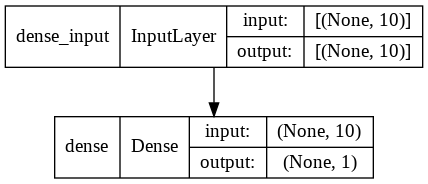

In [771]:
tf.keras.utils.plot_model(model=nn_freq_age_cat, show_shapes=True)

In [772]:
nn_freq_age_cat.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


We generate the second model, based on the numerical feature `ageph`.

In [773]:
nn_freq_age = tf.keras.models.Sequential()
nn_freq_age.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', input_shape= (nfeatures_age,), use_bias = True)) # Notice how we set use_bias = TRUE for the intercept.
nn_freq_age.compile(optimizer = 'RMSprop', loss = 'poisson')

tf.compat.v1.keras.backend.clear_session()

We also look at the structure of this second model.

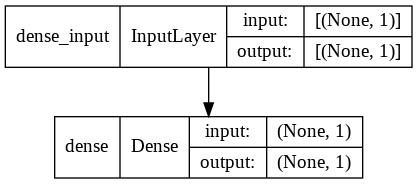

In [774]:
tf.keras.utils.plot_model(model=nn_freq_age, show_shapes=True)

In [775]:
nn_freq_age.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


We see that the structure of the two models is different, which is normal :


*   The model based on `ageph` has only 1 input, the numerical variable `ageph` : with the bias it has two parameters
*   The model based on the categorical variable `age_cat` has 10 inputs, namely the "dummy" [0/1] variables created using OneHotEncoder that serve as numerical input to the NN : it has 11 parameters



We then run the two models over 20 epochs and calculate the deviance on train and test set.

We notice from the printed output during the different epochs that the model on the numerical variable `ageph` starts off with a much bigger loss and takes some time before decreasing the loss; the decrease of the loss is still ongoing after the 20 epochs. The model on the categorical value starts with a lower loss that quickly decreases to stagnate after 10 epochs.

*(I have the impression that the results are not always the same when running the model : I understand that there are differences when the number of epochs increases, but the results even seem different the first time the model is running when this notebook is opened, i.e. when everything has been reset. That can influence the conclusions!)*

In [776]:
nn_freq_age_cat.fit(input_train_age_cat, 
                 output_train_age_cat_nn,
                 sample_weight = exposure_train_age_cat_nn,
                 epochs = 20,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 1)

nn_freq_age.fit(input_train_age, 
                 output_train_age_nn,
                 sample_weight = exposure_train_age_nn,
                 epochs = 20,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 1)

Epoch 1/20
128/128 [==============================] - 1s 2ms/step - loss: 0.8211
Epoch 2/20
128/128 [==============================] - 0s 1ms/step - loss: 0.6732
Epoch 3/20
128/128 [==============================] - 0s 1ms/step - loss: 0.5655
Epoch 4/20
128/128 [==============================] - 0s 1ms/step - loss: 0.4887
Epoch 5/20
128/128 [==============================] - 0s 1ms/step - loss: 0.4355
Epoch 6/20
128/128 [==============================] - 0s 2ms/step - loss: 0.4009
Epoch 7/20
128/128 [==============================] - 0s 2ms/step - loss: 0.3806
Epoch 8/20
128/128 [==============================] - 0s 1ms/step - loss: 0.3701
Epoch 9/20
128/128 [==============================] - 0s 1ms/step - loss: 0.3663
Epoch 10/20
128/128 [==============================] - 0s 1ms/step - loss: 0.3653
Epoch 11/20
128/128 [==============================] - 0s 1ms/step - loss: 0.3650
Epoch 12/20
128/128 [==============================] - 0s 2ms/step - loss: 0.3648
Epoch 13/20
128/128 [====

We define the Deviance for the Poisson loss in line with that defined previously for the GLM with Poisson distribution. 

That allows the comparison of performance between the NN and the GLM.

In [777]:
def Poisson_deviance_NN(model, x_data, y_data, expo) :
  # deviance residuals of poisson neural regression
  np.seterr(divide = 'ignore') 
  y_hat = model.predict(x_data)[:,0]  # [:,0] selects the predictions for the first output node
  log_ratio = np.where(y_data == 0, 0, np.log(y_data / y_hat))

  deviance_nn = 2 * sum(expo*(y_data * log_ratio - (y_data - y_hat)))

  return(deviance_nn)

In [778]:
print("The deviance for the NN with variable `age_cat` on the training set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_cat, input_train_age_cat, output_train_age_cat_nn, exposure_train_age_cat_nn)))
print("The deviance for the NN with variable `age_cat` on the test set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_cat, input_test_age_cat, output_test_age_cat_nn, exposure_test_age_cat_nn)))
print("")
print("The deviance for the NN with variable `age` on the training set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age, input_train_age, output_train_age_nn, exposure_train_age_nn)))
print("The deviance for the NN with variable `age` on the test set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age, input_test_age, output_test_age_nn, exposure_test_age_nn)))
print("")
print("The deviance for the GLM with variable `age_cat` on the training set is " + str("%.3f" % Poisson_deviance(glm_freq_age_cat, mtpl_train)))
print("The deviance for the GLM with variable `age_cat` on the test set is " + str("%.3f" % Poisson_deviance(glm_freq_age_cat, mtpl_test)))
print("")

The deviance for the NN with variable `age_cat` on the training set is 71170.580
The deviance for the NN with variable `age_cat` on the test set is 17694.849

The deviance for the NN with variable `age` on the training set is 73614.591
The deviance for the NN with variable `age` on the test set is 18200.025

The deviance for the GLM with variable `age_cat` on the training set is 71166.435
The deviance for the GLM with variable `age_cat` on the test set is 17688.723



The performance of the NN using variable `age_cat` is very comparable to that of the GLM. 

The performance of the NN using variable `age` is somewhat worse than that of the GLM, at least after 20 epochs. 

We run additional epochs on the NN using `ageph` to see what's the effect on the performance.

(***The following cell is EXTREMELY slow to run, it takes about 8 to 9 minutes! I would advice not to run it again everytime !***)

In [779]:
data=[]
train_dev_NN_age_cat = str("%.3f" % Poisson_deviance_NN(nn_freq_age_cat, input_train_age_cat, output_train_age_cat_nn, exposure_train_age_cat_nn))
test_dev_NN_age_cat = str("%.3f" % Poisson_deviance_NN(nn_freq_age_cat, input_test_age_cat, output_test_age_cat_nn, exposure_test_age_cat_nn))

train_dev_NN_age =  str("%.3f" % Poisson_deviance_NN(nn_freq_age, input_train_age, output_train_age_nn, exposure_train_age_nn))
test_dev_NN_age = str("%.3f" % Poisson_deviance_NN(nn_freq_age, input_test_age, output_test_age_nn, exposure_test_age_nn))

train_dev_GLM =  str("%.3f" % Poisson_deviance(glm_freq_age_cat, mtpl_train))
test_dev_GLM = str("%.3f" % Poisson_deviance(glm_freq_age_cat, mtpl_test))

data.append([20, train_dev_GLM, train_dev_NN_age_cat, train_dev_NN_age, test_dev_GLM, test_dev_NN_age_cat, test_dev_NN_age ])
for c in range(1, 11, 1):
  nn_freq_age_cat.fit(input_train_age_cat, 
                 output_train_age_cat_nn,
                 sample_weight = exposure_train_age_cat_nn,
                 epochs = 2,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 1)

  nn_freq_age.fit(input_train_age, 
                 output_train_age_nn,
                 sample_weight = exposure_train_age_nn,
                 epochs = 2,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 1)
  train_dev_NN_age_cat = str("%.3f" % Poisson_deviance_NN(nn_freq_age_cat, input_train_age_cat, output_train_age_cat_nn, exposure_train_age_cat_nn))
  test_dev_NN_age_cat = str("%.3f" % Poisson_deviance_NN(nn_freq_age_cat, input_test_age_cat, output_test_age_cat_nn, exposure_test_age_cat_nn))

  train_dev_NN_age =  str("%.3f" % Poisson_deviance_NN(nn_freq_age, input_train_age, output_train_age_nn, exposure_train_age_nn))
  test_dev_NN_age = str("%.3f" % Poisson_deviance_NN(nn_freq_age, input_test_age, output_test_age_nn, exposure_test_age_nn))

  train_dev_GLM =  str("%.3f" % Poisson_deviance(glm_freq_age_cat, mtpl_train))
  test_dev_GLM = str("%.3f" % Poisson_deviance(glm_freq_age_cat, mtpl_test))
  data.append([str(20+c*2), train_dev_GLM, train_dev_NN_age_cat, train_dev_NN_age, test_dev_GLM, test_dev_NN_age_cat, test_dev_NN_age ])
  
summary_nn=pd.DataFrame(data, columns=['Epochs', 'Deviance Train GLM age_cat', 'Deviance Train NN age_cat', 'Deviance Train NN age', 'Deviance Test GLM age_cat', 'Deviance Test NN age_cat', 'Deviance Test NN age',])
summary_nn.head(summary_nn.shape[0])

Epoch 1/2
128/128 [==============================] - 0s 1ms/step - loss: 0.3645
Epoch 2/2
128/128 [==============================] - 0s 2ms/step - loss: 0.3645
Epoch 1/2
128/128 [==============================] - 0s 1ms/step - loss: 0.3732
Epoch 2/2
128/128 [==============================] - 0s 2ms/step - loss: 0.3720
Epoch 1/2
128/128 [==============================] - 0s 1ms/step - loss: 0.3645
Epoch 2/2
128/128 [==============================] - 0s 1ms/step - loss: 0.3645
Epoch 1/2
128/128 [==============================] - 0s 1ms/step - loss: 0.3709
Epoch 2/2
128/128 [==============================] - 0s 1ms/step - loss: 0.3700
Epoch 1/2
128/128 [==============================] - 0s 1ms/step - loss: 0.3645
Epoch 2/2
128/128 [==============================] - 0s 1ms/step - loss: 0.3645
Epoch 1/2
128/128 [==============================] - 0s 1ms/step - loss: 0.3692
Epoch 2/2
128/128 [==============================] - 0s 2ms/step - loss: 0.3685
Epoch 1/2
128/128 [=====================

,Epochs,Deviance Train GLM age_cat,Deviance Train NN age_cat,Deviance Train NN age,Deviance Test GLM age_cat,Deviance Test NN age_cat,Deviance Test NN age
0,20,71166.435,71170.580,73614.591,17688.723,17694.849,18200.025
1,25,71166.435,71168.920,72927.046,17688.723,17693.225,18049.582
2,30,71166.435,71167.928,72450.041,17688.723,17691.660,17942.626
3,35,71166.435,71167.240,72089.241,17688.723,17691.195,17867.835
4,40,71166.435,71167.874,71844.497,17688.723,17691.107,17812.714
5,45,71166.435,71166.846,71685.566,17688.723,17690.684,17788.121
6,50,71166.435,71166.860,71627.162,17688.723,17690.424,17767.383
7,55,71166.435,71166.856,71472.599,17688.723,17689.814,17741.955
8,60,71166.435,71167.478,71637.723,17688.723,17689.075,17774.778
9,65,71166.435,71167.102,71466.934,17688.723,17689.620,17755.649


Even after 40 epochs, the NN using the numerical feature `ageph` is not yet fully stabilised. The model using `age_cat` as an input is no longer evolving in respect of its performance.

In [780]:
nn_freq_age.fit(input_train_age, 
                 output_train_age_nn,
                 sample_weight = exposure_train_age_nn,
                 epochs = 20,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 1)

print("The deviance for the NN with variable `age` on the training set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age, input_train_age, output_train_age_nn, exposure_train_age_nn)))
print("The deviance for the NN with variable `age` on the test set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age, input_test_age, output_test_age_nn, exposure_test_age_nn)))
print("")

Epoch 1/20
128/128 [==============================] - 0s 1ms/step - loss: 0.3654
Epoch 2/20
128/128 [==============================] - 0s 2ms/step - loss: 0.3654
Epoch 3/20
128/128 [==============================] - 0s 2ms/step - loss: 0.3654
Epoch 4/20
128/128 [==============================] - 0s 1ms/step - loss: 0.3654
Epoch 5/20
128/128 [==============================] - 0s 2ms/step - loss: 0.3653
Epoch 6/20
128/128 [==============================] - 0s 1ms/step - loss: 0.3654
Epoch 7/20
128/128 [==============================] - 0s 2ms/step - loss: 0.3654
Epoch 8/20
128/128 [==============================] - 0s 1ms/step - loss: 0.3654
Epoch 9/20
128/128 [==============================] - 0s 1ms/step - loss: 0.3653
Epoch 10/20
128/128 [==============================] - 0s 2ms/step - loss: 0.3653
Epoch 11/20
128/128 [==============================] - 0s 1ms/step - loss: 0.3653
Epoch 12/20
128/128 [==============================] - 0s 1ms/step - loss: 0.3653
Epoch 13/20
128/128 [====

We notice that the Deviance on the training set is still going down, while the Deviance on the test set is increasing a little bit. That might be an indication of a trend towards overfitting of the model.

We now add some graphics to show the output of the different models in function of the age of a policyholder.

We first define the risk profiles, which in this case only contain the age of the policyholder which is the single feature of the NNs we've built so far.

In [781]:
age_data = pd.Series(np.array(range(18,96))).to_frame()
age_data = age_data.rename(columns = {0:'age'})

age_data["age_cat"] = np.where(age_data['age'] < 21, "18-20", np.where(age_data['age'] <24 ,"21-23", \
                              np.where(age_data['age'] < 27, "24-26", np.where(age_data['age'] < 30, "27-29", \
                              np.where(age_data['age'] < 35, "30-34", np.where(age_data['age'] < 40, "35-39", \
                              np.where(age_data['age'] < 50, "40-49", \
                              np.where(age_data['age'] < 60, "50-59", \
                              np.where(age_data['age'] < 80, "60-79", ">=80")))))))))
age_data.head(age_data.shape[0])

,age,age_cat
0,18,18-20
1,19,18-20
2,20,18-20
3,21,21-23
4,22,21-23
...,...,...
73,91,>=80
74,92,>=80
75,93,>=80
76,94,>=80


We predict the outcomes of the models for this riskprofile. For the model using `age_cat` as an input, we first need to change the `age_cat` feature to a numerical input.

In [782]:
age_data_input=preprocessing_age_cat.transform(age_data)

age_data['Pred_NN_age_cat']=nn_freq_age_cat.predict(age_data_input)

age_data['Pred_NN_age']=nn_freq_age.predict(age_data.age)

age_data['Pred_GLM_age_cat']=glm_freq_age_cat.predict(age_data.age_cat)
age_data.head(age_data.shape[0])

,age,age_cat,Pred_NN_age_cat,Pred_NN_age,Pred_GLM_age_cat
0,18,18-20,0.289557,0.213166,0.305021
1,19,18-20,0.289557,0.209493,0.305021
2,20,18-20,0.289557,0.205884,0.305021
3,21,21-23,0.262936,0.202337,0.264925
4,22,21-23,0.262936,0.198851,0.264925
...,...,...,...,...,...
73,91,>=80,0.125795,0.059942,0.126903
74,92,>=80,0.125795,0.058910,0.126903
75,93,>=80,0.125795,0.057895,0.126903
76,94,>=80,0.125795,0.056897,0.126903


Now we plot the outputs (predictions) of the different models in function of the age of the policyholders.

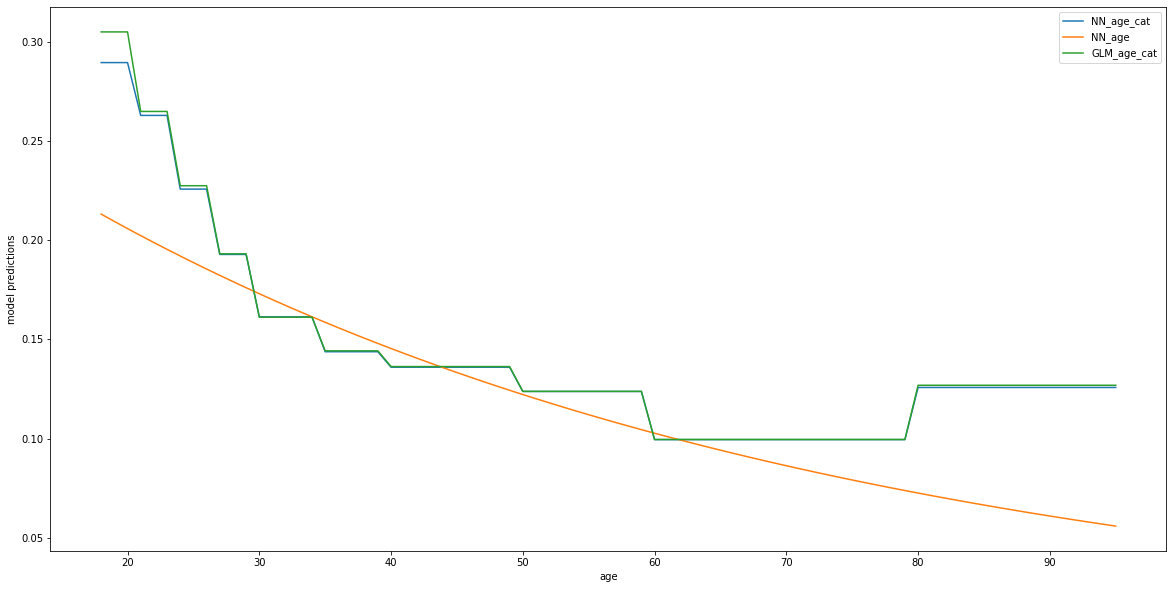

In [783]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(age_data.age, age_data.Pred_NN_age_cat, label = 'NN_age_cat')
plt.plot(age_data.age, age_data.Pred_NN_age, label = 'NN_age')
plt.plot(age_data.age, age_data.Pred_GLM_age_cat, label = 'GLM_age_cat')
plt.xlabel('age')
plt.ylabel('model predictions')
plt.legend()
plt.show()

We see that the NN based on `age_cat` is generating predictions that closely match those of the GLM. The NN based on age as a numerical feature (`ageph`) shows a strictly decreasing line.

We now add some layers to the model using the numerical input for policyholder age to see what the impact is on the predictions, e.g. will the predictions still show a strictly decreasing line with increasing policyholder age?

We first add a second layer, using the `relu` activation function. We then try out the effect of a different activation function, Leaky Relu, with parameter 0.1 (= slope for the negative part of the activation function).

In [784]:
nn_freq_age_2layers = tf.keras.models.Sequential()
nn_freq_age_2layers.add(tf.keras.layers.BatchNormalization(input_shape = (nfeatures_age,))) # layer_batch_normalization centers and scales the input features
nn_freq_age_2layers.add(tf.keras.layers.Dense(units = 10, activation = 'relu')) # Hidden layer with 10 nodes and relu activation function
nn_freq_age_2layers.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', use_bias = True)) 
nn_freq_age_2layers.compile(optimizer = 'RMSprop', loss = 'poisson')

tf.compat.v1.keras.backend.clear_session()

nn_freq_age_2layers.fit(input_train_age, 
                 output_train_age_nn,
                 sample_weight = exposure_train_age_nn,
                 epochs = 20,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 0)

In [785]:
nn_freq_age_2layers_lrelu = tf.keras.models.Sequential()
nn_freq_age_2layers_lrelu.add(tf.keras.layers.BatchNormalization(input_shape = (nfeatures_age,))) # layer_batch_normalization centers and scales the input features
nn_freq_age_2layers_lrelu.add(tf.keras.layers.Dense(units = 10, activation=tf.keras.layers.LeakyReLU(alpha=0.1))) # Hidden layer with 10 nodes and Leakyrelu activation function
nn_freq_age_2layers_lrelu.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', use_bias = True)) 
nn_freq_age_2layers_lrelu.compile(optimizer = 'RMSprop', loss = 'poisson')

tf.compat.v1.keras.backend.clear_session()

nn_freq_age_2layers_lrelu.fit(input_train_age, 
                 output_train_age_nn,
                 sample_weight = exposure_train_age_nn,
                 epochs = 20,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 0)


In [786]:
print("The deviance for the single layer NN with variable `age` on the training set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age, input_train_age, output_train_age_nn, exposure_train_age_nn)))
print("The deviance for the single layer NN with variable `age` on the test set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age, input_test_age, output_test_age_nn, exposure_test_age_nn)))
print("")
print("The deviance for the two layer NN with activation function ReLU with variable `age` on the training set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_2layers, input_train_age, output_train_age_nn, exposure_train_age_nn)))
print("The deviance for the two layer NN with activation function ReLU with variable `age` on the test set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_2layers, input_test_age, output_test_age_nn, exposure_test_age_nn)))
print("")
print("The deviance for the two layer NN with activation function Leaky ReLU with variable `age` on the training set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_2layers_lrelu, input_train_age, output_train_age_nn, exposure_train_age_nn)))
print("The deviance for the two layer NN with activation function Leaky ReLU with variable `age` on the test set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_2layers_lrelu, input_test_age, output_test_age_nn, exposure_test_age_nn)))
print("")

The deviance for the single layer NN with variable `age` on the training set is 71389.220
The deviance for the single layer NN with variable `age` on the test set is 17736.188

The deviance for the two layer NN with activation function ReLU with variable `age` on the training set is 71180.491
The deviance for the two layer NN with activation function ReLU with variable `age` on the test set is 17692.386

The deviance for the two layer NN with activation function Leaky ReLU with variable `age` on the training set is 71215.981
The deviance for the two layer NN with activation function Leaky ReLU with variable `age` on the test set is 17702.295



With the second layer the model predictions somewhat better fit the observations, after the same number of epochs.

They also follow the predictions of the GLM a little closer.

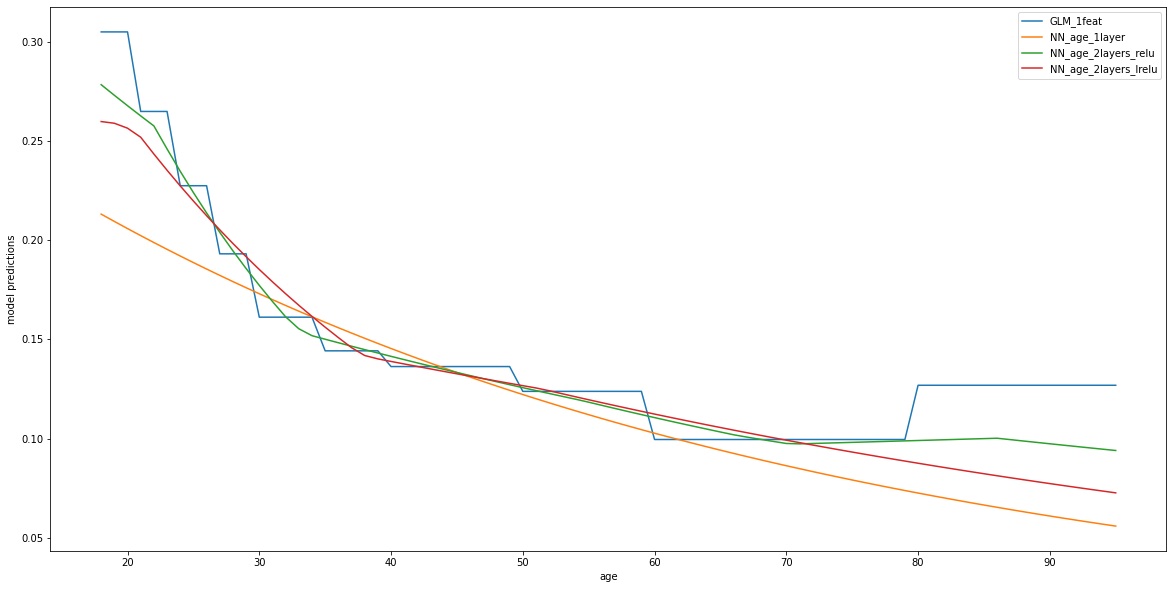

In [787]:
age_data['Pred_NN_age_2layers']=nn_freq_age_2layers.predict(age_data.age)
age_data['Pred_NN_age_2layers_lrelu']=nn_freq_age_2layers_lrelu.predict(age_data.age)
# age_data.head(age_data.shape[0])

plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(age_data.age, age_data.Pred_GLM_age_cat, label = 'GLM_1feat')
plt.plot(age_data.age, age_data.Pred_NN_age, label = 'NN_age_1layer')
plt.plot(age_data.age, age_data.Pred_NN_age_2layers, label = 'NN_age_2layers_relu')
plt.plot(age_data.age, age_data.Pred_NN_age_2layers_lrelu, label = 'NN_age_2layers_lrelu')
plt.xlabel('age')
plt.ylabel('model predictions')
plt.legend()
plt.show()

*(It shows that using the Leaky ReLU as activation function, strictly decreasing trend in the frequency in function of increasing age can apparently be broken.)*

*----- This is a comment I made when I obtained a line that actually had a little "bump up" around age 45 ----- This phenomenon is not always reproduced -----*

We have a look at the impact of the paramater that specifies the slope of the negative part of the Leaky ReLU activation function. We'll set it to the (standard) value of 0.01 and to 0.2 to assess the impact.

In [788]:
nn_freq_age_2layers_lrelu2 = tf.keras.models.Sequential()
nn_freq_age_2layers_lrelu2.add(tf.keras.layers.BatchNormalization(input_shape = (nfeatures_age,))) # layer_batch_normalization centers and scales the input features
nn_freq_age_2layers_lrelu2.add(tf.keras.layers.Dense(units = 10, activation=tf.keras.layers.LeakyReLU(alpha=0.01))) # Hidden layer with 10 nodes and Leakyrelu activation function
nn_freq_age_2layers_lrelu2.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', use_bias = True)) 
nn_freq_age_2layers_lrelu2.compile(optimizer = 'RMSprop', loss = 'poisson')

tf.compat.v1.keras.backend.clear_session()

nn_freq_age_2layers_lrelu2.fit(input_train_age, 
                 output_train_age_nn,
                 sample_weight = exposure_train_age_nn,
                 epochs = 10,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 0)

nn_freq_age_2layers_lrelu3 = tf.keras.models.Sequential()
nn_freq_age_2layers_lrelu3.add(tf.keras.layers.BatchNormalization(input_shape = (nfeatures_age,))) # layer_batch_normalization centers and scales the input features
nn_freq_age_2layers_lrelu3.add(tf.keras.layers.Dense(units = 10, activation=tf.keras.layers.LeakyReLU(alpha=0.2))) # Hidden layer with 10 nodes and Leakyrelu activation function
nn_freq_age_2layers_lrelu3.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', use_bias = True)) 
nn_freq_age_2layers_lrelu3.compile(optimizer = 'RMSprop', loss = 'poisson')

tf.compat.v1.keras.backend.clear_session()

nn_freq_age_2layers_lrelu3.fit(input_train_age, 
                 output_train_age_nn,
                 sample_weight = exposure_train_age_nn,
                 epochs = 10,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 0)

print("The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with variable `age` on the training set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_2layers_lrelu, input_train_age, output_train_age_nn, exposure_train_age_nn)))
print("The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with variable `age` on the test set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_2layers_lrelu, input_test_age, output_test_age_nn, exposure_test_age_nn)))
print("")
print("The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.01) with variable `age` on the training set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_2layers_lrelu2, input_train_age, output_train_age_nn, exposure_train_age_nn)))
print("The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.01) with variable `age` on the test set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_2layers_lrelu2, input_test_age, output_test_age_nn, exposure_test_age_nn)))
print("")
print("The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.2) with variable `age` on the training set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_2layers_lrelu3, input_train_age, output_train_age_nn, exposure_train_age_nn)))
print("The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.2) with variable `age` on the test set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_2layers_lrelu3, input_test_age, output_test_age_nn, exposure_test_age_nn)))
print("")


The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with variable `age` on the training set is 71215.981
The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with variable `age` on the test set is 17702.295

The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.01) with variable `age` on the training set is 71231.610
The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.01) with variable `age` on the test set is 17707.736

The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.2) with variable `age` on the training set is 71256.856
The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.2) with variable `age` on the test set is 17710.946



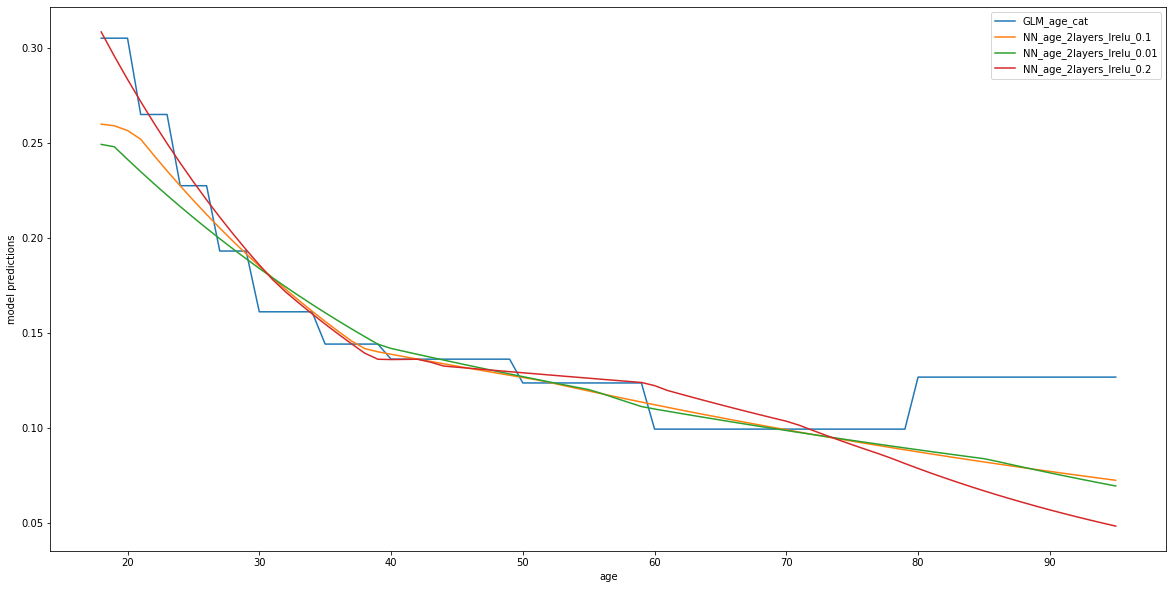

In [789]:
age_data['Pred_NN_age_2layers_lrelu2']=nn_freq_age_2layers_lrelu2.predict(age_data.age)
age_data['Pred_NN_age_2layers_lrelu3']=nn_freq_age_2layers_lrelu3.predict(age_data.age)
# age_data.head(age_data.shape[0])

plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(age_data.age, age_data.Pred_GLM_age_cat, label = 'GLM_age_cat')
plt.plot(age_data.age, age_data.Pred_NN_age_2layers_lrelu, label = 'NN_age_2layers_lrelu_0.1')
plt.plot(age_data.age, age_data.Pred_NN_age_2layers_lrelu2, label = 'NN_age_2layers_lrelu_0.01')
plt.plot(age_data.age, age_data.Pred_NN_age_2layers_lrelu3, label = 'NN_age_2layers_lrelu_0.2')
plt.xlabel('age')
plt.ylabel('model predictions')
plt.legend()
plt.show()

Using other parameters in the Leaky ReLU activation function does not change the estimations that much, the general trend is the same. We observe some "local breaks" in the strictly decreasing trend however.

Let's take a look at a NN with 3 layers, using the Leaky ReLU function as activation function.

In [790]:
nn_freq_age_3layers = tf.keras.models.Sequential()
nn_freq_age_3layers.add(tf.keras.layers.BatchNormalization(input_shape = (nfeatures_age,))) # layer_batch_normalization centers and scales the input features
nn_freq_age_3layers.add(tf.keras.layers.Dense(units = 5, activation=tf.keras.layers.LeakyReLU(alpha=0.1))) # Hidden layer with 5 nodes and Leaky relu activation function
nn_freq_age_3layers.add(tf.keras.layers.Dense(units = 5, activation=tf.keras.layers.LeakyReLU(alpha=0.1))) # Hidden layer with 5 nodes and Leaky relu activation function
nn_freq_age_3layers.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', use_bias = True)) 
nn_freq_age_3layers.compile(optimizer = 'RMSprop', loss = 'poisson')

tf.compat.v1.keras.backend.clear_session()

nn_freq_age_3layers.fit(input_train_age, 
                 output_train_age_nn,
                 sample_weight = exposure_train_age_nn,
                 epochs = 20,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 0)

print("The deviance for the single layer NN with variable `age` on the training set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age, input_train_age, output_train_age_nn, exposure_train_age_nn)))
print("The deviance for the single layer NN with variable `age` on the test set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age, input_test_age, output_test_age_nn, exposure_test_age_nn)))
print("")
print("The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with variable `age` on the training set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_2layers_lrelu, input_train_age, output_train_age_nn, exposure_train_age_nn)))
print("The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with variable `age` on the test set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_2layers_lrelu, input_test_age, output_test_age_nn, exposure_test_age_nn)))
print("")
print("The deviance for the three layer NN with activation function Leaky ReLU (parameter 0.1) with variable `age` on the training set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_3layers, input_train_age, output_train_age_nn, exposure_train_age_nn)))
print("The deviance for the three layer NN with activation function Leaky ReLU (parameter 0.1) with variable `age` on the test set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_age_3layers, input_test_age, output_test_age_nn, exposure_test_age_nn)))
print("")

The deviance for the single layer NN with variable `age` on the training set is 71389.220
The deviance for the single layer NN with variable `age` on the test set is 17736.188

The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with variable `age` on the training set is 71215.981
The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with variable `age` on the test set is 17702.295

The deviance for the three layer NN with activation function Leaky ReLU (parameter 0.1) with variable `age` on the training set is 71213.062
The deviance for the three layer NN with activation function Leaky ReLU (parameter 0.1) with variable `age` on the test set is 17705.500



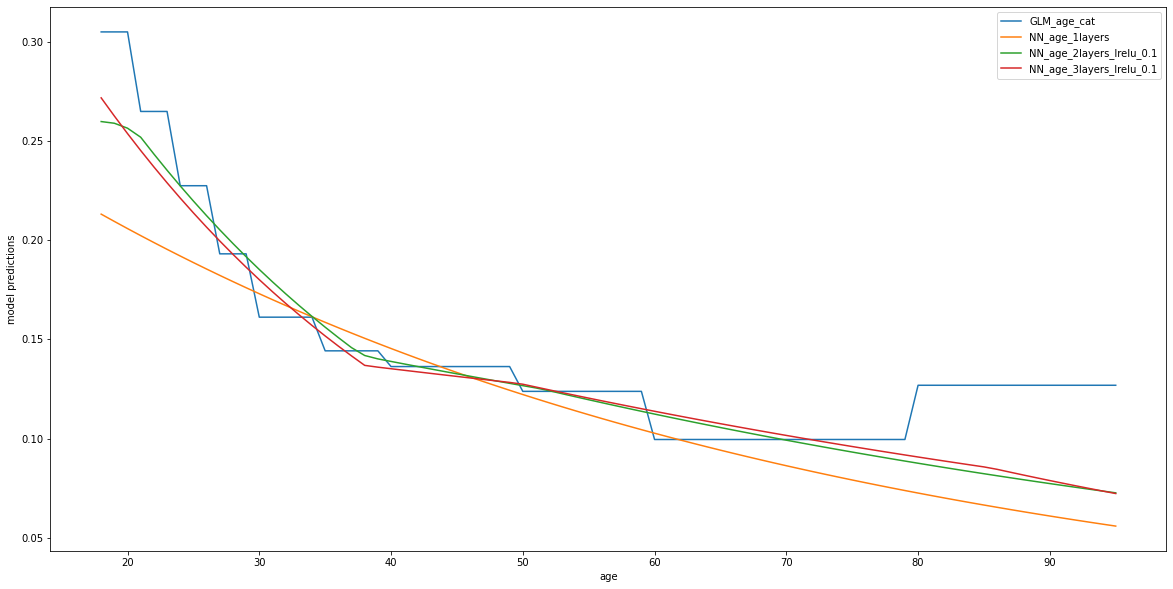

In [791]:
age_data['Pred_NN_age_3layers_lrelu']=nn_freq_age_3layers.predict(age_data.age)
# age_data.head(age_data.shape[0])

plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(age_data.age, age_data.Pred_GLM_age_cat, label = 'GLM_age_cat')
plt.plot(age_data.age, age_data.Pred_NN_age, label = 'NN_age_1layers')
plt.plot(age_data.age, age_data.Pred_NN_age_2layers_lrelu, label = 'NN_age_2layers_lrelu_0.1')
plt.plot(age_data.age, age_data.Pred_NN_age_3layers_lrelu, label = 'NN_age_3layers_lrelu_0.1')
plt.xlabel('age')
plt.ylabel('model predictions')
plt.legend()
plt.show()

There are no immediate new insights from this picture, for a model with a lot more parameters (cfr. below). 

In [792]:
print(nn_freq_age_2layers.summary())
print(nn_freq_age_3layers.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 1)                4         
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 10)                20        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 35
Trainable params: 33
Non-trainable params: 2
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 1)                4         
 ormalization)                     

## 5.2 NN with two features `age_cat` and `province` (categorical) <a name="five-two"></a>

In order to use the `province` feature as input for a NN, it needs to be transformed into [0/1] dummy variables using OneHotEncoder.

We then define the model, using 2 layers and the Leaky ReLU function.

In [793]:
mtpl_train_nn_2feat=mtpl_train.drop(columns=['expo','lnexpo',	'nbrtotan',	'nbrtotc', 'chargtot', 'agecar',	'fuelc',	'split',	'coverp',	'powerc',	'pop_bucket', 'sexp',	'fleetc',	'sportc',	'city_size', 'usec'])
mtpl_test_nn_2feat=mtpl_test.drop(columns=['expo', 'lnexpo',	'nbrtotan',	'nbrtotc','chargtot',	'agecar', 'fuelc',	'split',	'coverp',	'powerc', 'pop_bucket', 'sexp',	'fleetc',	'sportc',	'city_size', 'usec'])
exposure_train_nn_2feat=np.array(mtpl_train["expo"])
exposure_test_nn_2feat=np.array(mtpl_test["expo"])
output_train_nn_2feat=np.array(mtpl_train["nbrtotan"])
output_test_nn_2feat=np.array(mtpl_test["nbrtotan"])

preprocessing_nn_2feat = ColumnTransformer(transformers=[('cat', OneHotEncoder(), ['age_cat']), ('pro', OneHotEncoder(), ['province'])], remainder='passthrough')

preprocessing_nn_2feat.fit(mtpl_train_nn_2feat, mtpl_test_nn_2feat)
input_train_nn_2feat=preprocessing_nn_2feat.transform(mtpl_train_nn_2feat)
input_test_nn_2feat=preprocessing_nn_2feat.transform(mtpl_test_nn_2feat)

nfeatures_nn_2feat=input_train_nn_2feat.shape[1]

nn_freq_2feat = tf.keras.models.Sequential()
nn_freq_2feat.add(tf.keras.layers.Dense(units = 10, activation=tf.keras.layers.LeakyReLU(alpha=0.1))) # Hidden layer with 10 nodes and Leaky relu activation function
nn_freq_2feat.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', input_shape= (nfeatures_nn_2feat,), use_bias = True)) # Notice how we set use_bias = TRUE for the intercept.
nn_freq_2feat.compile(optimizer = 'RMSprop', loss = 'poisson')

tf.compat.v1.keras.backend.clear_session()

We then run the model over 20 epochs.

In [794]:
nn_freq_2feat.fit(input_train_nn_2feat, 
                 output_train_nn_2feat,
                 sample_weight = exposure_train_nn_2feat,
                 epochs = 20,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 0)


In [795]:
print("The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with variables `age_cat' and 'province' on the training set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_2feat, input_train_nn_2feat, output_train_nn_2feat, exposure_train_nn_2feat)))
print("The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with variables `age_cat' and 'province' on the test set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_2feat, input_test_nn_2feat, output_test_nn_2feat, exposure_test_nn_2feat)))
print("")

print("The deviance for the GLM with variable `age_cat` and 'province' on the training set is " + str("%.3f" % Poisson_deviance(glm_freq_province, mtpl_train)))
print("The deviance for the GLM with variable `age_cat` and 'province' on the test set is " + str("%.3f" % Poisson_deviance(glm_freq_province, mtpl_test)))
print("")

The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with variables `age_cat' and 'province' on the training set is 70709.761
The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with variables `age_cat' and 'province' on the test set is 17568.449

The deviance for the GLM with variable `age_cat` and 'province' on the training set is 70718.083
The deviance for the GLM with variable `age_cat` and 'province' on the test set is 17562.880



The NN has about the same performance as the GLM with the same two features developed in section 4.3.

We now try to plot the predictions for a riskprofile that combines the age (`age_cat`) feature with the `province` feature.

We define a dictionnary of dataframes risk profiles, each specific for a different category of the feature `province`. This was influenced by the discussion on https://stackoverflow.com/questions/40973687/create-new-dataframe-in-pandas-with-dynamic-names-also-add-new-column .

In [796]:
riskprofile_nn_2feat=age_data.copy()
riskprofile_nn_2feat=riskprofile_nn_2feat[["age", "age_cat"]]
riskprofile_nn_2feat.head()

,age,age_cat
0,18,18-20
1,19,18-20
2,20,18-20
3,21,21-23
4,22,21-23


In [797]:
dict_of_riskprofiles = {}
for prov in mtpl_train.province.value_counts().index :

    key_name = 'riskprofile_nn_2feat_'+prov    

    dict_of_riskprofiles[key_name] = riskprofile_nn_2feat.copy()
    dict_of_riskprofiles[key_name]['province'] = prov
   

for c in dict_of_riskprofiles.keys() :
  print(c)

riskprofile_nn_2feat_AT_VB_HN
riskprofile_nn_2feat_LUIK
riskprofile_nn_2feat_OVLA
riskprofile_nn_2feat_WVLA
riskprofile_nn_2feat_BRUS
riskprofile_nn_2feat_NAMN
riskprofile_nn_2feat_LIMB
riskprofile_nn_2feat_BRWA
riskprofile_nn_2feat_LUXB


In [798]:
dict_of_riskprofiles['riskprofile_nn_2feat_OVLA'].head()

,age,age_cat,province
0,18,18-20,OVLA
1,19,18-20,OVLA
2,20,18-20,OVLA
3,21,21-23,OVLA
4,22,21-23,OVLA


In order for these risk profiles to be ran through the NN with two features, the categorical variables first need to be transformed into [0/1] dummy variables.

In [799]:
nn_input_riskprofiles = {}
for prov in mtpl_train.province.value_counts().index :

    key_name = 'riskprofile_for_'+prov
    reference = 'riskprofile_nn_2feat_'+prov     

    nn_input_riskprofiles[key_name] = preprocessing_nn_2feat.transform(dict_of_riskprofiles[reference].drop(columns = 'age'))   


In [800]:
for prov in mtpl_train.province.value_counts().index :

    key_name = 'riskprofile_nn_2feat_'+prov    
    input = 'riskprofile_for_'+prov
    
    dict_of_riskprofiles[key_name]['prediction_NN'] = nn_freq_2feat.predict(nn_input_riskprofiles[input])
    dict_of_riskprofiles[key_name]['prediction_GLM'] = glm_freq_province.predict(dict_of_riskprofiles[key_name])
   

In [801]:
dict_of_riskprofiles['riskprofile_nn_2feat_OVLA'].head()

,age,age_cat,province,prediction_NN,prediction_GLM
0,18,18-20,OVLA,0.260895,0.312358
1,19,18-20,OVLA,0.260895,0.312358
2,20,18-20,OVLA,0.260895,0.312358
3,21,21-23,OVLA,0.285244,0.273702
4,22,21-23,OVLA,0.285244,0.273702


We plot the frequencies per age for the different `province` categories.

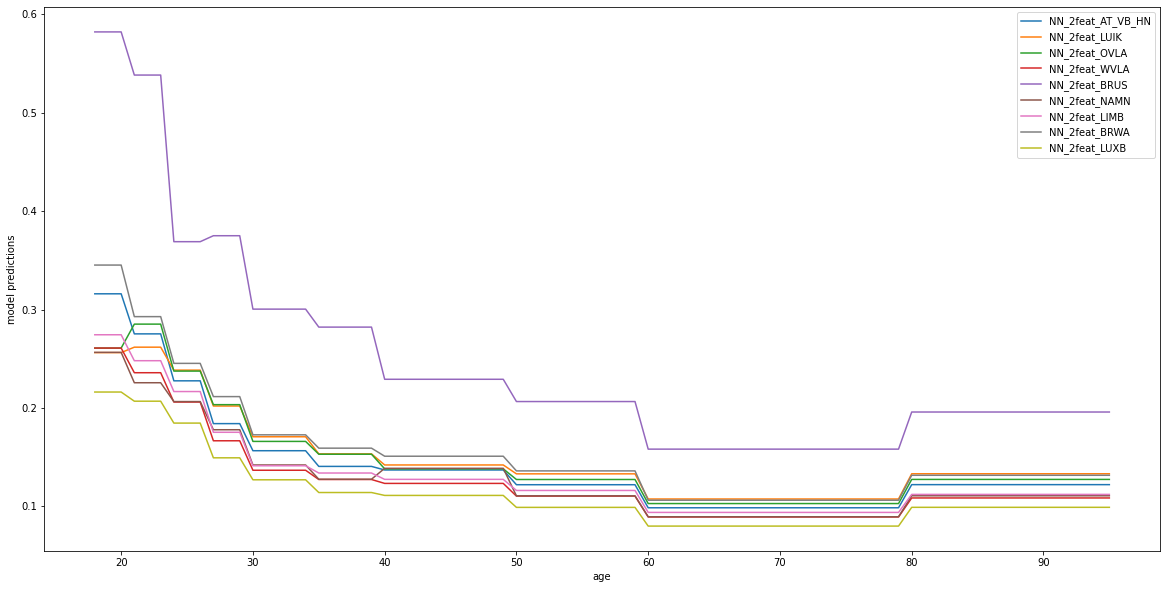

In [802]:
plt.rcParams['figure.figsize'] = [20, 10]
for prov in mtpl_train.province.value_counts().index :

    key_name = 'riskprofile_nn_2feat_'+prov    
    plt.plot(age_data.age, dict_of_riskprofiles[key_name]['prediction_NN'], label = 'NN_2feat_'+prov)

plt.xlabel('age')
plt.ylabel('model predictions')
plt.legend()
plt.show()


We create the same plot for the risk profiles pushed through the GLM with two features created in section 4.3.

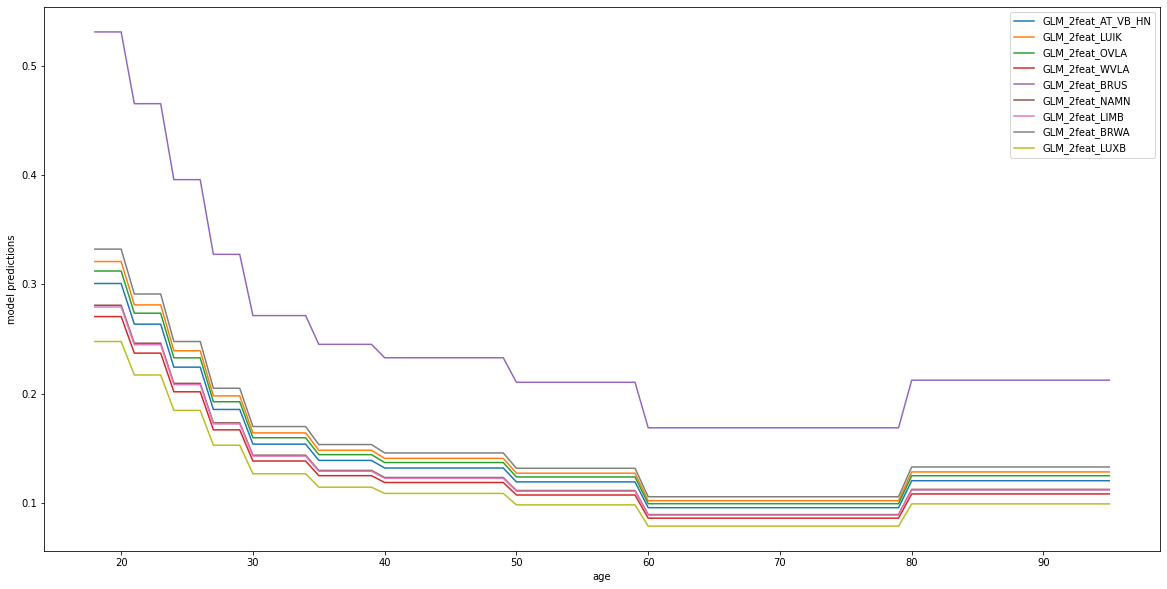

In [803]:
plt.rcParams['figure.figsize'] = [20, 10]
for prov in mtpl_train.province.value_counts().index :

    key_name = 'riskprofile_nn_2feat_'+prov    
    plt.plot(age_data.age, dict_of_riskprofiles[key_name]['prediction_GLM'], label = 'GLM_2feat_'+prov)

plt.xlabel('age')
plt.ylabel('model predictions')
plt.legend()
plt.show()

The frequency in Brussels is clearly a lot higher than that in the other provinces.

We can also plot the comparison between NN and GLM per province.

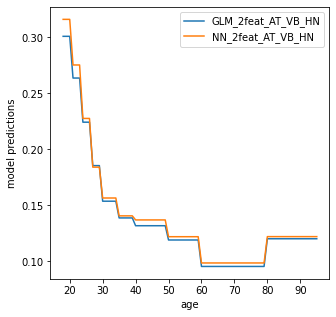

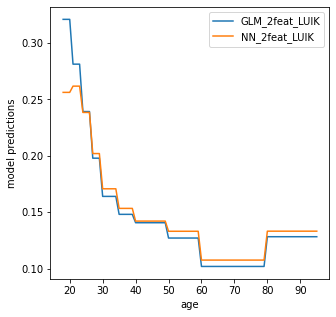

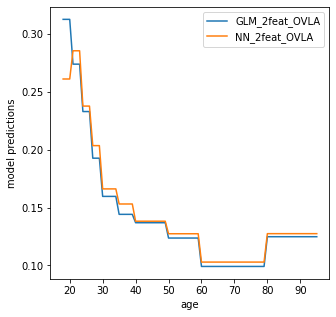

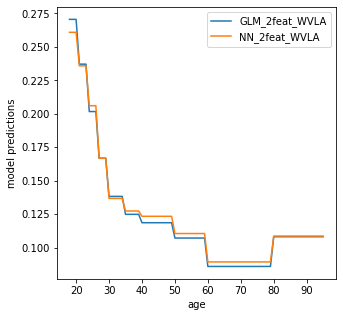

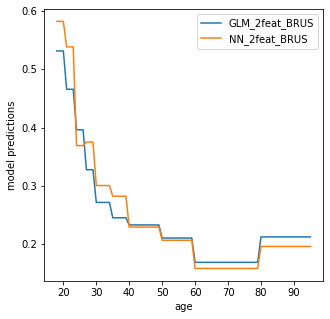

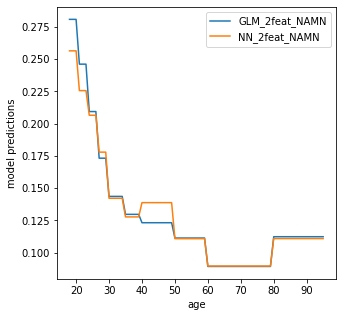

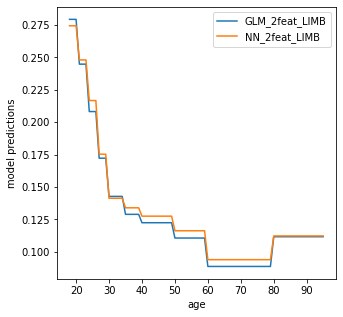

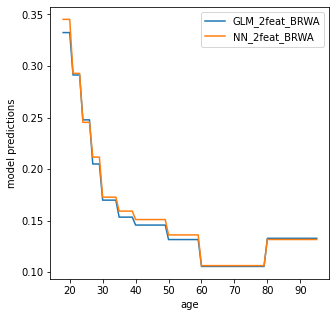

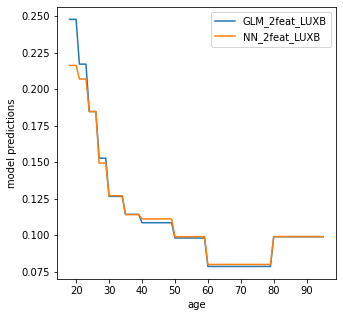

In [804]:
for prov in mtpl_train.province.value_counts().index :
  plt.rcParams['figure.figsize'] = [5, 5]
  key_name = 'riskprofile_nn_2feat_'+prov    
  plt.plot(age_data.age, dict_of_riskprofiles[key_name]['prediction_GLM'], label = 'GLM_2feat_'+prov)
  plt.plot(age_data.age, dict_of_riskprofiles[key_name]['prediction_NN'], label = 'NN_2feat_'+prov)
  plt.xlabel('age')
  plt.ylabel('model predictions')
  plt.legend()
  plt.show()

## 5.3 NN with all the features used in the final GLM <a name="five-three"></a>

In order to use the `province` feature as input for a NN, it needs to be transformed into [0/1] dummy variables using OneHotEncoder.

We then define the model, using 2 layers and the Leaky ReLU function.

In [805]:
mtpl_train_nn_allfeat=mtpl_train.drop(columns=['expo','lnexpo',	'nbrtotan',	'nbrtotc', 'chargtot', 'sexp',	'fleetc',	'sportc',	'city_size', 'usec'])
mtpl_test_nn_allfeat=mtpl_test.drop(columns=['expo', 'lnexpo',	'nbrtotan',	'nbrtotc','chargtot', 'sexp',	'fleetc',	'sportc',	'city_size', 'usec'])
exposure_train_nn_allfeat=np.array(mtpl_train["expo"])
exposure_test_nn_allfeat=np.array(mtpl_test["expo"])
output_train_nn_allfeat=np.array(mtpl_train["nbrtotan"])
output_test_nn_allfeat=np.array(mtpl_test["nbrtotan"])

preprocessing_nn_allfeat = ColumnTransformer(transformers=[('cat', OneHotEncoder(), ['age_cat']), 
                                           ('pro', OneHotEncoder(), ['province']), 
                                           ('spl', OneHotEncoder(), ['split']), 
                                           ('pop', OneHotEncoder(), ['pop_bucket']), 
                                           ('fue', OneHotEncoder(), ['fuelc']), 
                                           ('cov', OneHotEncoder(), ['coverp']), 
                                           ('car', OneHotEncoder(), ['agecar']), 
                                           ('pwr', OneHotEncoder(), ['powerc'])], 
                                           remainder='passthrough')

preprocessing_nn_allfeat.fit(mtpl_train_nn_allfeat, mtpl_test_nn_allfeat)
input_train_nn_allfeat=preprocessing_nn_allfeat.transform(mtpl_train_nn_allfeat)
input_test_nn_allfeat=preprocessing_nn_allfeat.transform(mtpl_test_nn_allfeat)

nfeatures_nn_allfeat=input_train_nn_allfeat.shape[1]

nn_freq_allfeat = tf.keras.models.Sequential()
nn_freq_allfeat.add(tf.keras.layers.Dense(units = 10, activation=tf.keras.layers.LeakyReLU(alpha=0.1))) # Hidden layer with 10 nodes and Leaky relu activation function
nn_freq_allfeat.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', input_shape= (nfeatures_nn_allfeat,), use_bias = True)) # Notice how we set use_bias = TRUE for the intercept.
nn_freq_allfeat.compile(optimizer = 'RMSprop', loss = 'poisson')

tf.compat.v1.keras.backend.clear_session()

We then run the model on 20 epochs and compare the performance to the final GLM from section 4.

In [806]:
nn_freq_allfeat.fit(input_train_nn_allfeat, 
                 output_train_nn_allfeat,
                 sample_weight = exposure_train_nn_allfeat,
                 epochs = 20,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 0)


In [807]:
print("The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with all variables on the training set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_allfeat, input_train_nn_allfeat, output_train_nn_allfeat, exposure_train_nn_allfeat)))
print("The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with all variables on the test set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_allfeat, input_test_nn_allfeat, output_test_nn_allfeat, exposure_test_nn_allfeat)))
print("")
print("The deviance for the GLM with variable `age_cat` and 'province' on the training set is " + str("%.3f" % Poisson_deviance(glm_freq_powerc, mtpl_train)))
print("The deviance for the GLM with variable `age_cat` and 'province' on the test set is " + str("%.3f" % Poisson_deviance(glm_freq_powerc, mtpl_test)))

The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with all variables on the training set is 69892.416
The deviance for the two layer NN with activation function Leaky ReLU (parameter 0.1) with all variables on the test set is 17443.154

The deviance for the GLM with variable `age_cat` and 'province' on the training set is 70008.920
The deviance for the GLM with variable `age_cat` and 'province' on the test set is 17434.520


After 20 epochs, the performance of the NN is about the same as that of the GLM.
We'll run the NN through some more epochs to assess the evolution of the performance.

In [808]:
data=[]
data.append([20, str("%.3f" % Poisson_deviance_NN(nn_freq_allfeat, input_train_nn_allfeat, output_train_nn_allfeat, exposure_train_nn_allfeat)), str("%.3f" % Poisson_deviance_NN(nn_freq_allfeat, input_test_nn_allfeat, output_test_nn_allfeat, exposure_test_nn_allfeat))])
for c in range(1, 8, 1):
  nn_freq_allfeat.fit(input_train_nn_allfeat, 
                 output_train_nn_allfeat,
                 sample_weight = exposure_train_nn_allfeat,
                 epochs = 5,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 0)
  data.append([str(20+c*5), str("%.3f" % Poisson_deviance_NN(nn_freq_allfeat, input_train_nn_allfeat, output_train_nn_allfeat, exposure_train_nn_allfeat)), str("%.3f" % Poisson_deviance_NN(nn_freq_allfeat, input_test_nn_allfeat, output_test_nn_allfeat, exposure_test_nn_allfeat))])

summary_nn=pd.DataFrame(data, columns=['Epochs', 'Deviance Train', 'Deviance Test'])
summary_nn.head(summary_nn.shape[0])


,Epochs,Deviance Train,Deviance Test
0,20,69892.416,17443.154
1,25,69870.905,17445.367
2,30,69858.865,17450.026
3,35,69842.174,17447.825
4,40,69828.589,17448.316
5,45,69843.297,17454.185
6,50,69821.927,17456.907
7,55,69796.306,17450.983


There is no improvement in the performance of the model, especially on the test set.

We can add another layer to the NN model, this has no real impact on the predicting power.

In [809]:
nn_freq_allfeat2 = tf.keras.models.Sequential()
nn_freq_allfeat2.add(tf.keras.layers.Dense(units = 10, activation=tf.keras.layers.LeakyReLU(alpha=0.1))) # Hidden layer with 10 nodes and Leaky relu activation function
nn_freq_allfeat2.add(tf.keras.layers.Dense(units = 10, activation=tf.keras.layers.LeakyReLU(alpha=0.1))) # Hidden layer with 10 nodes and Leaky relu activation function
nn_freq_allfeat2.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', input_shape= (nfeatures_nn_allfeat,), use_bias = True)) # Notice how we set use_bias = TRUE for the intercept.
nn_freq_allfeat2.compile(optimizer = 'RMSprop', loss = 'poisson')

tf.compat.v1.keras.backend.clear_session()

nn_freq_allfeat2.fit(input_train_nn_allfeat, 
                 output_train_nn_allfeat,
                 sample_weight = exposure_train_nn_allfeat,
                 epochs = 20,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 0)

print("The deviance for the three layer NN with activation function Leaky ReLU (parameter 0.1) with all variables on the training set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_allfeat2, input_train_nn_allfeat, output_train_nn_allfeat, exposure_train_nn_allfeat)))
print("The deviance for the three layer NN with activation function Leaky ReLU (parameter 0.1) with all variables on the test set is " + str("%.3f" % Poisson_deviance_NN(nn_freq_allfeat2, input_test_nn_allfeat, output_test_nn_allfeat, exposure_test_nn_allfeat)))
print("")
print("The deviance for the GLM with variable `age_cat` and 'province' on the training set is " + str("%.3f" % Poisson_deviance(glm_freq_powerc, mtpl_train)))
print("The deviance for the GLM with variable `age_cat` and 'province' on the test set is " + str("%.3f" % Poisson_deviance(glm_freq_powerc, mtpl_test)))

The deviance for the three layer NN with activation function Leaky ReLU (parameter 0.1) with all variables on the training set is 69953.010
The deviance for the three layer NN with activation function Leaky ReLU (parameter 0.1) with all variables on the test set is 17461.490

The deviance for the GLM with variable `age_cat` and 'province' on the training set is 70008.920
The deviance for the GLM with variable `age_cat` and 'province' on the test set is 17434.520
